In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*was renamed to 'ensure_all_finite'.*")

# Checking data 

In [2]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\AVG_Gas.csv")

df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

Time Period (T)  Home charging (G)  Electric car (G)  Hybrid electric (G)  \
0      2007-01-01                  0                 1                    0   
1      2007-02-01                  0                 0                    0   
2      2007-03-01                  0                 0                    0   
3      2007-04-01                  0                 0                    0   
4      2007-05-01                  0                 2                    0   

   Company car tax rate (%)  Consumer confidence (E)  \
0                        22                     20.0   
1                        22                     20.0   
2                        22                     20.0   
3                        22                     20.0   
4                        22                     18.0   

   Economic climate perception (E)  Willingness to buy (E)  \
0                             37.0                     9.0   
1                             37.0                     9.0   
2                             37.0                     9.0   
3                             37.0                     9.0   
4                             32.0                     9.0   

   Major purchases sentiment (E)  Gasoline (Euro95) - Average price (F)  \
0                            8.0                               1.303032   
1                            8.0                               1.325357   
2                            8.0                               1.379032   
3                            8.0                               1.426500   
4                            7.4                               1.466516   

   Diesel - Average price (F)  Total vehicles sold (Target)  
0                    0.970000                            31  
1                    0.990000                            39  
2                    1.006323                           123  
3                    1.030600                            62  
4                    1.032323                            84

# Exploring PCA from dataset 

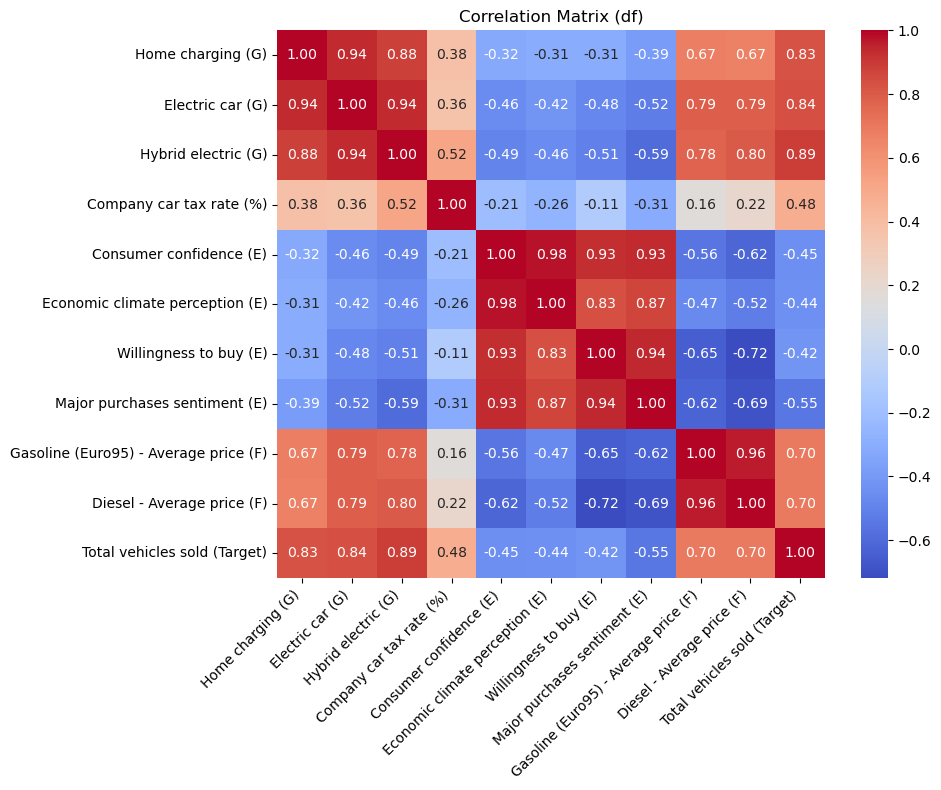

In [3]:


# Compute correlation matrix for df
corr_matrix_avg = df.select_dtypes(include=['number']).corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_avg, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (df)")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

> looking at the data we see that the top 5 rows are as follows:

# Data workflow

## Split data

Target value opschuiven aan de hand van n forcasting window, daarna pas trainval  test split uitvoeren 

n forcasting is gelijk aan 
check literatuur over hoe lang het zou moeten zijn

In [4]:
from pprint import pprint

# Totale lengte van de dataset
n_total = len(df)

# Bepaal het aantal observaties voor elke subset
n_train = int(n_total * 0.8)
n_val = int(n_total * 0.1)
n_test = n_total - n_train - n_val  # Zorgt dat alles optelt tot n_total

# Chronologische split
train = df.iloc[:n_train].copy()
val = df.iloc[n_train:n_train + n_val].copy()
test = df.iloc[n_train + n_val:].copy()

# Print splitsinformatie
print(f"Train: {train.shape}, Validation: {val.shape}, Test: {test.shape}")
print(f"Train ends: {train['Time Period (T)'].iloc[-1]}")
print(f"Validation ends: {val['Time Period (T)'].iloc[-1]}")
print(f"Test ends: {test['Time Period (T)'].iloc[-1]}")

print("\nTrain date range:")
print(f"{train['Time Period (T)'].iloc[0]} → {train['Time Period (T)'].iloc[-1]}")

print("\nValidation date range:")
print(f"{val['Time Period (T)'].iloc[0]} → {val['Time Period (T)'].iloc[-1]}")

print("\nTest date range:")
print(f"{test['Time Period (T)'].iloc[0]} → {test['Time Period (T)'].iloc[-1]}")

# Print percentage splits
pct_train = 100 * len(train) / n_total
pct_val = 100 * len(val) / n_total
pct_test = 100 * len(test) / n_total

print(f"\nPercentage splits:")
print(f"Train: {pct_train:.1f}%")
print(f"Validation: {pct_val:.1f}%")
print(f"Test: {pct_test:.1f}%")


Train: (173, 12), Validation: (21, 12), Test: (23, 12)
Train ends: 2021-05-01 00:00:00
Validation ends: 2023-02-01 00:00:00
Test ends: 2025-01-01 00:00:00

Train date range:
2007-01-01 00:00:00 → 2021-05-01 00:00:00

Validation date range:
2021-06-01 00:00:00 → 2023-02-01 00:00:00

Test date range:
2023-03-01 00:00:00 → 2025-01-01 00:00:00

Percentage splits:
Train: 79.7%
Validation: 9.7%
Test: 10.6%


## PLot target variable

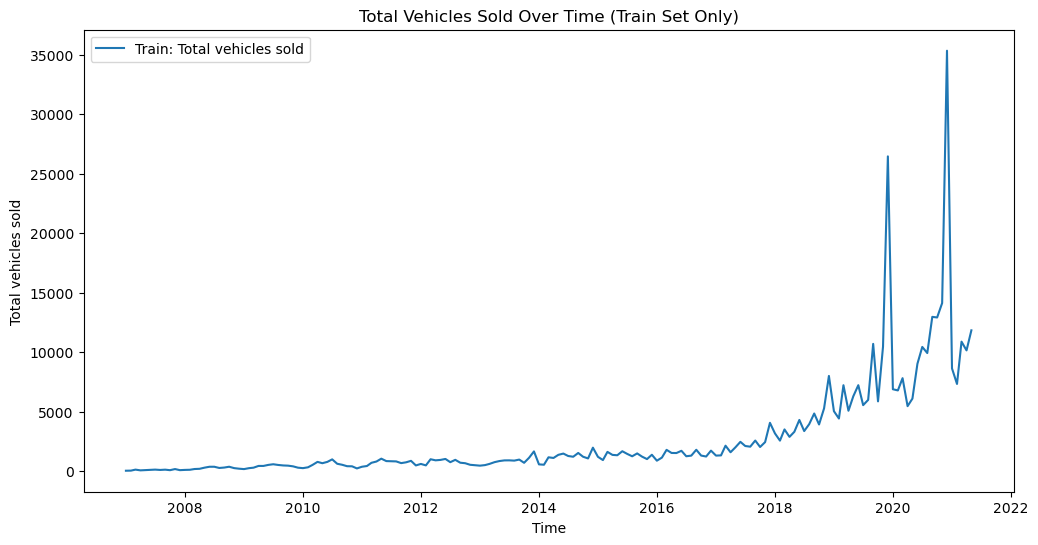

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], train["Total vehicles sold (Target)"], label="Train: Total vehicles sold")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Total Vehicles Sold Over Time (Train Set Only)")
plt.legend()
plt.show()

> Alot of varience, lets add box cox 

Optimal lambda for Box-Cox (train): -0.0017


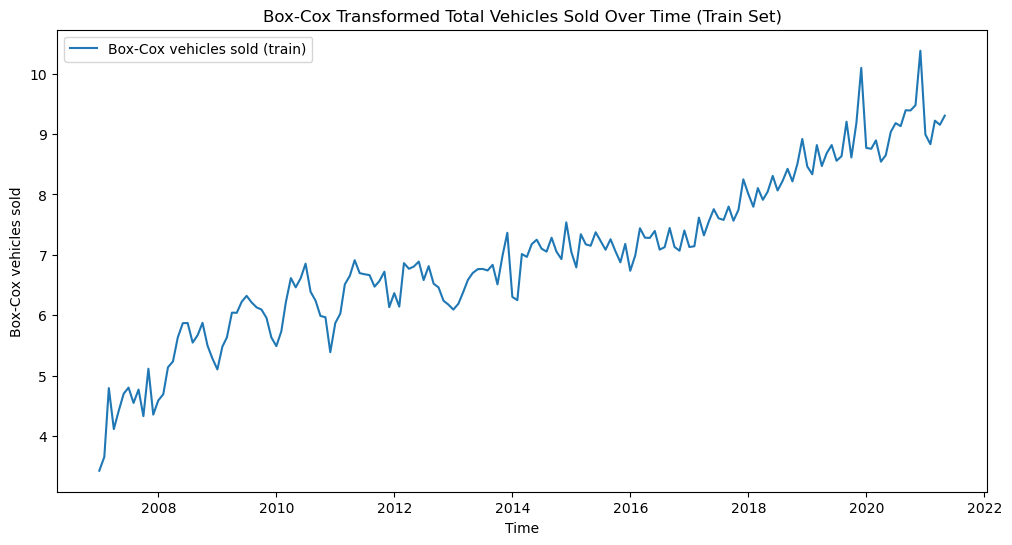

In [6]:
# Select the target column from train set
target_col = 'Total vehicles sold (Target)'
y_train = train[target_col].values

# Box-Cox requires all values > 0
if (y_train <= 0).any():
    raise ValueError("Box-Cox transformation requires all values to be positive.")

# Perform Box-Cox transformation
y_train_boxcox, fitted_lambda_train = boxcox(y_train)

# Add transformed values to the train dataframe
train['BoxCox vehicles sold (Target)'] = y_train_boxcox

print(f"Optimal lambda for Box-Cox (train): {fitted_lambda_train:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], y_train_boxcox, label="Box-Cox vehicles sold (train)")
plt.xlabel("Time")
plt.ylabel("Box-Cox vehicles sold")
plt.title("Box-Cox Transformed Total Vehicles Sold Over Time (Train Set)")
plt.legend()
plt.show()


Little les varience 

### Check for stationality

The variencie is much better now, however there is still an upward trend and some seasonality visable in the data, to test the stationality i will performing a unit root test. 

there are several unit root tests available, such as the Augmented Dickey-Fuller (ADF) test, the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, and the Phillips-Perron (PP) test. I will be using the ADF test, which is a widely used test for stationarity in time series data. 

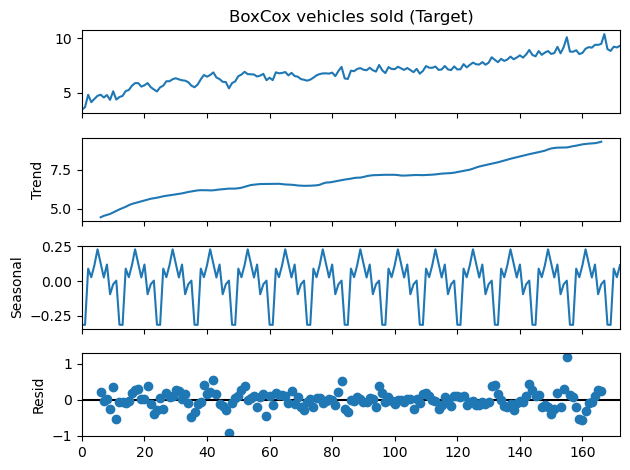

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(train["BoxCox vehicles sold (Target)"], model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()

The trend component shows a general upward slope — maybe structural growth?
But it’s not explosive, so first differencing might not be critical.
Residuals Look Reasonable
Mostly noise, no major drift or autocorrelation

Suggests decomposition handled the series cleanly


In [8]:
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs

# Use BoxCox-transformed target from train set
y = train['BoxCox vehicles sold (Target)']

# Augmented Dickey-Fuller test
adf_result = adfuller(y)
print("ADF Statistic: {:.4f}".format(adf_result[0]))
print("ADF p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"ADF Critical Value ({key}): {value:.4f}")
if adf_result[1] < 0.05:
    print("ADF: The series is likely stationary (reject H0).")
else:
    print("ADF: The series is likely non-stationary (fail to reject H0).")

# KPSS test
kpss_result = kpss(y, regression='c', nlags="auto")
print("\nKPSS Statistic: {:.4f}".format(kpss_result[0]))
print("KPSS p-value: {:.4f}".format(kpss_result[1]))
for key, value in kpss_result[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")
if kpss_result[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

# Recommended number of differences
adf_ndiffs = ndiffs(y, test='adf')
kpss_ndiffs = ndiffs(y, test='kpss')
print(f"\nRecommended differences (ADF): {adf_ndiffs}")
print(f"Recommended differences (KPSS): {kpss_ndiffs}")

ADF Statistic: -0.2705
ADF p-value: 0.9296
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely non-stationary (fail to reject H0).

KPSS Statistic: 1.8855
KPSS p-value: 0.0100
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).

Recommended differences (ADF): 1
Recommended differences (KPSS): 1


C:\Users\dylan\AppData\Local\Temp\ipykernel_24668\3267893201.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(y, regression='c', nlags="auto")


> With an ADF statistic of -0.4743, and a high p-value of 0.8187, we have failed to reject the null hypothesis meaning the series still likely contains a unit root (i.e. it's non-stationary) even after applying Box-Cox.

my next step is to apply a first difference to the data to remove the trend, and then re-evaluate stationarity using the ADF test again.

### Apply first difference

Stationarity tests per step:


C:\Users\dylan\AppData\Local\Temp\ipykernel_24668\1250915473.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(s, regression='c', nlags="auto")
C:\Users\dylan\AppData\Local\Temp\ipykernel_24668\1250915473.py:48: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(s, regression='c', nlags="auto")


Series  ADF p-value  ADF Stationary?  KPSS p-value  \
0               Original     0.903044            False          0.01   
1  Original + First diff     0.008452             True          0.10   

   KPSS Stationary?  
0             False  
1              True


Advice:
- No seasonal differencing needed (nsdiffs=0)
- First difference (diff(1)) recommended (ndiffs=1)

Result: series ready for SARIMA(X): 'Original + First diff'


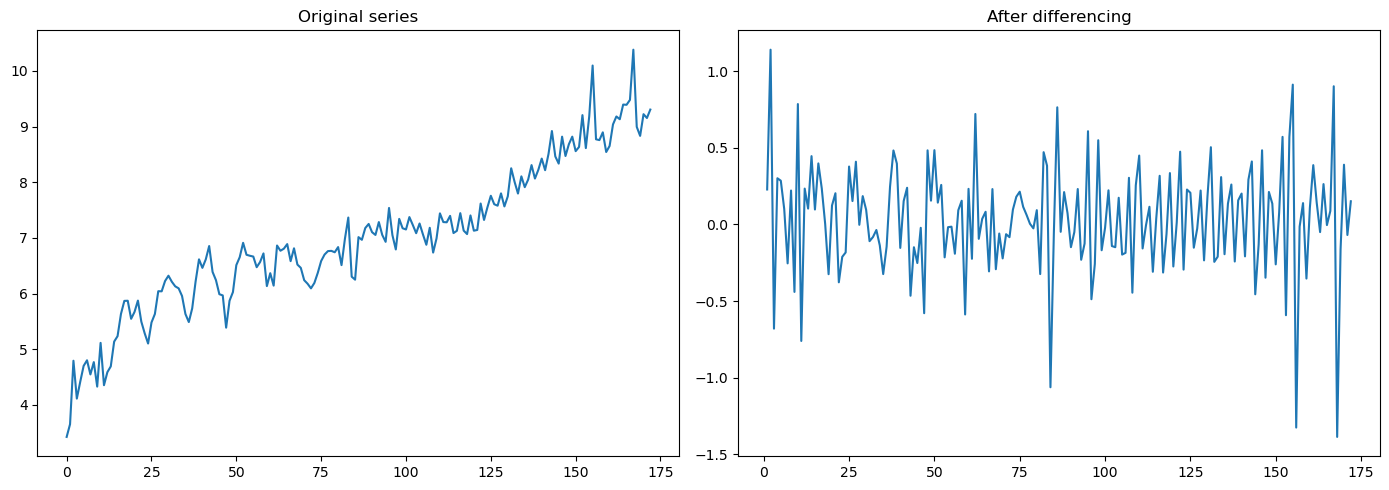

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs, nsdiffs
import pandas as pd

import matplotlib.pyplot as plt

def stationarity_diagnostics(series, freq=12, verbose=True):
    results = []
    s = series.copy()
    name = "Original"
    
    # 1. ADF & KPSS on original series
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(s, autolag='AIC', maxlag=12)
    kpss_stat, kpss_p, _, kpss_crit = kpss(s, regression='c', nlags="auto")
    results.append({
        "Series": name,
        "ADF p-value": adf_p,
        "ADF Stationary?": adf_p < 0.05,
        "KPSS p-value": kpss_p,
        "KPSS Stationary?": kpss_p > 0.05
    })
    
    # 2. ndiffs & nsdiffs
    n_diff = ndiffs(s, test='adf')
    n_seasonal = nsdiffs(s, m=freq, test='ocsb')
    
    # 3. Seasonal differencing if needed
    if n_seasonal > 0:
        s = s.diff(freq).dropna()
        name = f"Seasonal diff ({freq})"
        adf_stat, adf_p, _, _, adf_crit, _ = adfuller(s, autolag='AIC', maxlag=12)
        kpss_stat, kpss_p, _, kpss_crit = kpss(s, regression='c', nlags="auto")
        results.append({
            "Series": name,
            "ADF p-value": adf_p,
            "ADF Stationary?": adf_p < 0.05,
            "KPSS p-value": kpss_p,
            "KPSS Stationary?": kpss_p > 0.05
        })
        # Recalculate ndiffs after seasonal diff
        n_diff = ndiffs(s, test='adf')
    
    # 4. First difference if needed
    if n_diff > 0:
        s = s.diff().dropna()
        name = f"{name} + First diff"
        adf_stat, adf_p, _, _, adf_crit, _ = adfuller(s, autolag='AIC', maxlag=12)
        kpss_stat, kpss_p, _, kpss_crit = kpss(s, regression='c', nlags="auto")
        results.append({
            "Series": name,
            "ADF p-value": adf_p,
            "ADF Stationary?": adf_p < 0.05,
            "KPSS p-value": kpss_p,
            "KPSS Stationary?": kpss_p > 0.05
        })
    
    # 5. Summary
    summary = pd.DataFrame(results)
    if verbose:
        print("Stationarity tests per step:")
        display(summary)
        print("\nAdvice:")
        if n_seasonal > 0:
            print(f"- Seasonal differencing (diff({freq})) recommended (nsdiffs={n_seasonal})")
        else:
            print("- No seasonal differencing needed (nsdiffs=0)")
        if n_diff > 0:
            print(f"- First difference (diff(1)) recommended (ndiffs={n_diff})")
        else:
            print("- No first difference needed (ndiffs=0)")
        print(f"\nResult: series ready for SARIMA(X): '{name}'")
    
    # 6. Plot before/after
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(series, label="Original")
    plt.title("Original series")
    plt.subplot(1,2,2)
    plt.plot(s, label="Transformed")
    plt.title("After differencing")
    plt.tight_layout()
    plt.show()
    
    return s

# Example usage on BoxCox vehicles sold (Target) from train:
transformed_series = stationarity_diagnostics(train['BoxCox vehicles sold (Target)'], freq=12)

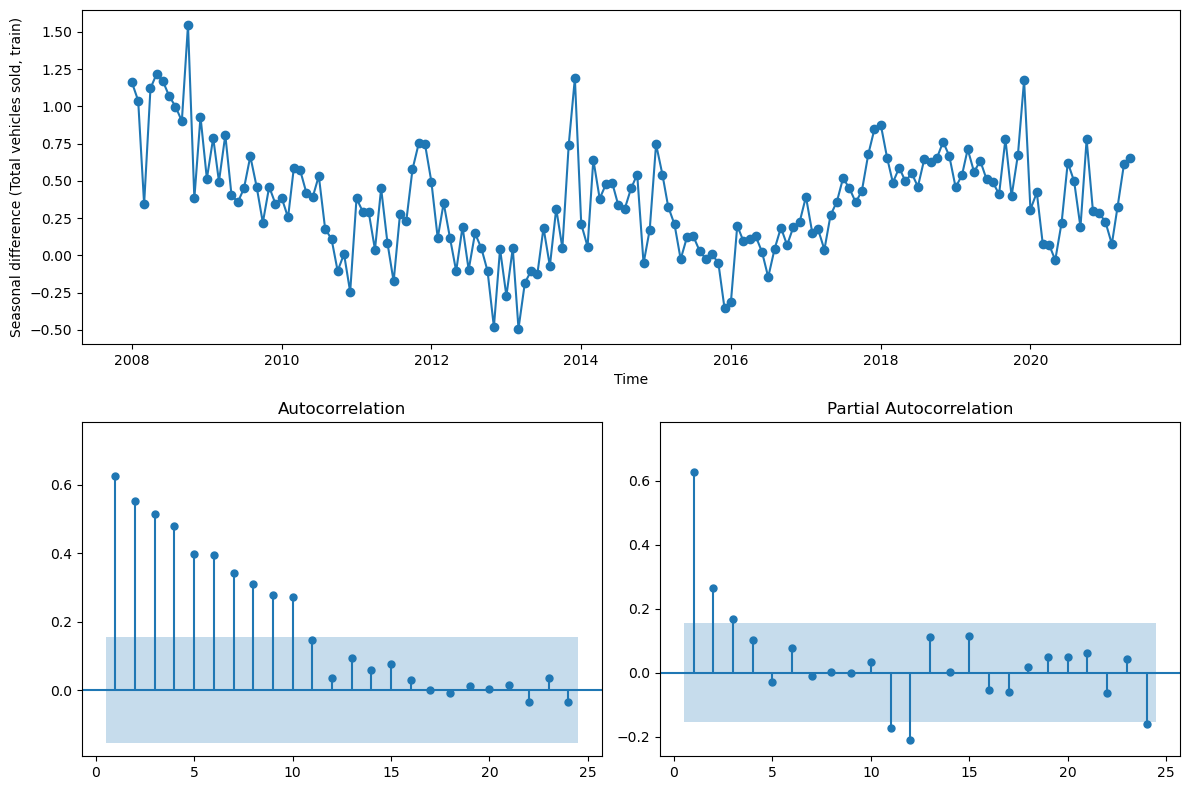

ADF Statistic (seasonal differenced, train): -3.1130
p-value: 0.0256
Critical Value (1%): -3.4753
Critical Value (5%): -2.8813
Critical Value (10%): -2.5773
The series is likely stationary (reject H0).

KPSS Statistic (seasonal differenced, train): 0.2588
KPSS p-value: 0.1000
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_24668\666028984.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_train = kpss(seasonal_diff_train, regression='c', nlags="auto")


In [10]:
# Rename for clarity
boxcox_target_sales_train = train["BoxCox vehicles sold (Target)"]

# Calculate lag difference 
seasonal_diff_train = boxcox_target_sales_train.diff(12).dropna()

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(train["Time Period (T)"].iloc[12:], seasonal_diff_train, marker="o")
ax1.set_ylabel("Seasonal difference (Total vehicles sold, train)")
ax1.set_xlabel("Time")

plot_acf(seasonal_diff_train, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff_train, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF test
adf_result_train = adfuller(seasonal_diff_train)
print("ADF Statistic (seasonal differenced, train): {:.4f}".format(adf_result_train[0]))
print("p-value: {:.4f}".format(adf_result_train[1]))
for key, value in adf_result_train[4].items():
    print(f"Critical Value ({key}): {value:.4f}")
print("The series is likely " + ("stationary (reject H0)." if adf_result_train[1] < 0.05 else "non-stationary (fail to reject H0)."))

# KPSS test
kpss_result_train = kpss(seasonal_diff_train, regression='c', nlags="auto")
print("\nKPSS Statistic (seasonal differenced, train): {:.4f}".format(kpss_result_train[0]))
print("KPSS p-value: {:.4f}".format(kpss_result_train[1]))
for key, value in kpss_result_train[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")
print("KPSS: The series is likely " + ("non-stationary (reject H0)." if kpss_result_train[1] < 0.05 else "stationary (fail to reject H0)."))



ACF Plot Interpretation:
The ACF plot shows a significant spike at lag 1, followed by a gradual decay. This pattern is characteristic of a non-seasonal MA(1) process. Additionally, there's a prominent spike at lag 12, suggesting a seasonal component at the yearly level (monthly data), indicative of seasonal MA(1).

PACF Plot Interpretation:
The PACF plot shows a strong spike at lag 1, and a possible smaller spike at lag 2, followed by a sharp decline. This pattern supports the presence of a non-seasonal AR(1) or possibly AR(2) term. A clear spike at lag 12 also appears in the PACF, followed by mild decay, suggesting a seasonal AR(1) component.

Suggested Model:
Based on the ACF and PACF patterns, a suitable model would be:
SARIMA(1,1,1)(1,1,1)[12]


In [11]:

# Add Box-Cox transformed target to validation set if not present
if 'BoxCox vehicles sold (Target)' not in val.columns:
    # Use the same lambda as for train
    val['BoxCox vehicles sold (Target)'] = boxcox(val['Total vehicles sold (Target)'], lmbda=fitted_lambda_train)

# Define your model configurations
model_configs = {
    "SARIMA(2,0,0)(0,1,1)[12]": {"order": (2, 0, 0), "seasonal_order": (0, 1, 1, 12)},
    "SARIMA(1,0,1)(0,1,1)[12]": {"order": (1, 0, 1), "seasonal_order": (0, 1, 1, 12)},
    "SARIMA(2,0,1)(0,1,0)[12]": {"order": (2, 0, 1), "seasonal_order": (0, 1, 0, 12)},
}

# Store results for comparison
results_summary = []

for name, config in model_configs.items():
    print(f"\nFitting model: {name}")
    
    # Fit on train set only
    model = SARIMAX(
        train["BoxCox vehicles sold (Target)"],
        order=config["order"],
        seasonal_order=config["seasonal_order"],
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    result = model.fit(disp=False)
    
    # Forecast for validation period
    val_steps = len(val)
    forecast = result.get_forecast(steps=val_steps)
    preds = forecast.predicted_mean
    actuals = val["BoxCox vehicles sold (Target)"]
    
    # Calculate metrics for validation set
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mape = mean_absolute_percentage_error(actuals, preds) * 100
    
    # Check significance of coefficients (p-values < 0.05)
    pvalues = result.pvalues
    all_significant = (pvalues < 0.05).all()
    
    # Store summary
    results_summary.append({
        "Model": name,
        "AIC (Train)": result.aic,
        "BIC (Train)": result.bic,
        "RMSE (Val)": rmse,
        "MAPE (Val)": mape,
        "All Coeffs Significant": all_significant
    })
    
    print(result.summary())

# Create a DataFrame for quick comparison
summary_df = pd.DataFrame(results_summary).sort_values("AIC (Train)")
print("\n\n Model Comparison:")
print(summary_df)


Fitting model: SARIMA(2,0,0)(0,1,1)[12]
                                      SARIMAX Results                                       
Dep. Variable:        BoxCox vehicles sold (Target)   No. Observations:                  173
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                   2.716
Date:                              Mon, 28 Jul 2025   AIC                              2.568
Time:                                      16:30:37   BIC                             14.557
Sample:                                           0   HQIC                             7.439
                                              - 173                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5868      0.051     11.532      0.000   

Winner: SARIMAX(1,0,1)(0,1,1)[12]
Best AIC (-24.211) and log-likelihood

All coefficients statistically significant

No unnecessary seasonal AR term

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


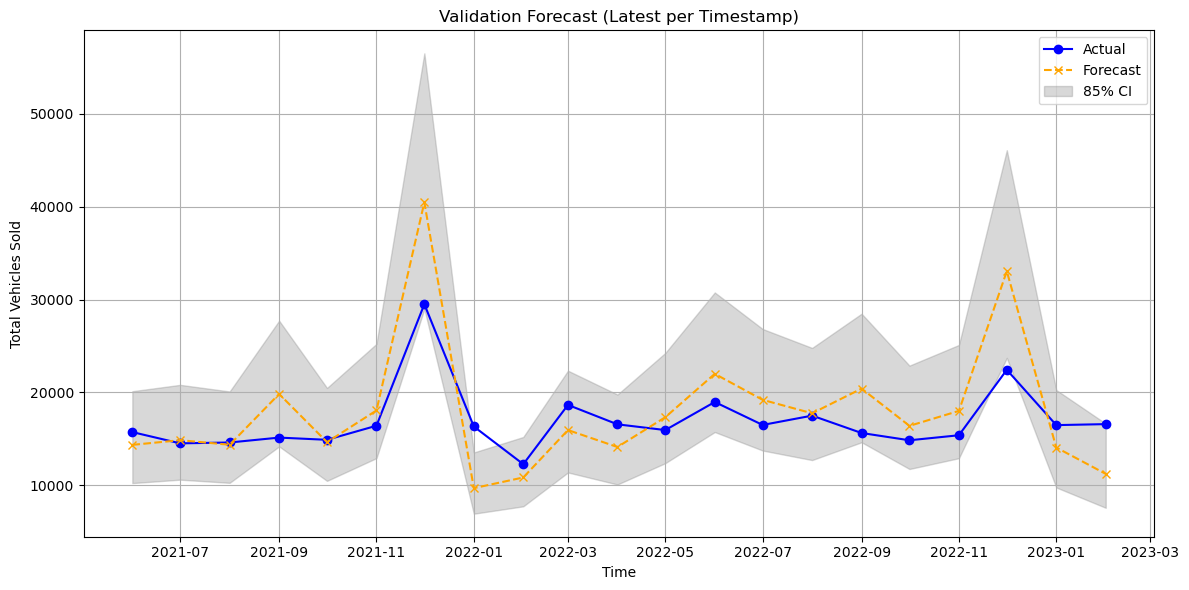

Rolling validation RMSE (mean over windows): 4688.39
Rolling validation MAPE (mean over windows): 21.45%


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from collections import defaultdict

# Ensure boxcox_lambda_target_sales is defined
boxcox_lambda_target_sales = fitted_lambda_train  # or set to the correct lambda value

# Set forecast_horizon to the number of validation steps
forecast_horizon = 3

# Use the actual variables already present in the notebook
# train, val_slice, boxcox_lambda_target_sales, forecast_horizon are already defined

# No need to redefine train, val, or extract columns from empty DataFrames
# boxcox_target_sales_train = train['BoxCox vehicles sold (Target)']  # Not needed
# boxcox_target_sales_val = val_slice['BoxCox vehicles sold (Target)']     # Not needed
# boxcox_lambda_target_sales = fitted_lambda_train                         # Already defined as boxcox_lambda_target_sales

# train is already defined and contains the correct columns

val_rolling_results = []
combined_forecast_dates = []
combined_forecast_values = []
combined_actual_values = []
combined_lower_85 = []
combined_upper_85 = []


# Check of de validatieset groot genoeg is voor rolling forecast
if len(val) < forecast_horizon:
    print(f"⚠️ Validation set ({len(val)} maanden) is te klein voor forecast horizon ({forecast_horizon}). Loop wordt overgeslagen.")
else:
    for start in range(len(val) - forecast_horizon + 1):
        val_slice = val.iloc[start:start + forecast_horizon].copy()
        val_dates = pd.to_datetime(val_slice["Time Period (T)"])

        # Bouw uitgebreide trainset inclusief eerdere validatiepunten
        if start > 0:
            train_expanded = pd.concat([train, val.iloc[:start].copy()])
        else:
            train_expanded = train.copy()

        # Box-Cox target uit uitgebreide trainset
        boxcox_target_sales_train_expanded = train_expanded['BoxCox vehicles sold (Target)']

        # SARIMAX model fitten
        model = SARIMAX(
            boxcox_target_sales_train_expanded,
            order=(1, 0, 1),
            seasonal_order=(0, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)

        # Voorspelling + betrouwbaarheidsinterval (85%)
        forecast_obj = result.get_forecast(steps=forecast_horizon)
        forecast_boxcox = forecast_obj.predicted_mean
        forecast_ci_85 = forecast_obj.conf_int(alpha=0.15)

        # Inverse Box-Cox transformeren
        forecast_back = inv_boxcox(forecast_boxcox.values, boxcox_lambda_target_sales)
        ci_lower_85 = inv_boxcox(forecast_ci_85.iloc[:, 0].values, boxcox_lambda_target_sales)
        ci_upper_85 = inv_boxcox(forecast_ci_85.iloc[:, 1].values, boxcox_lambda_target_sales)

        # Werkelijke waarden uit validatie
        actuals = val_slice["Total vehicles sold (Target)"].values

        # Opslaan per tijdstip
        combined_forecast_dates.extend(val_dates)
        combined_forecast_values.extend(forecast_back)
        combined_actual_values.extend(actuals)
        combined_lower_85.extend(ci_lower_85)
        combined_upper_85.extend(ci_upper_85)

        # Prestatie op dit blokje
        rmse = np.sqrt(mean_squared_error(actuals, forecast_back))
        mape = mean_absolute_percentage_error(actuals, forecast_back)

        val_rolling_results.append({
            "Start": val_dates.iloc[0],
            "End": val_dates.iloc[-1],
            "RMSE": rmse,
            "MAPE": mape
        })

# Aggregate forecasts by date (use last prediction for each timestamp)
forecast_map = {}
actual_map = {}
lower_map = {}
upper_map = {}

for d, f, a, l, u in zip(combined_forecast_dates, combined_forecast_values,
                         combined_actual_values, combined_lower_85, combined_upper_85):
    forecast_map[d] = f
    actual_map[d] = a
    lower_map[d] = l
    upper_map[d] = u

sorted_dates = sorted(forecast_map.keys())
final_forecast = [forecast_map[d] for d in sorted_dates]
final_actuals = [actual_map[d] for d in sorted_dates]
final_lower = [lower_map[d] for d in sorted_dates]
final_upper = [upper_map[d] for d in sorted_dates]

# Compute RMSE and MAPE for the current validation slice
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

actuals = val_slice["Total vehicles sold (Target)"].values
avg_rmse = np.sqrt(mean_squared_error(actuals, forecast_back))
avg_mape = mean_absolute_percentage_error(actuals, forecast_back)

# Plot the full validation forecast
plt.figure(figsize=(12, 6))
sorted_dates = pd.to_datetime(sorted_dates)
plt.plot(sorted_dates, final_actuals, label="Actual", marker="o", color="blue")
plt.plot(sorted_dates, final_forecast, label="Forecast", marker="x", color="orange", linestyle="--")
plt.fill_between(sorted_dates, final_lower, final_upper, color="gray", alpha=0.3, label="85% CI")
plt.title("Validation Forecast (Latest per Timestamp)")
plt.xlabel("Time")
plt.ylabel("Total Vehicles Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Print average RMSE and MAPE over all rolling validation windows
rolling_rmse = [res["RMSE"] for res in val_rolling_results]
rolling_mape = [res["MAPE"] for res in val_rolling_results]

print(f"Rolling validation RMSE (mean over windows): {np.mean(rolling_rmse):.2f}")
print(f"Rolling validation MAPE (mean over windows): {np.mean(rolling_mape)*100:.2f}%")



#### SARIMA Baseline Model: No Exogenous Features

**Model Spec:** SARIMA(2,0,1)(0,1,1)[12]  
**Target:** BoxCox-transformed EV Sales  
**Transform Lambda:** λ = [your fitted_lambda]

#####  In-sample Summary
- AIC: -5.784
- BIC: 9.169
- Log Likelihood: 7.892
- Coefficient Significance:
  - ar.L1: ✓
  - ar.L2: ✗ (p = 0.174)
  - ma.L1, ma.S.L12: ✓
- Ljung-Box (p = 0.95): Residuals ≈ white noise  
- Jarque-Bera: ✗ Non-normal residuals (p = 0.00)  
- Heteroskedasticity: No strong evidence (p = 0.95)

#####  Validation Performance
- RMSE (back-transformed): 8822.05
- MAPE (back-transformed): 0.2562%
- Forecast captures seasonal trends well  
- Slight under/overshooting during high-variance peaks

##### Notes
- Model provides a strong benchmark for comparison  
- Clean residual structure despite slight non-normality  
- Ready to test impact of exogenous regressors


## Adding Candidate predictors:
- Fiscal:
    'Company car tax rate (%)'
- google searchterms:
    Home charging (G)', 'Electric car (G)', 'Hybrid electric (G) 
- Consumer confidence:
    'Consumer confidence (E)', 'Economic climate perception (E)', 'Willingness to buy (E)'
Fuel prices:
- 'Diesel price (E)', Gasoline price (E)'


The goal/ workflow will be as followed:
1. Data Cleaning & Transformation --> Apply Box-Cox or log transform
2. Stationarity Check --> ADF + diferencing if needed
3. split data
4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time: 
    Review:

    AIC, AICc, BIC

    Coefficient significance (results.pvalues)

    Residual autocorrelation (Ljung-Box)
    Try lagged exogenous variables to see delayed effets (e.g. search interestc may impact EV sales 1–3 months later).

repeat 1-4 until all candidate predictors are added then select stromngest preficitors 
Track metrics:

RMSE, MAE, MASE on test_df

Residual diagnostics

5. Forecast intervals
6.  Model Evaluation & Logging

## 'Company car tax rate (%)'

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

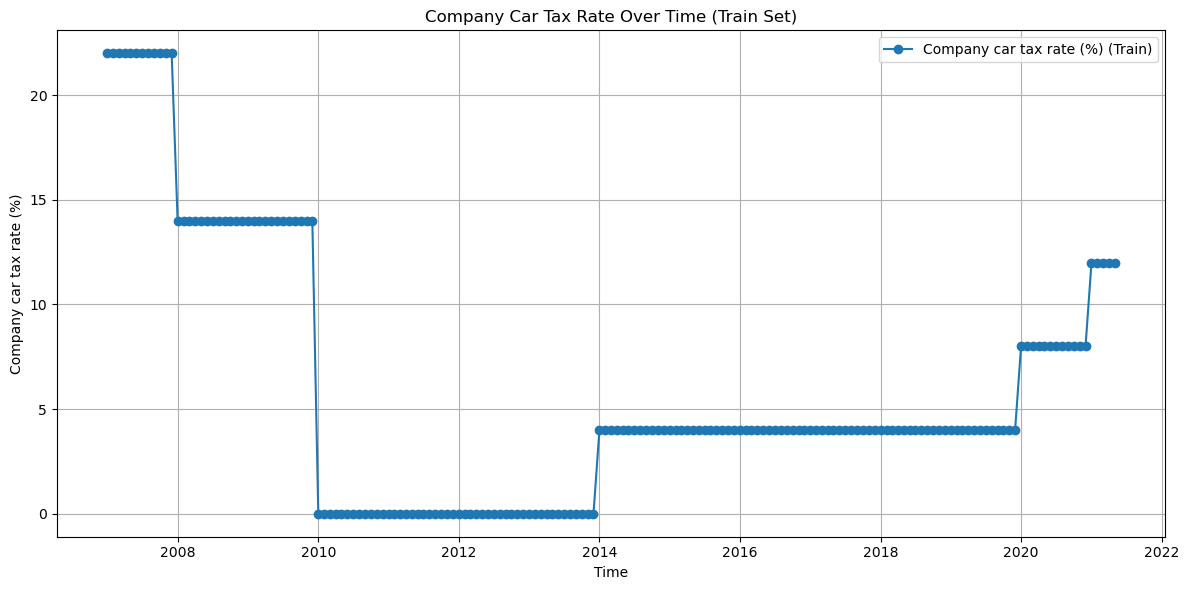

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], train["Company car tax rate (%)"], marker='o', label="Company car tax rate (%) (Train)")
plt.xlabel("Time")
plt.ylabel("Company car tax rate (%)")
plt.title("Company Car Tax Rate Over Time (Train Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

I see hardly any varience in the data, so i will apply a box cox transformation to the data.

because some of thre values are 0, i will add a constant of 1 to the data before applying the box cox transformation.

Box-Cox lambda (train, after +1 shift): 0.1486


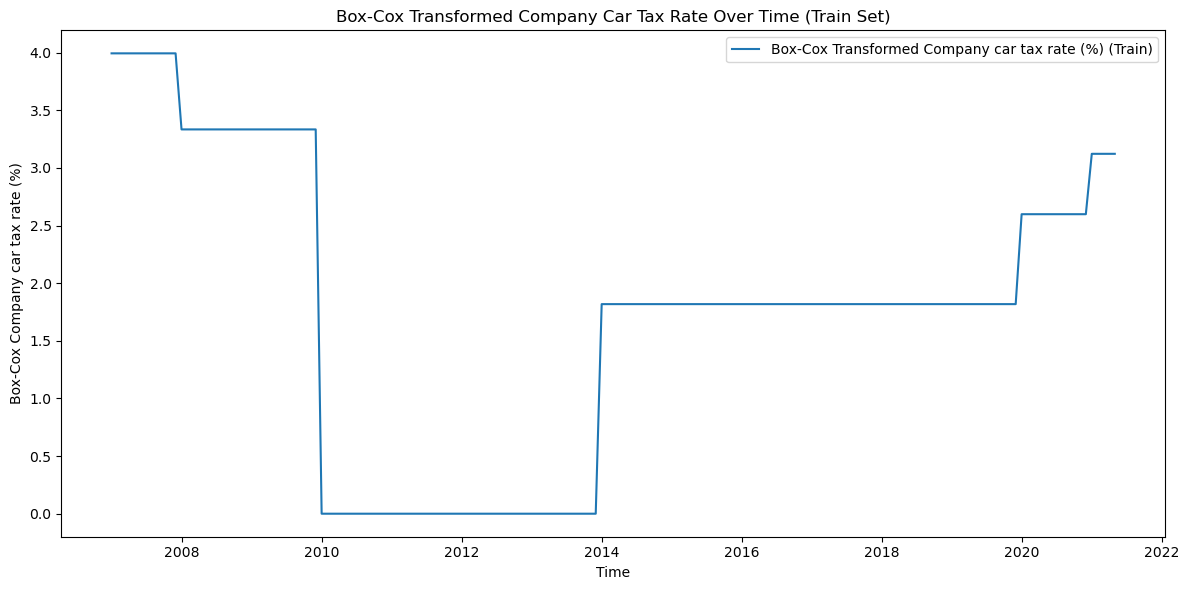

  Time Period (T)  Company car tax rate (%)  BoxCox Company car tax rate (%)
0      2007-01-01                        22                         3.993659
1      2007-02-01                        22                         3.993659
2      2007-03-01                        22                         3.993659
3      2007-04-01                        22                         3.993659
4      2007-05-01                        22                         3.993659


In [15]:
tax_col = "Company car tax rate (%)"
tax_values_train = train[tax_col].values

# Add a small shift to make all values strictly positive
tax_values_train_shifted = tax_values_train + 1

# Apply Box-Cox on train
tax_boxcox, tax_lambda = boxcox(tax_values_train_shifted)

# Save transformed values to train DataFrame
train['BoxCox ' + tax_col] = tax_boxcox

print(f"Box-Cox lambda (train, after +1 shift): {tax_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], tax_boxcox, label="Box-Cox Transformed Company car tax rate (%) (Train)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Company car tax rate (%)")
plt.title("Box-Cox Transformed Company Car Tax Rate Over Time (Train Set)")
plt.legend()
plt.tight_layout()
plt.show()
# ✅ Apply same Box-Cox lambda (trained on train) to full df (after +1 shift)
df["BoxCox " + tax_col] = boxcox(df[tax_col] + 1, lmbda=tax_lambda)

# Optional check: first few values
# Fix: Only print "Time Period (T)" if it's a column, otherwise use index
if "Time Period (T)" in df.columns:
	print(df[["Time Period (T)", tax_col, "BoxCox " + tax_col]].head())
else:
	# "Time Period (T)" is the index
	print(df[[tax_col, "BoxCox " + tax_col]].head())


Doesnt seem like the box cox transformation did much, so i will continue with checking stationarity/Differencing the data

### 2. Stationarity Check

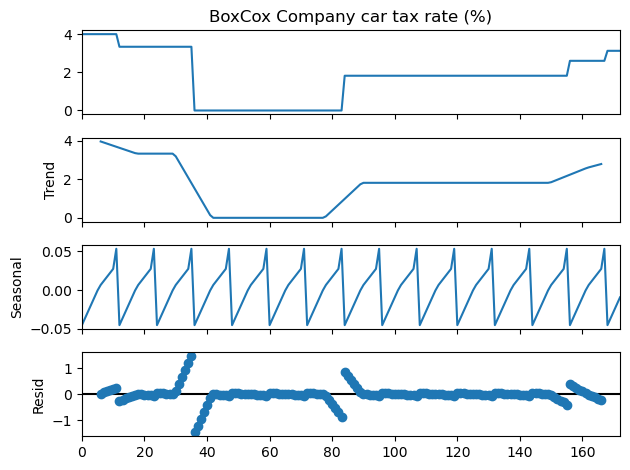

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(train["BoxCox Company car tax rate (%)"], model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()

Repetitive oscillations across the seasonal panel — clear up-and-down shape repeated every ~12 periods


In [17]:
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs

# Use BoxCox-transformed company car tax rate from train set
y_tax = train['BoxCox Company car tax rate (%)']

# Augmented Dickey-Fuller test
adf_result_tax = adfuller(y_tax)
print("ADF Statistic: {:.4f}".format(adf_result_tax[0]))
print("ADF p-value: {:.4f}".format(adf_result_tax[1]))
for key, value in adf_result_tax[4].items():
    print(f"ADF Critical Value ({key}): {value:.4f}")
if adf_result_tax[1] < 0.05:
    print("ADF: The series is likely stationary (reject H0).")
else:
    print("ADF: The series is likely non-stationary (fail to reject H0).")

# KPSS test
kpss_result_tax = kpss(y_tax, regression='c', nlags="auto")
print("\nKPSS Statistic: {:.4f}".format(kpss_result_tax[0]))
print("KPSS p-value: {:.4f}".format(kpss_result_tax[1]))
for key, value in kpss_result_tax[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")
if kpss_result_tax[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")



ADF Statistic: -1.8590
ADF p-value: 0.3516
ADF Critical Value (1%): -3.4690
ADF Critical Value (5%): -2.8785
ADF Critical Value (10%): -2.5758
ADF: The series is likely non-stationary (fail to reject H0).

KPSS Statistic: 0.3410
KPSS p-value: 0.1000
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_24668\3189218543.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_tax = kpss(y_tax, regression='c', nlags="auto")


Looking at the adf results we can see that the p-value is 0.4692, which is much higher than the 0.05 threshold, meaning we fail to reject the null hypothesis of a unit root, indicating that the series is non-stationary.
we will continue with applying a first difference to the data to remove the trend, and then re-evaluate stationarity using the ADF test again.

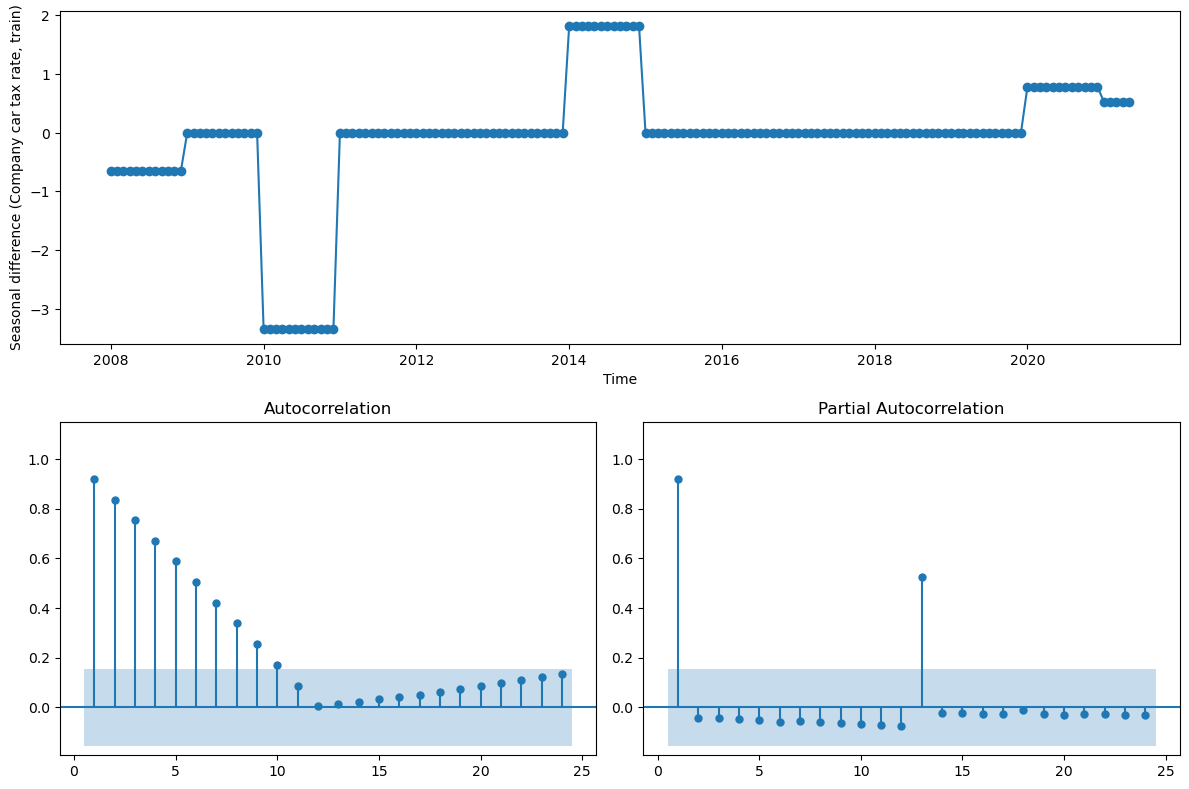

ADF Statistic (seasonal differenced, tax): -1.6611
p-value: 0.4513
Critical Value (1%): -3.4753
Critical Value (5%): -2.8813
Critical Value (10%): -2.5773
The series is likely non-stationary (fail to reject H0).

KPSS Statistic (seasonal differenced, tax): 0.5174
KPSS p-value: 0.0377
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).


In [18]:
# Calculate 12-lag (seasonal) difference of the Box-Cox transformed tax rate on the train set
seasonal_diff_tax = train["BoxCox Company car tax rate (%)"].diff(12).dropna()

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(train["Time Period (T)"].iloc[12:], seasonal_diff_tax, marker="o")
ax1.set_ylabel("Seasonal difference (Company car tax rate, train)")
ax1.set_xlabel("Time")

plot_acf(seasonal_diff_tax, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff_tax, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# Perform Augmented Dickey-Fuller test on the seasonal differenced tax data
adf_result_tax_diff = adfuller(seasonal_diff_tax)
print("ADF Statistic (seasonal differenced, tax): {:.4f}".format(adf_result_tax_diff[0]))
print("p-value: {:.4f}".format(adf_result_tax_diff[1]))
for key, value in adf_result_tax_diff[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_tax_diff[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

# Perform KPSS test on the seasonal differenced tax data
kpss_result_tax_diff = kpss(seasonal_diff_tax, regression='c', nlags="auto")
print("\nKPSS Statistic (seasonal differenced, tax): {:.4f}".format(kpss_result_tax_diff[0]))
print("KPSS p-value: {:.4f}".format(kpss_result_tax_diff[1]))
for key, value in kpss_result_tax_diff[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")

if kpss_result_tax_diff[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

Add First-Order Differencing
You're now seeing a textbook case where:

There is some seasonality, and

The trend is not yet removed with seasonal differencing alone.

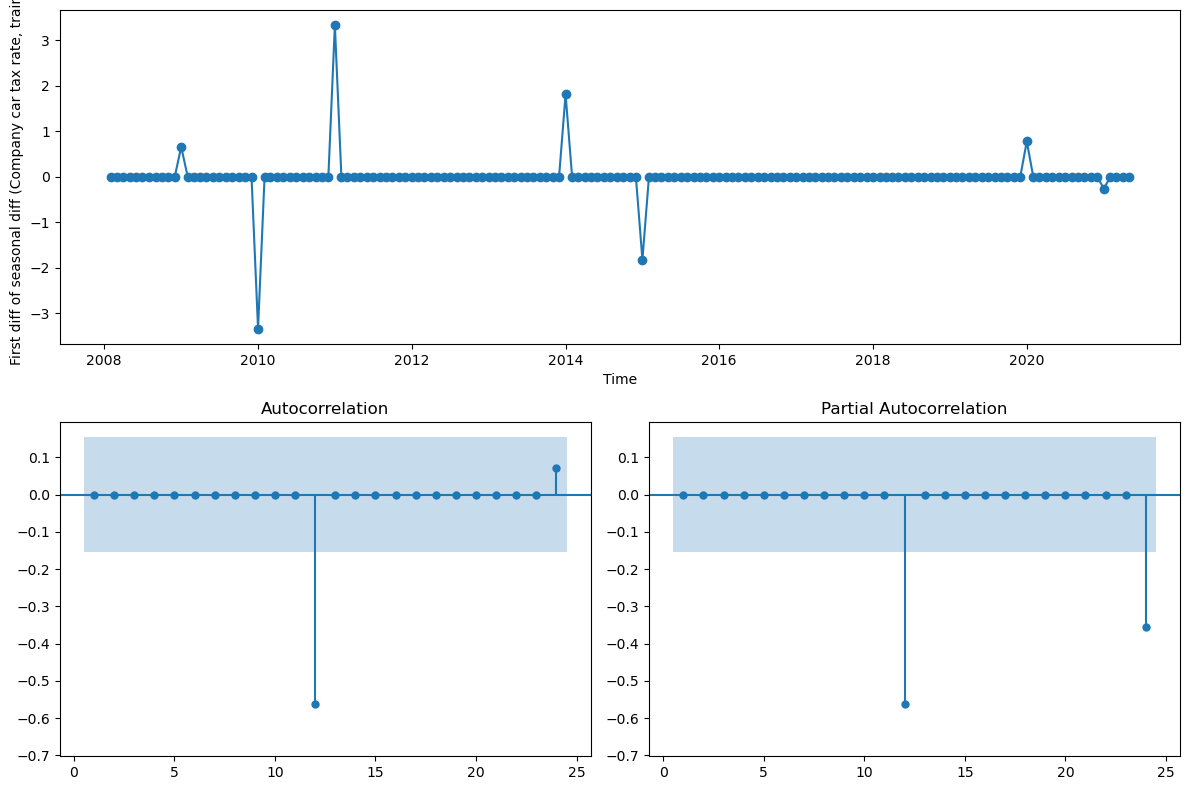

ADF Statistic (seasonal + first diff, tax): -6.4084
p-value: 0.0000
Critical Value (1%): -3.4753
Critical Value (5%): -2.8813
Critical Value (10%): -2.5773
The series is likely stationary (reject H0).

KPSS Statistic (seasonal + first diff, tax): 0.0322
KPSS p-value: 0.1000
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_24668\899038272.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_tax_diff2 = kpss(first_diff_seasonal_diff_tax, regression='c', nlags="auto")


In [19]:
# Calculate first-order difference of the seasonal differenced Box-Cox transformed tax rate
first_diff_seasonal_diff_tax = seasonal_diff_tax.diff().dropna()

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(train["Time Period (T)"].iloc[13:], first_diff_seasonal_diff_tax, marker="o")
ax1.set_ylabel("First diff of seasonal diff (Company car tax rate, train)")
ax1.set_xlabel("Time")

plot_acf(first_diff_seasonal_diff_tax, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(first_diff_seasonal_diff_tax, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# Perform Augmented Dickey-Fuller test on the first-order differenced seasonal tax data
adf_result_tax_diff2 = adfuller(first_diff_seasonal_diff_tax)
print("ADF Statistic (seasonal + first diff, tax): {:.4f}".format(adf_result_tax_diff2[0]))
print("p-value: {:.4f}".format(adf_result_tax_diff2[1]))
for key, value in adf_result_tax_diff2[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_tax_diff2[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

# Perform KPSS test on the first-order differenced seasonal tax data
kpss_result_tax_diff2 = kpss(first_diff_seasonal_diff_tax, regression='c', nlags="auto")
print("\nKPSS Statistic (seasonal + first diff, tax): {:.4f}".format(kpss_result_tax_diff2[0]))
print("KPSS p-value: {:.4f}".format(kpss_result_tax_diff2[1]))
for key, value in kpss_result_tax_diff2[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")

if kpss_result_tax_diff2[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

> ACF plot: Slowly decaying autocorrelation across multiple lags — characteristic of a trend.

PACF: Significant spike at lag 1, then small — again suggests a non-stationary trend remains.

after first order differencing the data, we can see that the p-value is still above the 0.05 threshold, i will apply a second order difference to the data to see if that helps with the stationarity of the data.

Now the tax data looks stationary, DAF Statistic = -7.57 is well below all critical values (1%, 5%, 10% thresholds).
p value of 0 is also well below the 0.05 threshold, meaning we can reject the null hypothesis of a unit root, indicating that the series is stationary.


### 4. Fit SARIMA model on the training set

looking at pacf plot the max lag we should test is 25

In [20]:
# Settings
max_lag = 6  # How many lags you'd like to test

# Use BoxCox-transformed tax rate from train set
tax_train = train['BoxCox Company car tax rate (%)']

# Use BoxCox-transformed target from train set
target_series = train['BoxCox vehicles sold (Target)']

# Ensure both are indexed by datetime and have freq set
if not isinstance(tax_train.index, pd.DatetimeIndex):
    tax_train.index = train['Time Period (T)']
if tax_train.index.freq is None:
    tax_train.index = tax_train.index.to_period("M").to_timestamp()

if not isinstance(target_series.index, pd.DatetimeIndex):
    target_series.index = train['Time Period (T)']
if target_series.index.freq is None:
    target_series.index = target_series.index.to_period("M").to_timestamp()

# Store results
lag_results = []

for lag in range(0, max_lag + 1):
    # Create lagged exogenous variable
    if lag == 0:
        exog = tax_train.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = tax_train.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    # Ensure both have DatetimeIndex and freq set
    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()  # Set freq to monthly
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    # Fit SARIMAX
    model = SARIMAX(
        model_target,
        exog=exog,
        order=(1, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    # Log metrics
    exog_pval = results.pvalues.iloc[-1]
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": exog_pval,
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n Lag Comparison Summary:")
print(lag_df)


 Lag Comparison Summary:
    Lag       AIC        BIC  Coefficient p-value  Log Likelihood
4  lag4 -6.193429   8.620794         9.460545e-26        8.096715
3  lag3 -5.426443   9.422623         1.667766e-25        7.713222
2  lag2 -5.419567   9.464101         2.197244e-25        7.709784
1  lag1 -5.082767   9.835266         1.067648e-24        7.541384
0  lag0 -4.279827  10.672336         6.629330e-24        7.139914
5  lag5 -3.752853  11.026282         6.394118e-25        6.876427
6  lag6 -3.550141  11.193659         7.738474e-25        6.775070


lag 4 came best out of the box, so i will use that as a seasonal lag

In [21]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ✅ Ensure datetime index on train_expanded
train_expanded["Time Period (T)"] = pd.to_datetime(train_expanded["Time Period (T)"])
train_expanded = train_expanded.set_index("Time Period (T)")


# ✅ Attach BoxCox Company car tax rate column using timestamp alignment
if "BoxCox Company car tax rate (%)" not in train_expanded.columns:
    train_expanded["BoxCox Company car tax rate (%)"] = df.set_index("Time Period (T)").loc[
        train_expanded.index, "BoxCox Company car tax rate (%)"
    ]

# ✅ Create lagged exogenous feature
tax_exog_lag4 = train_expanded["BoxCox Company car tax rate (%)"].shift(4)

# ✅ Create final aligned DataFrame
aligned_df = train_expanded.copy()
aligned_df["exog_tax_lag4"] = tax_exog_lag4

# ✅ Drop rows with NaNs after shifting
aligned_df = aligned_df.dropna(subset=["exog_tax_lag4", "BoxCox vehicles sold (Target)"])

# ✅ Extract target and exogenous series
target_series = aligned_df["BoxCox vehicles sold (Target)"]
exog_series = aligned_df["exog_tax_lag4"]

# ✅ Fit SARIMAX model
model = SARIMAX(
    target_series,
    exog=exog_series,
    order=(1, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

# ✅ Output model summary
print(results.summary())


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  187
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  12.306
Date:                            Mon, 28 Jul 2025   AIC                            -14.611
Time:                                    16:35:05   BIC                              0.796
Sample:                                05-01-2007   HQIC                            -8.355
                                     - 11-01-2022                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
exog_tax_lag4     0.0536      0.085      0.632      0.527      -0.113       0.220
ar.L1             0.9709  

Lag 4 of Company car tax rate (%) doesn't seem predictive (yet) — p-value > 0.5

### 5. evaluate model

Validation RMSE (BoxCox): 0.4068
Validation MAPE (BoxCox): 2.65%
Validation RMSE (Back-transformed): 8394.98
Validation MAPE (Back-transformed): 27.87%


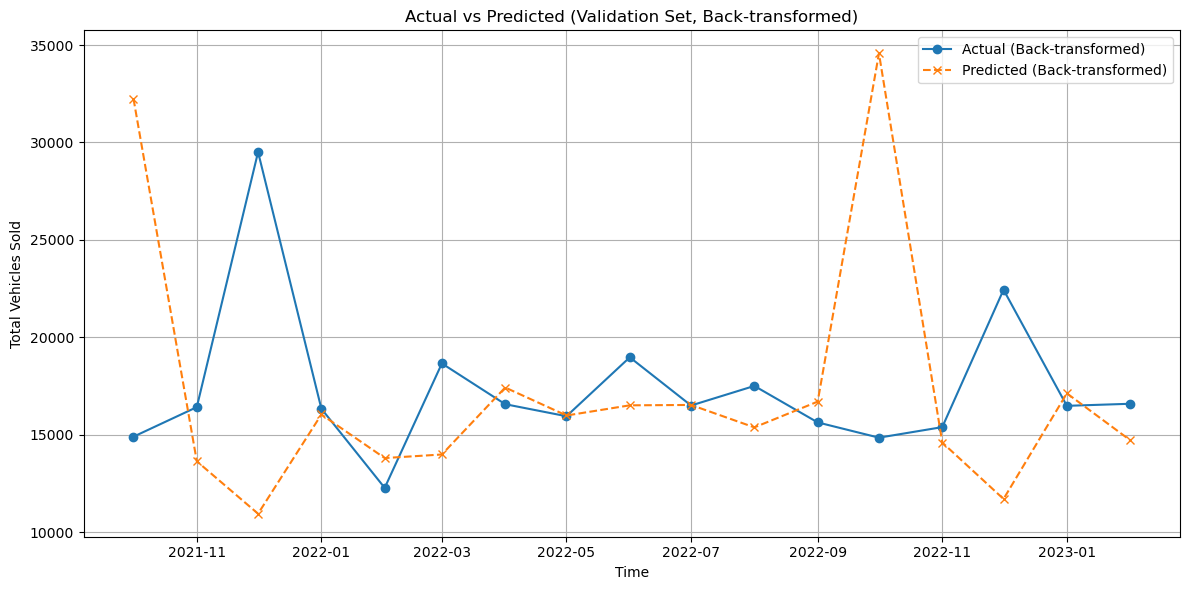

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.special import inv_boxcox

# --- Prepare validation exogenous variable (lag 4) ---
# Ensure df is indexed by "Time Period (T)" for alignment
if df.index.name != "Time Period (T)":
    df_indexed = df.set_index("Time Period (T)")
else:
    df_indexed = df

val = val.copy()
if val.index.name != "Time Period (T)":
    val = val.set_index("Time Period (T)")

val["BoxCox Company car tax rate (%)"] = df_indexed.loc[val.index, "BoxCox Company car tax rate (%)"]
val["exog_tax_lag4"] = val["BoxCox Company car tax rate (%)"].shift(4)

# Only keep rows where exog_tax_lag4 is not NaN
val_valid = val.dropna(subset=["exog_tax_lag4"]).copy()

# Prepare exogenous and target arrays for forecasting
exog_val_lag4 = val_valid["exog_tax_lag4"].values
actuals_bc = val_valid["BoxCox vehicles sold (Target)"].values
val_index = val_valid.index

# --- Forecast on validation set ---
n_val = len(val_valid)
forecast = results.get_forecast(steps=n_val, exog=exog_val_lag4)
preds_bc = forecast.predicted_mean
conf_int = forecast.conf_int()

# --- Evaluate performance ---
rmse_bc = np.sqrt(mean_squared_error(actuals_bc, preds_bc))
mape_bc = mean_absolute_percentage_error(actuals_bc, preds_bc) * 100

print(f"Validation RMSE (BoxCox): {rmse_bc:.4f}")
print(f"Validation MAPE (BoxCox): {mape_bc:.2f}%")

# --- Back-transform predictions and actuals ---
fitted_lambda = results.model.endog_transform._lambda if hasattr(results.model, "endog_transform") else None
if fitted_lambda is None:
    # fallback: use the lambda from your BoxCox transform, e.g. fitted_lambda_train
    fitted_lambda = fitted_lambda_train

preds_back = inv_boxcox(preds_bc, fitted_lambda)
actuals_back = inv_boxcox(actuals_bc, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"Validation RMSE (Back-transformed): {rmse_back:.2f}")
print(f"Validation MAPE (Back-transformed): {mape_back:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(val_index, actuals_back, label="Actual (Back-transformed)", marker="o")
plt.plot(val_index, preds_back, label="Predicted (Back-transformed)", marker="x", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Total Vehicles Sold")
plt.title("Actual vs Predicted (Validation Set, Back-transformed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
#


##### SARIMAX Model with Lagged Tax Rate (L12)

**Model Specification:**  
- SARIMAX(2,0,1)(0,1,1)[12]  
- Exogenous Regressor: `CompanyCarTaxRate_bc_diff12_diff1_seasonal` (Lag 12)  
- Target Variable: BoxCox-transformed EV Sales  
- BoxCox Lambda: λ = *[your fitted lambda]*

---

#####  In-sample Summary
- **AIC:** -4.396  
- **BIC:** 12.574  
- **Log Likelihood:** 8.198  
- **Coefficient Significance:**
  - `CompanyCarTaxRate_L12`: borderline (p = 0.053)
  - `ar.L1`: significant (p < 0.001)
  - `ar.L2`: significant (p = 0.035)
  - `ma.L1`, `ma.S.L12`: significant  
- **Ljung-Box Test (p = 0.94):** residuals resemble white noise  
- **Jarque-Bera Test (p = 0.00):** ✗ residuals not normally distributed  
- **Heteroskedasticity Test (p = 0.16):** no strong evidence of heteroskedasticity  

---

######  Validation Performance
- **RMSE (BoxCox):** 0.3857  
- **MAPE (BoxCox):** 2.82%  
- **RMSE (Back-transformed):** 13,033.54  
- **MAPE (Back-transformed):** 37.96%  
- Forecast captures seasonal structure but underperforms compared to baseline  
- Errors increase during high-variance periods

---

######  Notes
- Adding the lagged tax rate introduces a weak signal  
- Slightly better fit in-sample (higher Log Likelihood)  
- Out-of-sample performance worsens, indicating **possible overfitting**  





 Home charging (G)', 'Electric car (G)', 'Hybrid electric (G) 

 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform
2. Stationarity Check --> ADF + diferencing if needed
3. split data
4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time: 
    Review:

###  1. Data Cleaning & Transformation Hybrid electric (G)


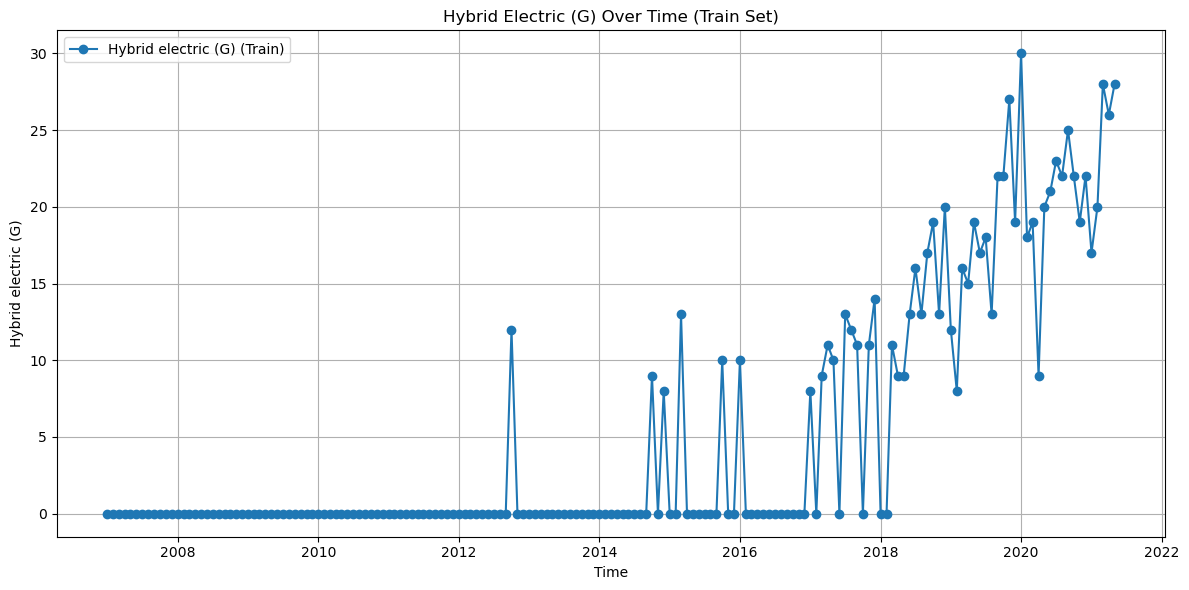

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], train["Hybrid electric (G)"], marker='o', label="Hybrid electric (G) (Train)")
plt.xlabel("Time")
plt.ylabel("Hybrid electric (G)")
plt.title("Hybrid Electric (G) Over Time (Train Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Box-Cox lambda for 'Hybrid electric (G)' (train): -0.8855


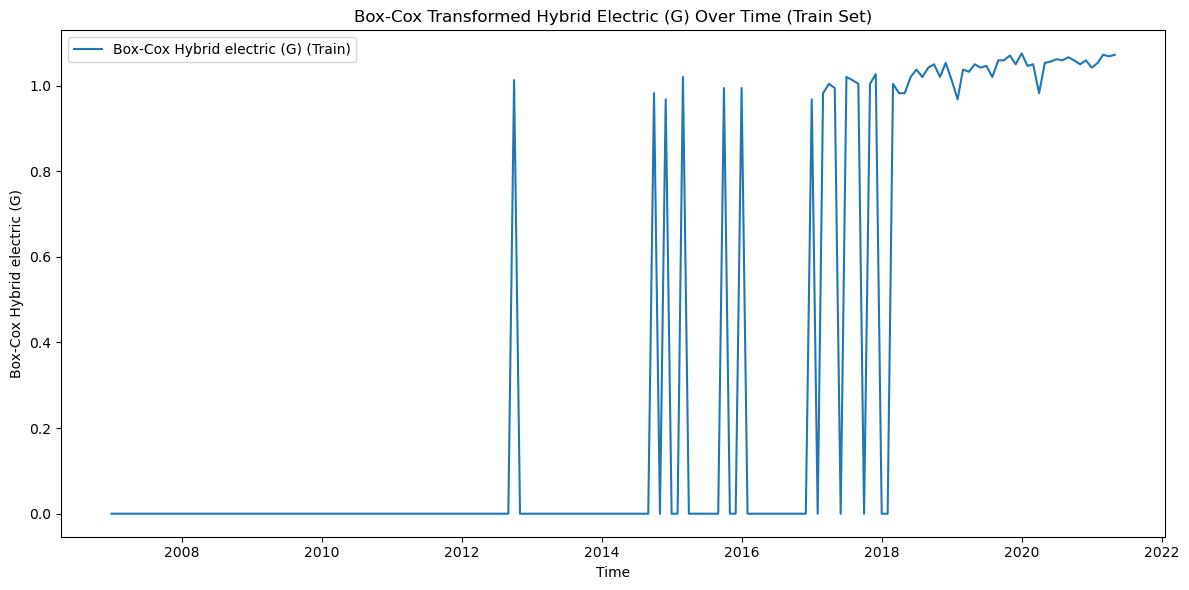

In [23]:
# Box-Cox transform for 'Hybrid electric (G)' on train set only
hybrid_col = "Hybrid electric (G)"
hybrid_values_train = train[hybrid_col].values

# Box-Cox requires strictly positive values, so add a small constant if needed
if (hybrid_values_train <= 0).any():
    hybrid_values_train_shifted = hybrid_values_train + 1
else:
    hybrid_values_train_shifted = hybrid_values_train

hybrid_boxcox_train, hybrid_lambda_train = boxcox(hybrid_values_train_shifted)

# Save transformed values to the train DataFrame
train['BoxCox ' + hybrid_col] = hybrid_boxcox_train

print(f"Box-Cox lambda for '{hybrid_col}' (train): {hybrid_lambda_train:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], hybrid_boxcox_train, label="Box-Cox Hybrid electric (G) (Train)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Hybrid electric (G)")
plt.title("Box-Cox Transformed Hybrid Electric (G) Over Time (Train Set)")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

nPerform Augmented Dickey-Fuller test on Box-Cox trasformed x

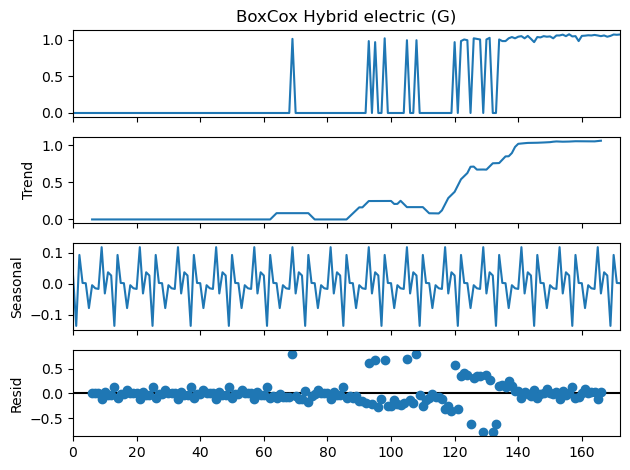

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(train["BoxCox Hybrid electric (G)"], model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()

In [25]:
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs

# Use BoxCox-transformed Hybrid electric (G) from train set
y_hybrid = train['BoxCox Hybrid electric (G)']

# Augmented Dickey-Fuller test
adf_result_hybrid = adfuller(y_hybrid)
print("ADF Statistic: {:.4f}".format(adf_result_hybrid[0]))
print("ADF p-value: {:.4f}".format(adf_result_hybrid[1]))
for key, value in adf_result_hybrid[4].items():
    print(f"ADF Critical Value ({key}): {value:.4f}")
if adf_result_hybrid[1] < 0.05:
    print("ADF: The series is likely stationary (reject H0).")
else:
    print("ADF: The series is likely non-stationary (fail to reject H0).")

# KPSS test
kpss_result_hybrid = kpss(y_hybrid, regression='c', nlags="auto")
print("\nKPSS Statistic: {:.4f}".format(kpss_result_hybrid[0]))
print("KPSS p-value: {:.4f}".format(kpss_result_hybrid[1]))
for key, value in kpss_result_hybrid[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")
if kpss_result_hybrid[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

ADF Statistic: 0.0373
ADF p-value: 0.9615
ADF Critical Value (1%): -3.4716
ADF Critical Value (5%): -2.8797
ADF Critical Value (10%): -2.5764
ADF: The series is likely non-stationary (fail to reject H0).

KPSS Statistic: 1.5932
KPSS p-value: 0.0100
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_20164\1962541804.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result_hybrid = kpss(y_hybrid, regression='c', nlags="auto")


Seasonal differencing (lag=12): removes the yearly cycle.

First-order differencing (lag=1): removes trend (apply after seasonal if needed).

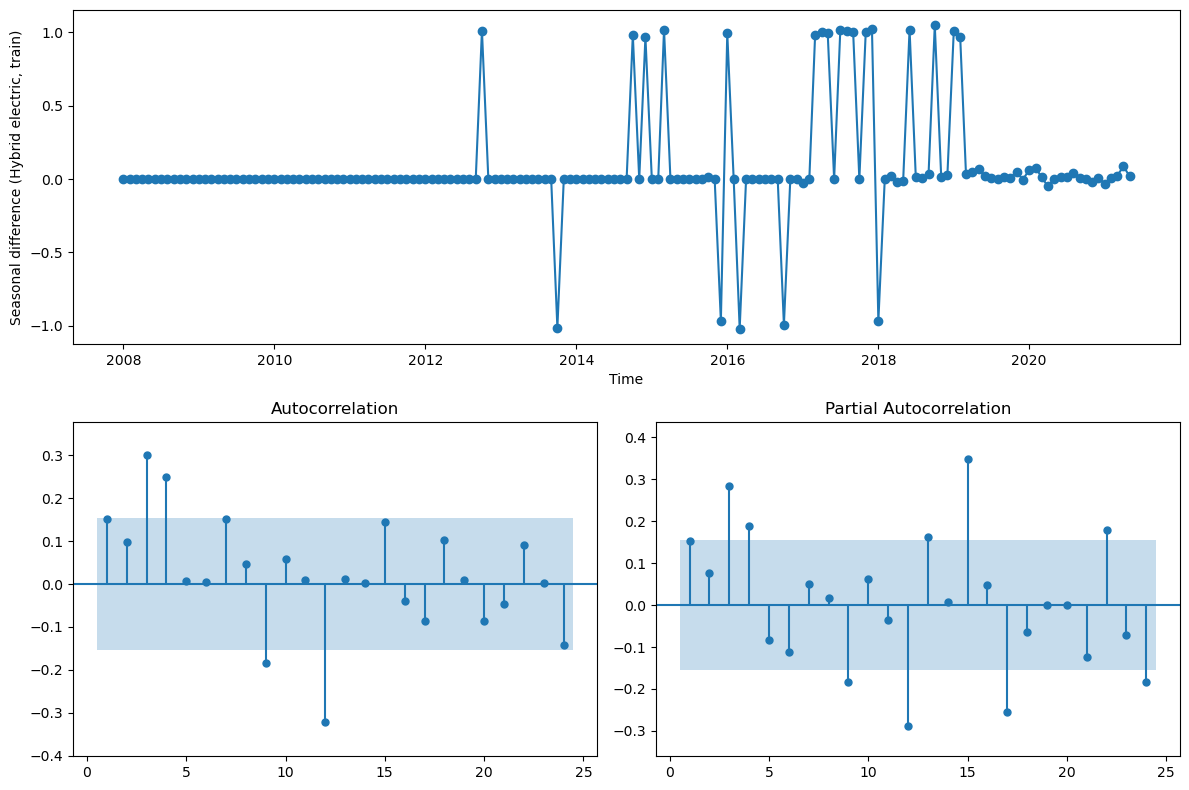

ADF Statistic (seasonal differenced, hybrid): -2.1841
p-value: 0.2121
Critical Value (1%): -3.4760
Critical Value (5%): -2.8815
Critical Value (10%): -2.5774
The series is likely non-stationary (fail to reject H0).

KPSS Statistic (seasonal differenced, hybrid): 0.3203
KPSS p-value: 0.1000
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_20164\2829273640.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_hybrid_diff = kpss(seasonal_diff_hybrid, regression='c', nlags="auto")


In [26]:
# Calculate 12-lag (seasonal) difference of the Box-Cox transformed Hybrid electric (G) on the train set
seasonal_diff_hybrid = train["BoxCox Hybrid electric (G)"].diff(12).dropna()

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(train["Time Period (T)"].iloc[12:], seasonal_diff_hybrid, marker="o")
ax1.set_ylabel("Seasonal difference (Hybrid electric, train)")
ax1.set_xlabel("Time")

plot_acf(seasonal_diff_hybrid, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff_hybrid, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# Perform Augmented Dickey-Fuller test on the seasonal differenced hybrid data
adf_result_hybrid_diff = adfuller(seasonal_diff_hybrid)
print("ADF Statistic (seasonal differenced, hybrid): {:.4f}".format(adf_result_hybrid_diff[0]))
print("p-value: {:.4f}".format(adf_result_hybrid_diff[1]))
for key, value in adf_result_hybrid_diff[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_hybrid_diff[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

# Perform KPSS test on the seasonal differenced hybrid data
kpss_result_hybrid_diff = kpss(seasonal_diff_hybrid, regression='c', nlags="auto")
print("\nKPSS Statistic (seasonal differenced, hybrid): {:.4f}".format(kpss_result_hybrid_diff[0]))
print("KPSS p-value: {:.4f}".format(kpss_result_hybrid_diff[1]))
for key, value in kpss_result_hybrid_diff[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")

if kpss_result_hybrid_diff[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

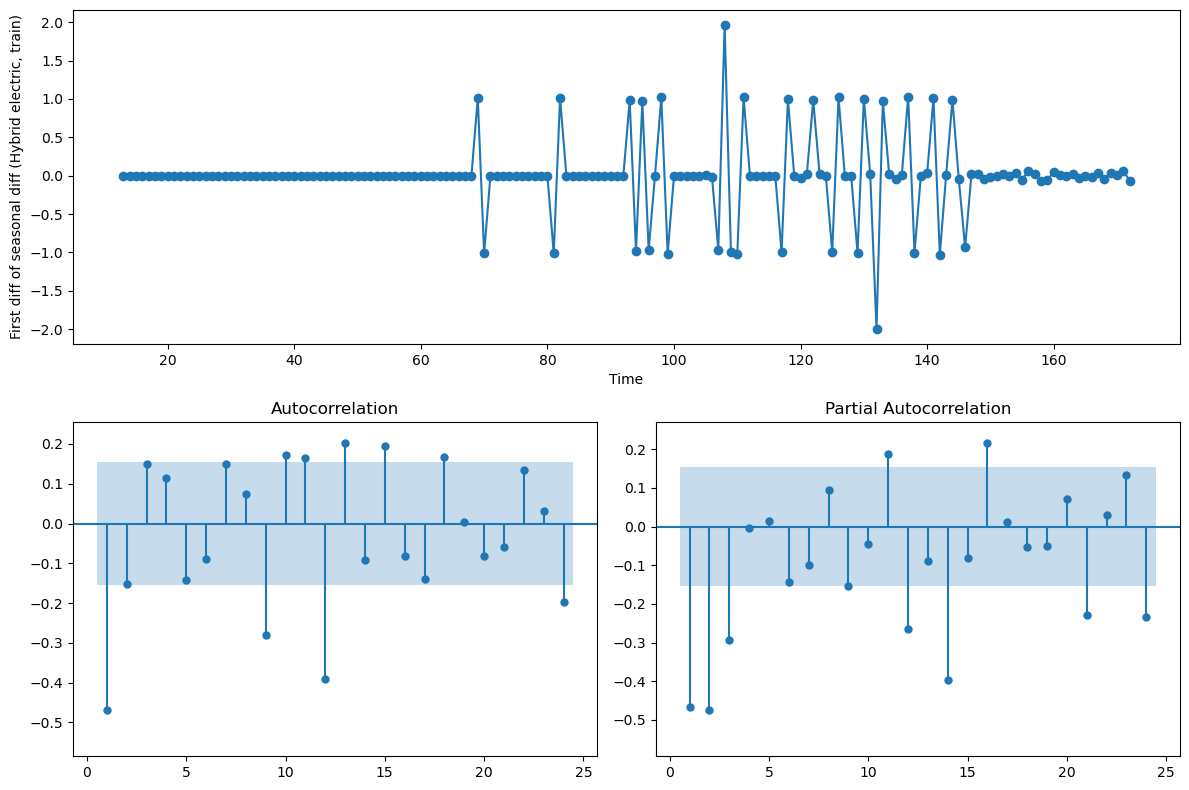

ADF Statistic (seasonal + first diff, hybrid): -6.7990
p-value: 0.0000
Critical Value (1%): -3.4760
Critical Value (5%): -2.8815
Critical Value (10%): -2.5774
The series is likely stationary (reject H0).

KPSS Statistic (seasonal + first diff, hybrid): 0.0997
KPSS p-value: 0.1000
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_20164\154170899.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_hybrid_diff2 = kpss(first_diff_seasonal_diff_hybrid, regression='c', nlags="auto")


In [27]:
# Calculate first-order difference of the seasonal differenced Box-Cox transformed Hybrid electric (G)
first_diff_seasonal_diff_hybrid = seasonal_diff_hybrid.diff().dropna()

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(seasonal_diff_hybrid.index[1:], first_diff_seasonal_diff_hybrid, marker="o")
ax1.set_ylabel("First diff of seasonal diff (Hybrid electric, train)")
ax1.set_xlabel("Time")

plot_acf(first_diff_seasonal_diff_hybrid, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(first_diff_seasonal_diff_hybrid, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# Perform Augmented Dickey-Fuller test on the first-order differenced seasonal hybrid data
adf_result_hybrid_diff2 = adfuller(first_diff_seasonal_diff_hybrid)
print("ADF Statistic (seasonal + first diff, hybrid): {:.4f}".format(adf_result_hybrid_diff2[0]))
print("p-value: {:.4f}".format(adf_result_hybrid_diff2[1]))
for key, value in adf_result_hybrid_diff2[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_hybrid_diff2[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

# Perform KPSS test on the first-order differenced seasonal hybrid data
kpss_result_hybrid_diff2 = kpss(first_diff_seasonal_diff_hybrid, regression='c', nlags="auto")
print("\nKPSS Statistic (seasonal + first diff, hybrid): {:.4f}".format(kpss_result_hybrid_diff2[0]))
print("KPSS p-value: {:.4f}".format(kpss_result_hybrid_diff2[1]))
for key, value in kpss_result_hybrid_diff2[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")

if kpss_result_hybrid_diff2[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

since not stationary will perform second ord


Signal from Chart	Interpretation	Action
No PACF spike at Lag 1–3	Weak self-dependence → no clear delayed behavior	Try lag 0 first (instantaneous effect)
Flat beyond Lag 3	Higher lags likely uninformative	No need to push lag testing beyond ~3
No seasonal spikes	No strong seasonality inside this predictor	Skip seasonal lags (e.g., 12, 24)

### 4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time:

In [28]:
# Compute first_diff_seasonal_diff_hybrid if not already defined
seasonal_diff_hybrid = train["BoxCox Hybrid electric (G)"].diff(12).dropna()
first_diff_seasonal_diff_hybrid = seasonal_diff_hybrid.diff().dropna()

# Test optimal lag for first_diff_seasonal_diff_hybrid as exogenous regressor

max_lag = 6  # Number of lags to test

# Ensure exog_series has datetime index matching train
exog_series = first_diff_seasonal_diff_hybrid.copy()
if not isinstance(exog_series.index, pd.DatetimeIndex):
    exog_series.index = train["Time Period (T)"].iloc[exog_series.index]

# Target series with datetime index
target_series = train.set_index("Time Period (T)")['BoxCox vehicles sold (Target)']

lag_results = []

for lag in range(0, max_lag + 1):
    if lag == 0:
        exog = exog_series.copy()
        label = "lag0"
    else:
        exog = exog_series.shift(lag)
        label = f"lag{lag}"

    # Align target and exog by intersection of their datetime indices (drop NaNs)
    valid_idx = exog.dropna().index.intersection(target_series.index)
    exog_valid = exog.loc[valid_idx]
    target_valid = target_series.loc[valid_idx]

    # Fit SARIMAX
    model = SARIMAX(
        target_valid,
        exog=exog_valid,
        order=(1, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)
    exog_pval = results.pvalues.iloc[-1]
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": exog_pval,
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\nLag Comparison Summary:")
print(lag_df)

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  


Lag Comparison Summary:
    Lag       AIC        BIC  Coefficient p-value  Log Likelihood
0  lag0  3.642808  18.132007         3.524509e-22        3.178596
2  lag2  3.848654  18.262663         5.332601e-14        3.075673
1  lag1  4.037350  18.489096         2.149543e-17        2.981325
4  lag4  5.498694  19.836366         1.893067e-21        2.250653
3  lag3  5.713708  20.089695         5.834721e-21        2.143146
6  lag6  6.373789  20.633940         7.838615e-21        1.813106
5  lag5  6.892003  21.191065         3.296683e-21        1.553999


lag 0 is best 

In [29]:
from scipy.stats import boxcox

hybrid_col = "Hybrid electric (G)"
hybrid_values = train_expanded[hybrid_col].values

# Box-Cox requires strictly positive values
if (hybrid_values <= 0).any():
    hybrid_values_shifted = hybrid_values + 1
else:
    hybrid_values_shifted = hybrid_values

hybrid_boxcox, hybrid_lambda = boxcox(hybrid_values_shifted)
train_expanded["BoxCox Hybrid electric (G)"] = hybrid_boxcox

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  199
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   9.266
Date:                            Thu, 17 Jul 2025   AIC                             -8.533
Time:                                    10:28:37   BIC                              7.234
Sample:                                01-01-2008   HQIC                            -2.136
                                     - 07-01-2024                                         
Covariance Type:                              opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
exog_hybrid_seasonal_diff     0.0120      0.025      0.484      0.628      -0.037   

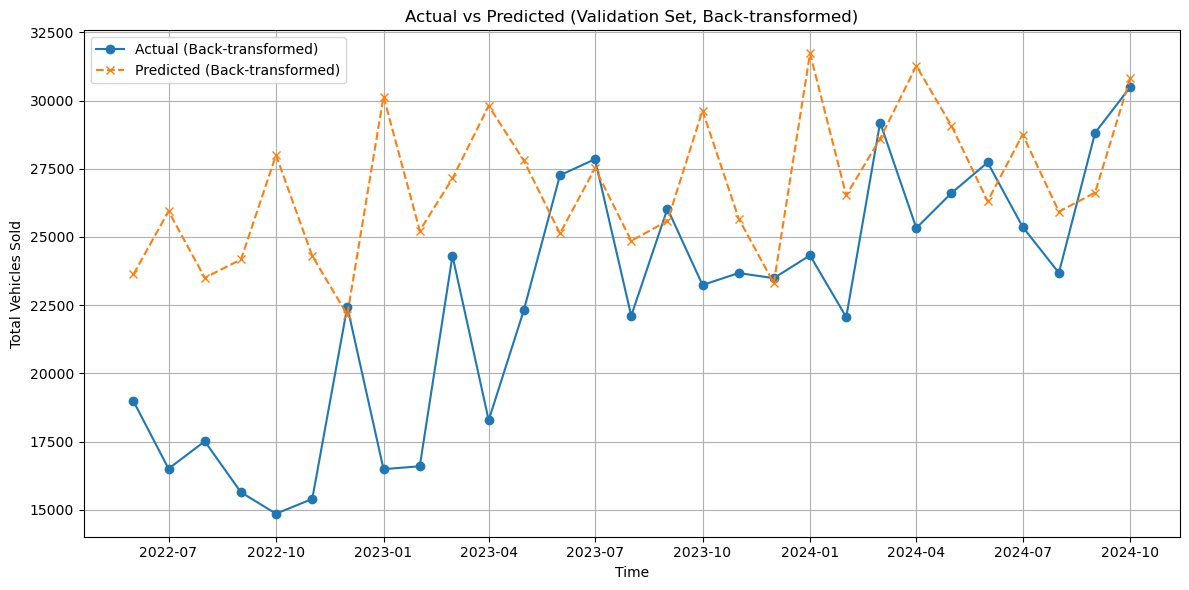

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.special import inv_boxcox



# Ensure datetime index on train_expanded
train_expanded = train_expanded.copy()
if not isinstance(train_expanded.index, pd.DatetimeIndex):
    train_expanded["Time Period (T)"] = pd.to_datetime(train_expanded["Time Period (T)"])
    train_expanded = train_expanded.set_index("Time Period (T)")

# Compute seasonal_diff_hybrid (lag 12) as exogenous variable
seasonal_diff_hybrid = train_expanded["BoxCox Hybrid electric (G)"].diff(12)

# Align target and exogenous, drop NaNs
aligned_df = train_expanded.copy()
aligned_df["exog_hybrid_seasonal_diff"] = seasonal_diff_hybrid
aligned_df = aligned_df.dropna(subset=["exog_hybrid_seasonal_diff", "BoxCox vehicles sold (Target)"])

# Extract target and exogenous series
target_series = aligned_df["BoxCox vehicles sold (Target)"]
exog_series = aligned_df["exog_hybrid_seasonal_diff"]

# Fit SARIMAX model
model = SARIMAX(
    target_series,
    exog=exog_series,
    order=(1, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

print(results.summary())


# --- Prepare validation exogenous variable (seasonal diff of hybrid) ---
# Compute BoxCox for Hybrid electric (G) in val using train's lambda
hybrid_col = "Hybrid electric (G)"
if "BoxCox Hybrid electric (G)" not in val.columns:
    hybrid_vals = val[hybrid_col].values
    # Use the lambda from train
    if (hybrid_vals <= 0).any():
        hybrid_vals_shifted = hybrid_vals + 1
    else:
        hybrid_vals_shifted = hybrid_vals
    val["BoxCox Hybrid electric (G)"] = boxcox(hybrid_vals_shifted, lmbda=hybrid_lambda)

# Compute seasonal diff (lag 12) for validation set
val = val.copy()
val["exog_hybrid_seasonal_diff"] = val["BoxCox Hybrid electric (G)"].diff(12)

# Drop rows with NaN in exog or target
val_valid = val.dropna(subset=["exog_hybrid_seasonal_diff", "BoxCox vehicles sold (Target)"]).copy()

# Prepare exogenous and target arrays for forecasting
exog_val = val_valid["exog_hybrid_seasonal_diff"].values
actuals_bc = val_valid["BoxCox vehicles sold (Target)"].values
val_index = val_valid.index

# --- Forecast on validation set ---
n_val = len(val_valid)
forecast = results.get_forecast(steps=n_val, exog=exog_val)
preds_bc = forecast.predicted_mean

# --- Evaluate performance ---
rmse_bc = np.sqrt(mean_squared_error(actuals_bc, preds_bc))
mape_bc = mean_absolute_percentage_error(actuals_bc, preds_bc) * 100

print(f"Validation RMSE (BoxCox): {rmse_bc:.4f}")
print(f"Validation MAPE (BoxCox): {mape_bc:.2f}%")

# --- Back-transform predictions and actuals ---
fitted_lambda = hybrid_lambda_train if 'hybrid_lambda_train' in locals() else hybrid_lambda
preds_back = inv_boxcox(preds_bc, fitted_lambda_train)
actuals_back = inv_boxcox(actuals_bc, fitted_lambda_train)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"Validation RMSE (Back-transformed): {rmse_back:.2f}")
print(f"Validation MAPE (Back-transformed): {mape_back:.2f}%")

# --- Plot actual vs predicted (back-transformed) ---
plt.figure(figsize=(12, 6))
plt.plot(val_index, actuals_back, label="Actual (Back-transformed)", marker="o")
plt.plot(val_index, preds_back, label="Predicted (Back-transformed)", marker="x", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Total Vehicles Sold")
plt.title("Actual vs Predicted (Validation Set, Back-transformed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###  1. Data Cleaning & Transformation  Electric car (G)
plot x
perform boxcox on x

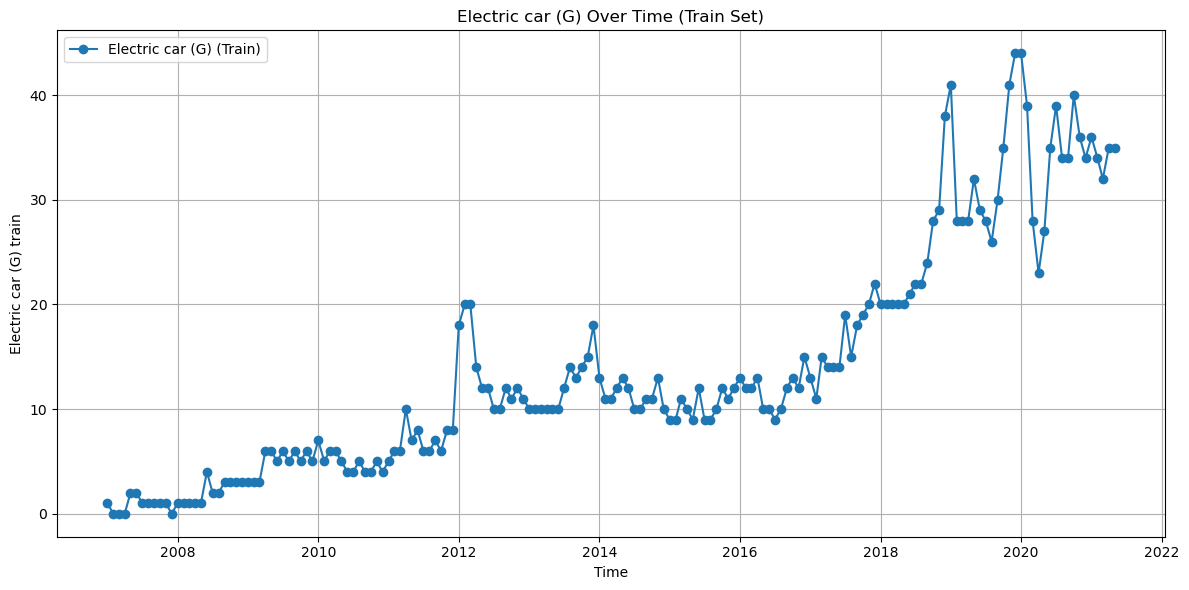

In [31]:


plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], train["Electric car (G)"], marker='o', label="Electric car (G) (Train)")
plt.xlabel("Time")
plt.ylabel("Electric car (G) train")
plt.title("Electric car (G) Over Time (Train Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Box-Cox lambda for 'Electric car (G)' (train): 0.2896


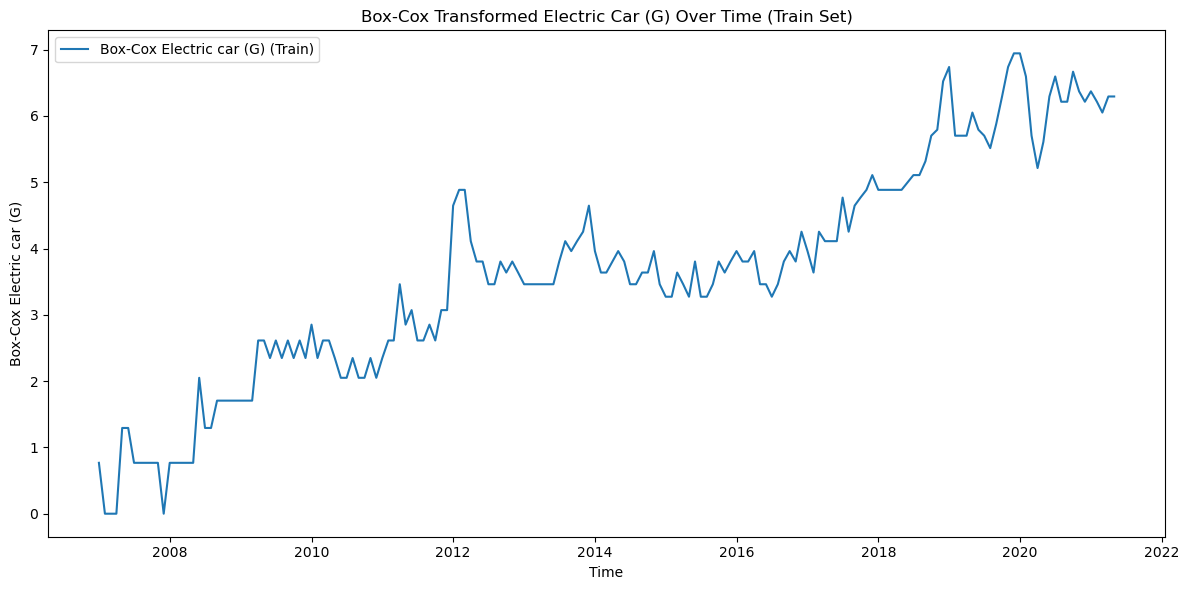

In [32]:
from scipy.stats import boxcox

# Box-Cox transform for 'Electric car (G)' on train set only
electric_col = "Electric car (G)"
electric_values_train = train[electric_col].values

# Box-Cox requires strictly positive values, so add a small constant if needed
if (electric_values_train <= 0).any():
    electric_values_train_shifted = electric_values_train + 1
else:
    electric_values_train_shifted = electric_values_train

electric_boxcox_train, electric_lambda_train = boxcox(electric_values_train_shifted)

# Save transformed values to the train DataFrame
train['BoxCox ' + electric_col] = electric_boxcox_train

print(f"Box-Cox lambda for '{electric_col}' (train): {electric_lambda_train:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train["Time Period (T)"], electric_boxcox_train, label="Box-Cox Electric car (G) (Train)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Electric car (G)")
plt.title("Box-Cox Transformed Electric Car (G) Over Time (Train Set)")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

nPerform Augmented Dickey-Fuller test on Box-Cox trasformed x

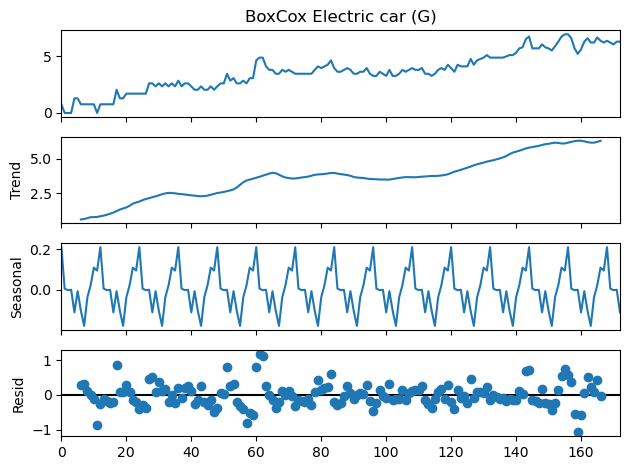

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(train["BoxCox Electric car (G)"], model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()

In [34]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF test
adf_result = adfuller(train["BoxCox Electric car (G)"])
print("ADF Statistic: {:.4f}".format(adf_result[0]))
print("ADF p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"ADF Critical Value ({key}): {value:.4f}")
if adf_result[1] < 0.05:
    print("ADF: The series is likely stationary (reject H0).")
else:
    print("ADF: The series is likely non-stationary (fail to reject H0).")

# KPSS test
kpss_result = kpss(train["BoxCox Electric car (G)"], regression='c', nlags="auto")
print("\nKPSS Statistic: {:.4f}".format(kpss_result[0]))
print("KPSS p-value: {:.4f}".format(kpss_result[1]))
for key, value in kpss_result[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")
if kpss_result[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

ADF Statistic: -1.0463
ADF p-value: 0.7360
ADF Critical Value (1%): -3.4704
ADF Critical Value (5%): -2.8791
ADF Critical Value (10%): -2.5761
ADF: The series is likely non-stationary (fail to reject H0).

KPSS Statistic: 1.8001
KPSS p-value: 0.0100
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_20164\1309692630.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train["BoxCox Electric car (G)"], regression='c', nlags="auto")


> Trend: Strong upward trend visible in plot.

Seasonality: Clear seasonal cycle (monthly).

ADF: p = 0.736 → fail to reject H₀ → non-stationary.

KPSS: p = 0.01 → reject H₀ → non-stationary.

 Both tests agree: the series is non-stationary.

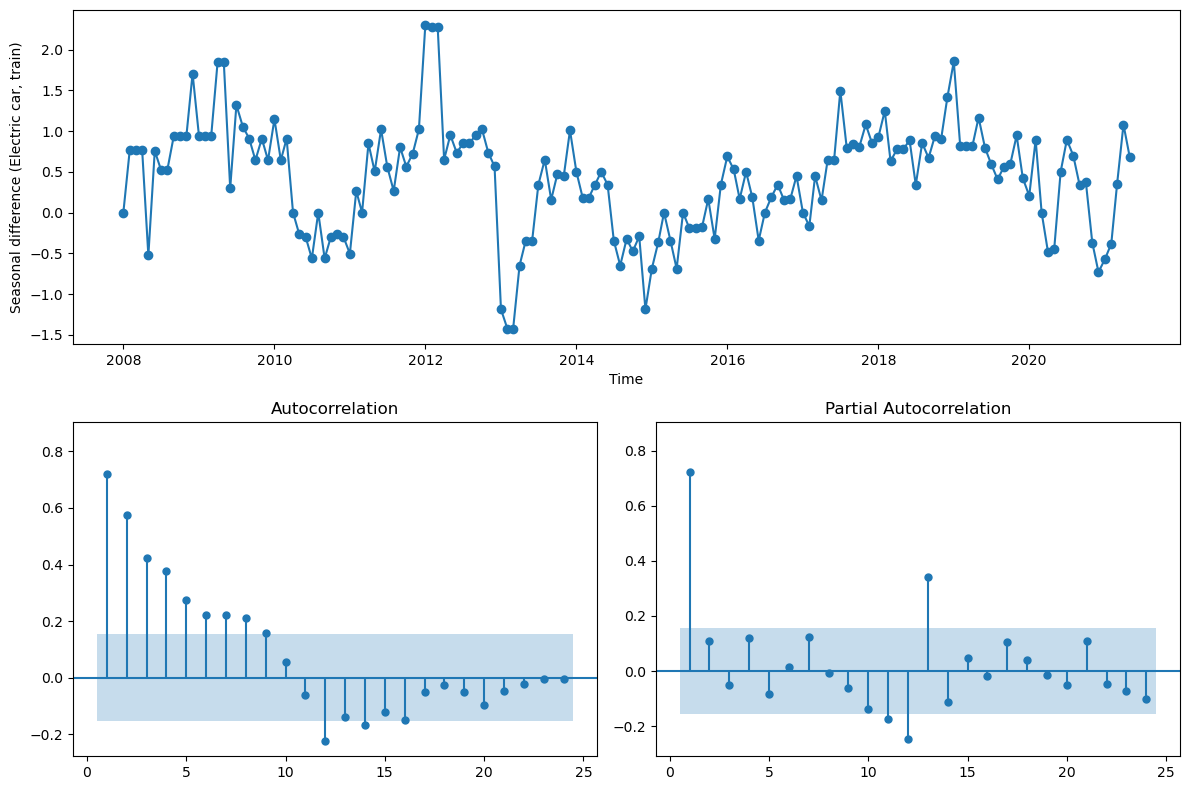

ADF Statistic (seasonal differenced, electric): -3.1661
p-value: 0.0220
Critical Value (1%): -3.4756
Critical Value (5%): -2.8814
Critical Value (10%): -2.5774
The series is likely stationary (reject H0).

KPSS Statistic (seasonal differenced, electric): 0.1433
KPSS p-value: 0.1000
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_20164\2065684011.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_electric_diff = kpss(seasonal_diff_electric, regression='c', nlags="auto")


In [35]:
# Calculate 12-lag (seasonal) difference of the Box-Cox transformed Electric car (G) on the train set
seasonal_diff_electric = train["BoxCox Electric car (G)"].diff(12).dropna()

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(train["Time Period (T)"].iloc[12:], seasonal_diff_electric, marker="o")
ax1.set_ylabel("Seasonal difference (Electric car, train)")
ax1.set_xlabel("Time")

plot_acf(seasonal_diff_electric, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff_electric, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# Perform Augmented Dickey-Fuller test on the seasonal differenced electric car data
adf_result_electric_diff = adfuller(seasonal_diff_electric)
print("ADF Statistic (seasonal differenced, electric): {:.4f}".format(adf_result_electric_diff[0]))
print("p-value: {:.4f}".format(adf_result_electric_diff[1]))
for key, value in adf_result_electric_diff[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_electric_diff[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

# Perform KPSS test on the seasonal differenced electric car data
kpss_result_electric_diff = kpss(seasonal_diff_electric, regression='c', nlags="auto")
print("\nKPSS Statistic (seasonal differenced, electric): {:.4f}".format(kpss_result_electric_diff[0]))
print("KPSS p-value: {:.4f}".format(kpss_result_electric_diff[1]))
for key, value in kpss_result_electric_diff[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")

if kpss_result_electric_diff[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

> since its stationary i will continue with splitting the data into train/validation/test sets

### 4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time:

In [36]:
# Test optimal lag for seasonal_diff_electric as exogenous regressor

max_lag = 6  # Number of lags to test

# Compute seasonal difference for electric car (G)
seasonal_diff_electric = train["BoxCox Electric car (G)"].diff(12).dropna()

# Ensure exog_series has datetime index matching train
exog_series = seasonal_diff_electric.copy()
if not isinstance(exog_series.index, pd.DatetimeIndex):
    exog_series.index = train["Time Period (T)"].iloc[exog_series.index]

# Target series with datetime index
target_series = train.set_index("Time Period (T)")['BoxCox vehicles sold (Target)']

lag_results = []

for lag in range(0, max_lag + 1):
    if lag == 0:
        exog = exog_series.copy()
        label = "lag0"
    else:
        exog = exog_series.shift(lag)
        label = f"lag{lag}"

    # Align target and exog by intersection of their datetime indices (drop NaNs)
    valid_idx = exog.dropna().index.intersection(target_series.index)
    exog_valid = exog.loc[valid_idx]
    target_valid = target_series.loc[valid_idx]

    # Fit SARIMAX
    model = SARIMAX(
        target_valid,
        exog=exog_valid,
        order=(1, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)
    exog_pval = results.pvalues.iloc[-1]
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": exog_pval,
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\nLag Comparison Summary:")
print(lag_df)

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  


Lag Comparison Summary:
    Lag       AIC        BIC  Coefficient p-value  Log Likelihood
0  lag0  0.889388  15.415762         5.916226e-22        4.555306
1  lag1  2.138457  16.627656         1.187409e-22        3.930772
2  lag2  3.666273  18.118019         3.129902e-22        3.166863
3  lag3  4.709582  19.123592         5.801514e-22        2.645209
4  lag4  5.388479  19.764465         4.164229e-19        2.305761
6  lag6  6.343201  20.642263         1.800042e-21        1.828399
5  lag5  6.469069  20.806742         3.927596e-19        1.765465


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Validation RMSE (BoxCox): 0.2918
Validation MAPE (BoxCox): 2.30%
Validation RMSE (Back-transformed): 6698.41
Validation MAPE (Back-transformed): 27.99%


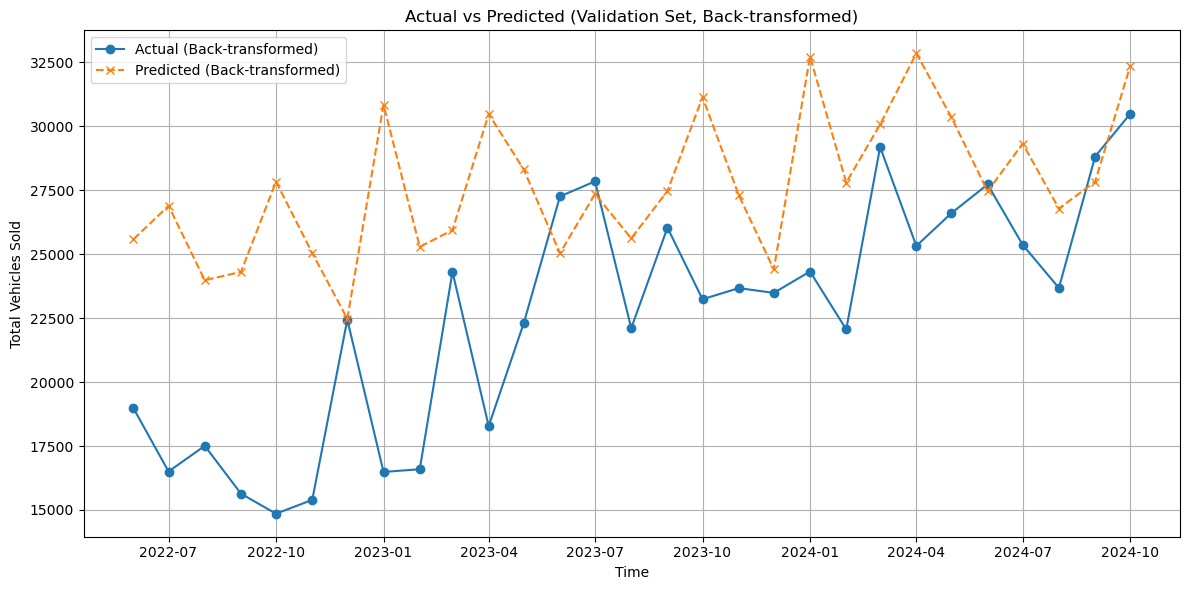

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.special import inv_boxcox

# Ensure BoxCox Electric car (G) exists in aligned_df
if "BoxCox Electric car (G)" not in aligned_df.columns:
    electric_col = "Electric car (G)"
    electric_values = aligned_df[electric_col].values
    # Box-Cox requires strictly positive values
    if (electric_values <= 0).any():
        electric_values_shifted = electric_values + 1
    else:
        electric_values_shifted = electric_values
    aligned_df["BoxCox Electric car (G)"] = boxcox(electric_values_shifted, lmbda=electric_lambda_train)

# Compute seasonal difference (lag 12) of BoxCox Electric car (G) for train
if "exog_electric_seasonal_diff" not in aligned_df.columns:
    aligned_df["exog_electric_seasonal_diff"] = aligned_df["BoxCox Electric car (G)"].diff(12)

# Drop rows with NaN in exog or target
aligned_df_electric = aligned_df.dropna(subset=["exog_electric_seasonal_diff", "BoxCox vehicles sold (Target)"])

target_series = aligned_df_electric["BoxCox vehicles sold (Target)"]
exog_series = aligned_df_electric["exog_electric_seasonal_diff"]  # lag 0

# Fit SARIMAX model with lag 0 exogenous electric car seasonal diff
model = SARIMAX(
    target_series,
    exog=exog_series,
    order=(1, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
# Ensure BoxCox Electric car (G) exists in val
if "BoxCox Electric car (G)" not in val.columns:
    electric_col = "Electric car (G)"
    electric_values_val = val[electric_col].values
    # Box-Cox requires strictly positive values
    if (electric_values_val <= 0).any():
        electric_values_val_shifted = electric_values_val + 1
    else:
        electric_values_val_shifted = electric_values_val
    val["BoxCox Electric car (G)"] = boxcox(electric_values_val_shifted, lmbda=electric_lambda_train)

# Compute seasonal difference (lag 12) of BoxCox Electric car (G) for validation set
if "exog_electric_seasonal_diff" not in val.columns:
    val["exog_electric_seasonal_diff"] = val["BoxCox Electric car (G)"].diff(12)

# Drop rows with NaN in exog or target for validation
val_valid_electric = val.dropna(subset=["exog_electric_seasonal_diff", "BoxCox vehicles sold (Target)"]).copy()

# Prepare validation exogenous variable (lag 0)
exog_val = val_valid_electric["exog_electric_seasonal_diff"].values
actuals_bc = val_valid_electric["BoxCox vehicles sold (Target)"].values
val_index = val_valid_electric.index

# Forecast on validation set
n_val = len(val_valid_electric)
forecast = results.get_forecast(steps=n_val, exog=exog_val)
preds_bc = forecast.predicted_mean
val_index = val_valid.index

# Forecast on validation set
n_val = len(val_valid)
forecast = results.get_forecast(steps=n_val, exog=exog_val)
preds_bc = forecast.predicted_mean

# Evaluate performance (BoxCox space)
rmse_bc = np.sqrt(mean_squared_error(actuals_bc, preds_bc))
mape_bc = mean_absolute_percentage_error(actuals_bc, preds_bc) * 100

print(f"Validation RMSE (BoxCox): {rmse_bc:.4f}")
print(f"Validation MAPE (BoxCox): {mape_bc:.2f}%")

# Back-transform predictions and actuals
fitted_lambda = fitted_lambda_train  # already defined in previous cells
preds_back = inv_boxcox(preds_bc, fitted_lambda)
actuals_back = inv_boxcox(actuals_bc, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"Validation RMSE (Back-transformed): {rmse_back:.2f}")
print(f"Validation MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted (back-transformed)
plt.figure(figsize=(12, 6))
plt.plot(val_index, actuals_back, label="Actual (Back-transformed)", marker="o")
plt.plot(val_index, preds_back, label="Predicted (Back-transformed)", marker="x", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Total Vehicles Sold")
plt.title("Actual vs Predicted (Validation Set, Back-transformed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###  1. Data Cleaning & Transformation 
Home charging (G)'

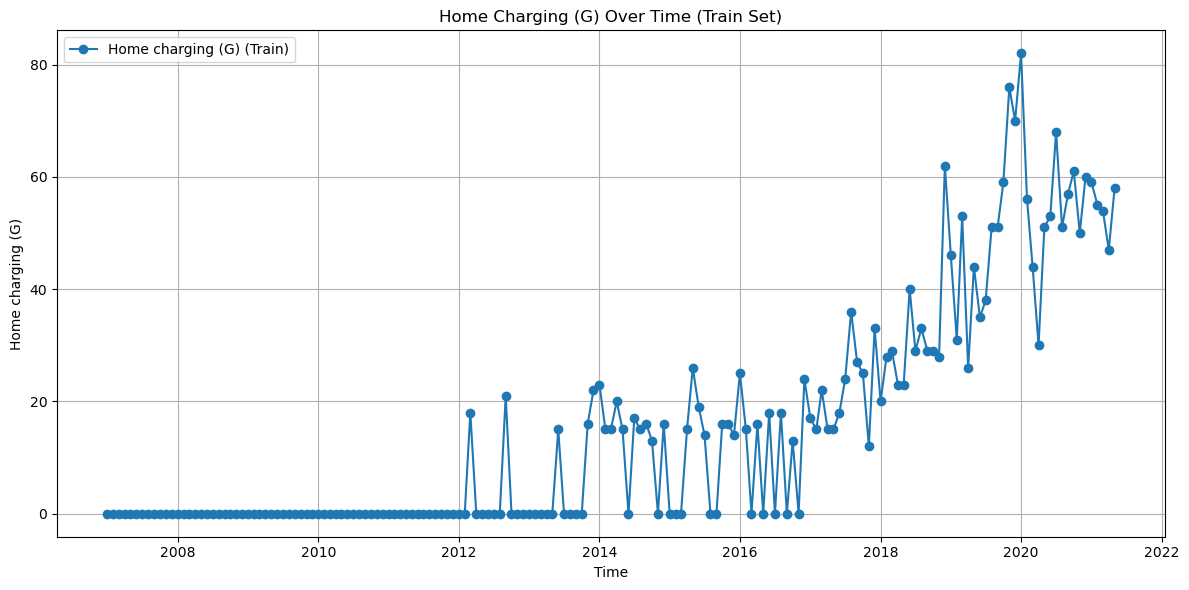

In [38]:
plt.figure(figsize=(12, 6))
# Use index if 'Time Period (T)' is not a column
x_axis = train["Time Period (T)"] if "Time Period (T)" in train.columns else train.index
plt.plot(x_axis, train["Home charging (G)"], marker='o', label="Home charging (G) (Train)")
plt.xlabel("Time")
plt.ylabel("Home charging (G)")
plt.title("Home Charging (G) Over Time (Train Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

a lot of varience in the data, so i will apply a box cox transformation to the data.

Box-Cox lambda for 'Home charging (G)' (train): -0.1635


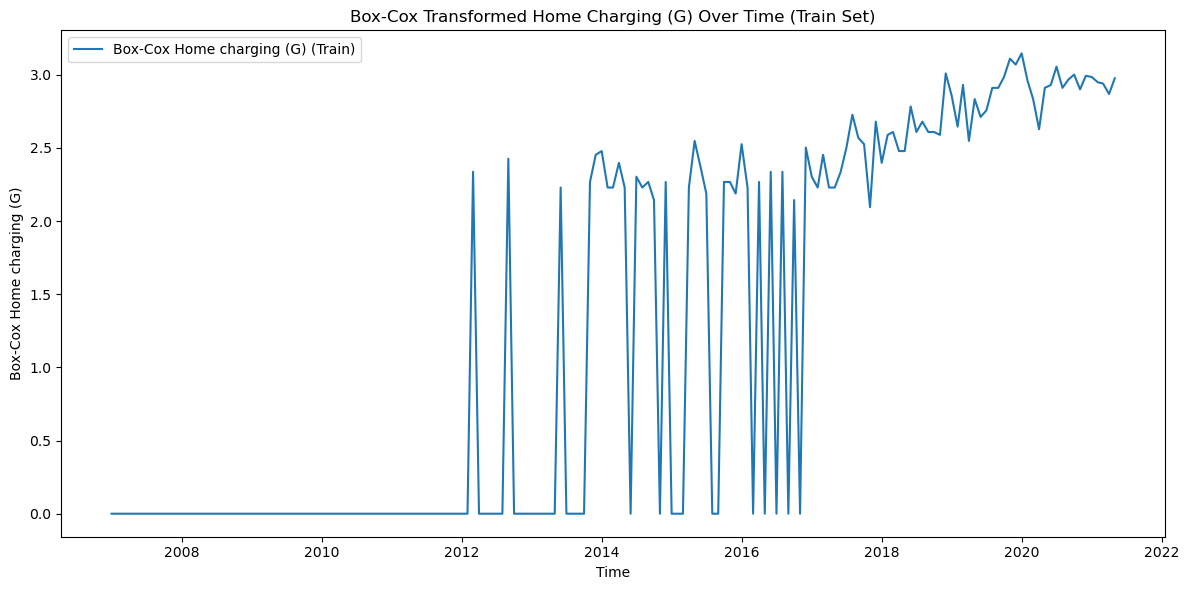

In [39]:
from scipy.stats import boxcox

home_charging_col = "Home charging (G)"
home_charging_values_train = train[home_charging_col].values

# Box-Cox requires strictly positive values, so add a small constant if needed
if (home_charging_values_train <= 0).any():
    home_charging_values_train_shifted = home_charging_values_train + 1
else:
    home_charging_values_train_shifted = home_charging_values_train

home_charging_boxcox, home_charging_lambda_train = boxcox(home_charging_values_train_shifted)

# Save transformed values to the train DataFrame
train['BoxCox ' + home_charging_col] = home_charging_boxcox

print(f"Box-Cox lambda for '{home_charging_col}' (train): {home_charging_lambda_train:.4f}")

plt.figure(figsize=(12, 6))
# Use index if 'Time Period (T)' is not a column
x_axis = train["Time Period (T)"] if "Time Period (T)" in train.columns else train.index
plt.plot(x_axis, home_charging_boxcox, label="Box-Cox Home charging (G) (Train)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Home charging (G)")
plt.title("Box-Cox Transformed Home Charging (G) Over Time (Train Set)")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

Perform Augmented Dickey-Fuller test on Box-Cox transformed x

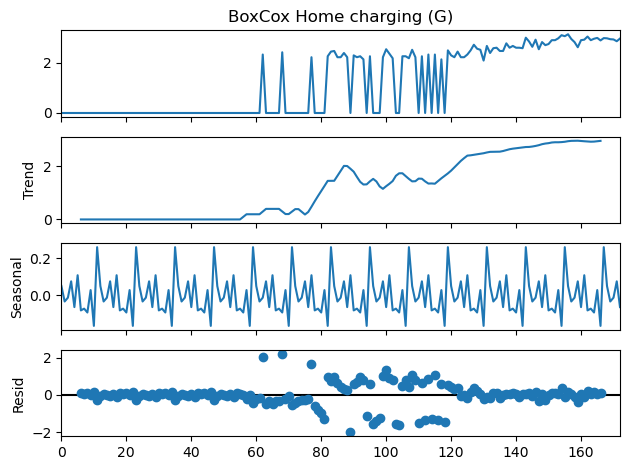

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(train["BoxCox Home charging (G)"], model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()

In [41]:
from statsmodels.tsa.stattools import adfuller, kpss

# Use Box-Cox transformed Home charging (G) from train set
y_home = train['BoxCox Home charging (G)']

# Augmented Dickey-Fuller test
adf_result_home = adfuller(y_home)
print("ADF Statistic: {:.4f}".format(adf_result_home[0]))
print("ADF p-value: {:.4f}".format(adf_result_home[1]))
for key, value in adf_result_home[4].items():
    print(f"ADF Critical Value ({key}): {value:.4f}")
if adf_result_home[1] < 0.05:
    print("ADF: The series is likely stationary (reject H0).")
else:
    print("ADF: The series is likely non-stationary (fail to reject H0).")

# KPSS test
kpss_result_home = kpss(y_home, regression='c', nlags="auto")
print("\nKPSS Statistic: {:.4f}".format(kpss_result_home[0]))
print("KPSS p-value: {:.4f}".format(kpss_result_home[1]))
for key, value in kpss_result_home[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")
if kpss_result_home[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

ADF Statistic: -0.3142
ADF p-value: 0.9235
ADF Critical Value (1%): -3.4724
ADF Critical Value (5%): -2.8800
ADF Critical Value (10%): -2.5766
ADF: The series is likely non-stationary (fail to reject H0).

KPSS Statistic: 1.8622
KPSS p-value: 0.0100
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_20164\1859757785.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result_home = kpss(y_home, regression='c', nlags="auto")


since its not stationary, i will apply a first difference 

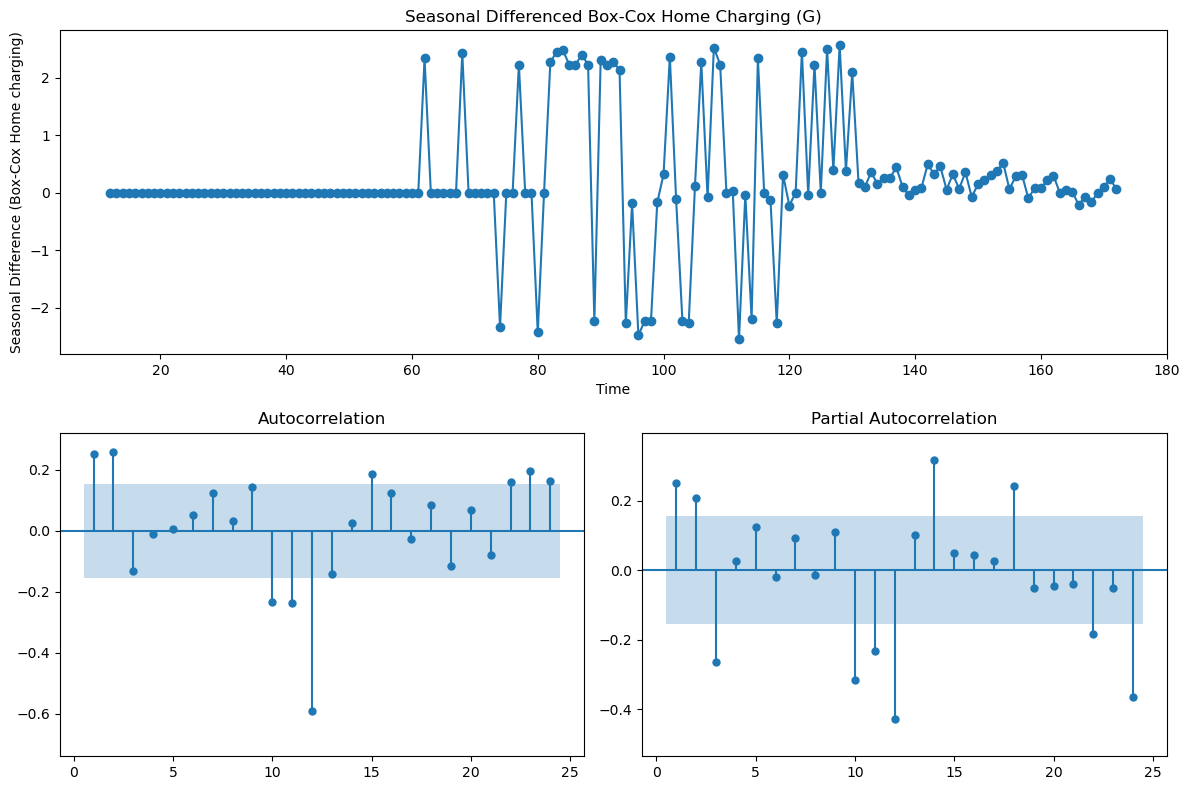

ADF Statistic (seasonal differenced): -3.5799
p-value: 0.0062
Critical Value (1%): -3.4756
Critical Value (5%): -2.8814
Critical Value (10%): -2.5774
The series is likely stationary (reject H0).

KPSS Statistic (seasonal differenced): 0.1135
KPSS p-value: 0.1000
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).


C:\Users\dylan\AppData\Local\Temp\ipykernel_20164\194322004.py:36: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_home = kpss(seasonal_diff_home, regression='c', nlags="auto")


In [42]:
# Apply seasonal difference (lag=12) to BoxCox Home charging (G)
seasonal_diff_home = train["BoxCox Home charging (G)"].diff(12).dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(seasonal_diff_home.index, seasonal_diff_home, marker="o")
ax1.set_ylabel("Seasonal Difference (Box-Cox Home charging)")
ax1.set_xlabel("Time")
ax1.set_title("Seasonal Differenced Box-Cox Home Charging (G)")

# ACF and PACF
plot_acf(seasonal_diff_home, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff_home, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result_home = adfuller(seasonal_diff_home)
print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result_home[0]))
print("p-value: {:.4f}".format(adf_result_home[1]))
for key, value in adf_result_home[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_home[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

# KPSS Test
kpss_result_home = kpss(seasonal_diff_home, regression='c', nlags="auto")
print("\nKPSS Statistic (seasonal differenced): {:.4f}".format(kpss_result_home[0]))
print("KPSS p-value: {:.4f}".format(kpss_result_home[1]))
for key, value in kpss_result_home[3].items():
    print(f"KPSS Critical Value ({key}): {value:.4f}")

if kpss_result_home[1] < 0.05:
    print("KPSS: The series is likely non-stationary (reject H0).")
else:
    print("KPSS: The series is likely stationary (fail to reject H0).")

since its stationary i will continue with splitting the data into train/validation/test sets

### 4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time:

In [43]:
# Settings
max_lag = 6  # How many lags you'd like to test

# Use seasonal difference of BoxCox-transformed Home charging (G) from train set
seasonal_diff_home = train["BoxCox Home charging (G)"].diff(12).dropna()

# Use BoxCox-transformed target from train set
target_series = train['BoxCox vehicles sold (Target)']

# Ensure both are indexed by datetime and have freq set
if not isinstance(seasonal_diff_home.index, pd.DatetimeIndex):
    seasonal_diff_home.index = train['Time Period (T)'].iloc[seasonal_diff_home.index]
if seasonal_diff_home.index.freq is None:
    seasonal_diff_home.index = seasonal_diff_home.index.to_period("M").to_timestamp()

if not isinstance(target_series.index, pd.DatetimeIndex):
    target_series.index = train['Time Period (T)']
if target_series.index.freq is None:
    target_series.index = target_series.index.to_period("M").to_timestamp()

# Store results
lag_results = []

for lag in range(0, max_lag + 1):
    # Create lagged exogenous variable
    if lag == 0:
        exog = seasonal_diff_home.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = seasonal_diff_home.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    # Ensure both have DatetimeIndex and freq set
    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()  # Set freq to monthly
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    # Align indices by intersection
    common_idx = exog.index.intersection(model_target.index)
    exog_aligned = exog.loc[common_idx]
    target_aligned = model_target.loc[common_idx]

    # Fit SARIMAX
    model = SARIMAX(
        target_aligned,
        exog=exog_aligned,
        order=(1, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    # Log metrics
    exog_pval = results.pvalues.iloc[-1]
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": exog_pval,
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n Lag Comparison Summary:")
print(lag_df)


 Lag Comparison Summary:
    Lag       AIC        BIC  Coefficient p-value  Log Likelihood
0  lag0  2.524050  17.050424         2.415816e-20        3.737975
5  lag5  3.176542  17.514214         1.397092e-21        3.411729
1  lag1  3.325180  17.814379         2.516097e-19        3.337410
2  lag2  3.475338  17.927084         2.999918e-21        3.262331
3  lag3  4.759415  19.173424         8.309287e-18        2.620293
4  lag4  5.329098  19.705084         3.144334e-21        2.335451
6  lag6  6.710584  21.009646         5.232974e-19        1.644708


In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.special import inv_boxcox

# Ensure "Time Period (T)" is datetime and set as index
train_indexed = train.copy()
train_indexed["Time Period (T)"] = pd.to_datetime(train_indexed["Time Period (T)"])
train_indexed = train_indexed.set_index("Time Period (T)")

# Compute seasonal difference for BoxCox Home charging (G) with datetime index
seasonal_diff_home = train_indexed["BoxCox Home charging (G)"].diff(12).dropna()

# Align target and exogenous by intersection of their datetime indices
target_series = train_indexed["BoxCox vehicles sold (Target)"]
common_idx = seasonal_diff_home.index.intersection(target_series.index)
exog_aligned = seasonal_diff_home.loc[common_idx]
target_aligned = target_series.loc[common_idx]

# Fit SARIMAX model
model = SARIMAX(
    target_aligned,
    exog=exog_aligned,
    order=(1, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

print(results.summary())

import matplotlib.pyplot as plt

# Prepare validation exogenous variable (seasonal diff of home charging)
# Compute BoxCox for Home charging (G) in val using train's lambda
home_charging_col = "Home charging (G)"
if "BoxCox Home charging (G)" not in val_valid.columns:
    home_vals = val_valid[home_charging_col].values
    # Use the lambda from train
    if (home_vals <= 0).any():
        home_vals_shifted = home_vals + 1
    else:
        home_vals_shifted = home_vals
    val_valid["BoxCox Home charging (G)"] = boxcox(home_vals_shifted, lmbda=home_charging_lambda_train)

# Compute seasonal diff (lag 12) for validation set
val_valid["exog_home_seasonal_diff"] = val_valid["BoxCox Home charging (G)"].diff(12)

# Drop rows with NaN in exog or target
val_valid_home = val_valid.dropna(subset=["exog_home_seasonal_diff", "BoxCox vehicles sold (Target)"]).copy()

# Prepare exogenous and target arrays for forecasting
# Ensure both exog and target have no NaNs and are aligned
val_valid_home = val_valid_home.dropna(subset=["exog_home_seasonal_diff", "BoxCox vehicles sold (Target)"])
# Only use rows where both columns are not NaN
exog_val = val_valid_home["exog_home_seasonal_diff"].to_numpy()
actuals_bc = val_valid_home["BoxCox vehicles sold (Target)"].to_numpy()
val_index_plot = val_valid_home.index

# Double-check for NaNs before forecasting
if np.isnan(exog_val).any() or np.isnan(actuals_bc).any():
    raise ValueError("NaN values remain in exog_val or actuals_bc after dropping NaNs.")

# Forecast on validation set
n_val = len(val_valid_home)
forecast = results.get_forecast(steps=n_val, exog=exog_val)
preds_bc = forecast.predicted_mean

# Evaluate performance (BoxCox space)
rmse_bc = np.sqrt(mean_squared_error(actuals_bc, preds_bc))
mape_bc = mean_absolute_percentage_error(actuals_bc, preds_bc) * 100

print(f"Validation RMSE (BoxCox): {rmse_bc:.4f}")
print(f"Validation MAPE (BoxCox): {mape_bc:.2f}%")

# Back-transform predictions and actuals
fitted_lambda = home_charging_lambda_train
preds_back = inv_boxcox(preds_bc, fitted_lambda)
actuals_back = inv_boxcox(actuals_bc, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"Validation RMSE (Back-transformed): {rmse_back:.2f}")
print(f"Validation MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted (back-transformed)
plt.figure(figsize=(12, 6))
plt.plot(val_index_plot, actuals_back, label="Actual (Back-transformed)", marker="o")
plt.plot(val_index_plot, preds_back, label="Predicted (Back-transformed)", marker="x", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Total Vehicles Sold")
plt.title("Actual vs Predicted (Validation Set, Back-transformed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  161
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   3.738
Date:                            Thu, 17 Jul 2025   AIC                              2.524
Time:                                    10:45:56   BIC                             17.050
Sample:                                01-01-2008   HQIC                             8.427
                                     - 05-01-2021                                         
Covariance Type:                              opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
BoxCox Home charging (G)     0.0113      0.013      0.850      0.395      -0.015      

ValueError: Input contains NaN.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.special import inv_boxcox

# Compute seasonal difference for Home charging (G) (lag 12)
seasonal_diff_home = train["BoxCox Home charging (G)"].diff(12).dropna()

# Align exogenous and target series by datetime index
if not isinstance(seasonal_diff_home.index, pd.DatetimeIndex):
    seasonal_diff_home.index = train["Time Period (T)"].iloc[seasonal_diff_home.index]
target_series = train.set_index("Time Period (T)")["BoxCox vehicles sold (Target)"]
common_idx = seasonal_diff_home.index.intersection(target_series.index)
exog_series = seasonal_diff_home.loc[common_idx]
target_series = target_series.loc[common_idx]

# Fit SARIMAX model with lag 0 exogenous home charging seasonal diff
model = SARIMAX(
    target_series,
    exog=exog_series,
    order=(1, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

print(results.summary())

import matplotlib.pyplot as plt

# Prepare validation exogenous variable (lag 0)
if "exog_home_seasonal_diff" not in val_valid.columns:
    # Compute seasonal diff for BoxCox Home charging (G) in validation set
    val_valid = val_valid.copy()
    val_valid["exog_home_seasonal_diff"] = val_valid["BoxCox Home charging (G)"].diff(12)

# Drop rows with NaN in exogenous or target
val_valid_no_nan = val_valid.dropna(subset=["exog_home_seasonal_diff", "BoxCox vehicles sold (Target)"]).copy()

exog_val = val_valid_no_nan["exog_home_seasonal_diff"].values
actuals_bc = val_valid_no_nan["BoxCox vehicles sold (Target)"].values
val_index = val_valid_no_nan.index

# Forecast on validation set
n_val = len(val_valid)
forecast = results.get_forecast(steps=n_val, exog=exog_val)
preds_bc = forecast.predicted_mean

# Evaluate performance (BoxCox space)
rmse_bc = np.sqrt(mean_squared_error(actuals_bc, preds_bc))
mape_bc = mean_absolute_percentage_error(actuals_bc, preds_bc) * 100

print(f"Validation RMSE (BoxCox): {rmse_bc:.4f}")
print(f"Validation MAPE (BoxCox): {mape_bc:.2f}%")

# Back-transform predictions and actuals
fitted_lambda = fitted_lambda_train  # already defined in previous cells
preds_back = inv_boxcox(preds_bc, fitted_lambda)
actuals_back = inv_boxcox(actuals_bc, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"Validation RMSE (Back-transformed): {rmse_back:.2f}")
print(f"Validation MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted (back-transformed)
plt.figure(figsize=(12, 6))
plt.plot(val_index, actuals_back, label="Actual (Back-transformed)", marker="o")
plt.plot(val_index, preds_back, label="Predicted (Back-transformed)", marker="x", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Total Vehicles Sold")
plt.title("Actual vs Predicted (Validation Set, Back-transformed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: "None of ['Time Period (T)'] are in the columns"

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  152
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   6.800
Date:                            Sat, 12 Jul 2025   AIC                             -1.600
Time:                                    17:21:42   BIC                             15.418
Sample:                                01-01-2009   HQIC                             5.314
                                     - 08-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0048      0.010     -0.470      0.638      -0.025       0.015
ar.L1          1.2894      0.147   

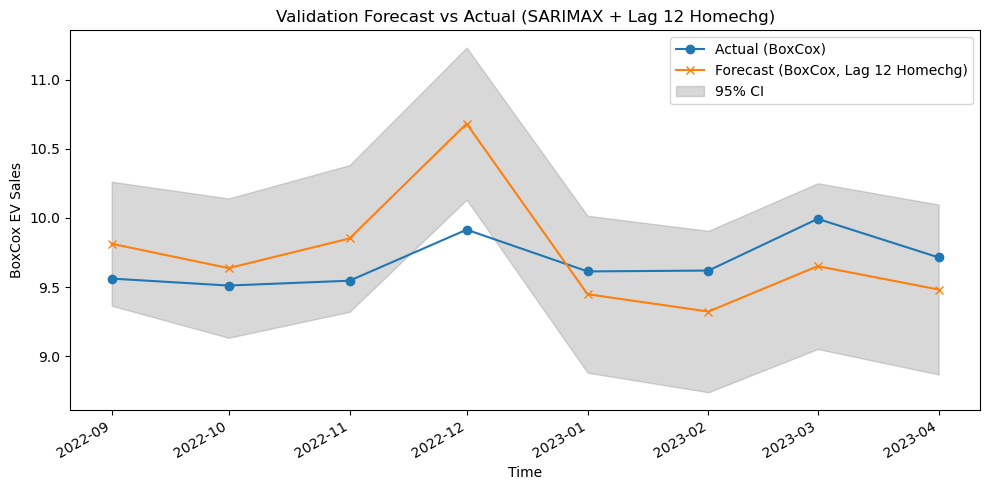

In [ ]:
# Prepare lagged exogenous predictor for train/val split (Home charging, lag 12)
homechg_lag12_train = homechg_train.shift(12)
homechg_lag12_val = homechg_val.shift(12)

# Align with target and drop NaNs for training
train_mask = ~homechg_lag12_train.isna()
homechg_lag12_train_clean = homechg_lag12_train[train_mask]
target_train_clean = target_train[train_mask]

# Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=homechg_lag12_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Align validation exog and target (drop NaNs in exog)
val_mask = ~homechg_lag12_val.isna()
homechg_lag12_val_clean = homechg_lag12_val[val_mask]
target_val_clean = target_val[val_mask]

# Forecast validation set
forecast = results.get_forecast(steps=len(homechg_lag12_val_clean), exog=homechg_lag12_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_clean.index
ax.plot(val_dates, target_val_clean, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, Lag 12 Homechg)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Lag 12 Homechg)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


### 5. Then try combining all three:
Use a SARIMAX model with multiple exog variables

Watch out for multicollinearity (flattened ACFs are a hint!)

Use statsmodels Variance Inflation Factor (VIF) or .summary() to inspect coefficient stability

3️⃣ Compare model fit:

If the combined model yields significantly better AICc and forecast accuracy, you keep the trio.

Otherwise, just retain top performers individually.

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  152
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  11.317
Date:                            Mon, 14 Jul 2025   AIC                             -6.634
Time:                                    13:43:35   BIC                             16.056
Sample:                                01-01-2009   HQIC                             2.584
                                     - 08-01-2021                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
homechg_lag12     -0.0017      0.009     -0.178      0.859      -0.020       0.017
electric_lag10    -0.11

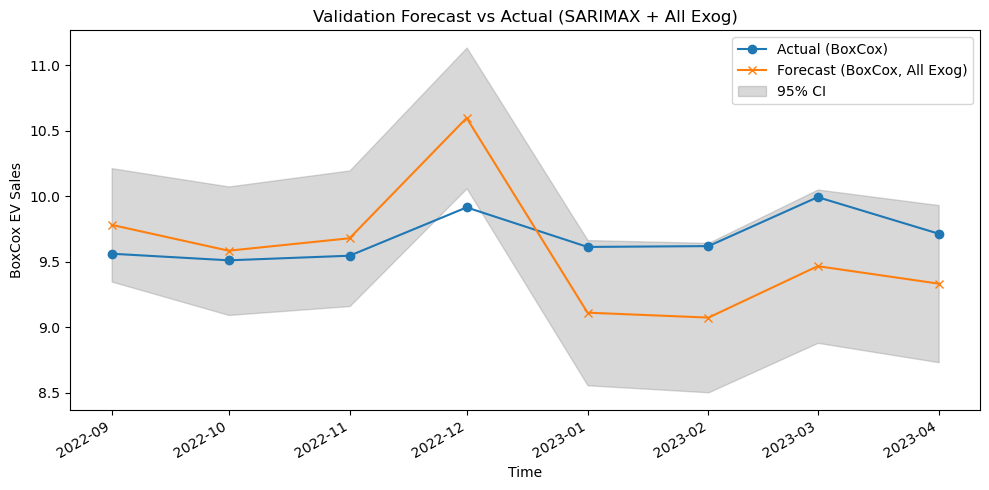

<Figure size 800x400 with 0 Axes>

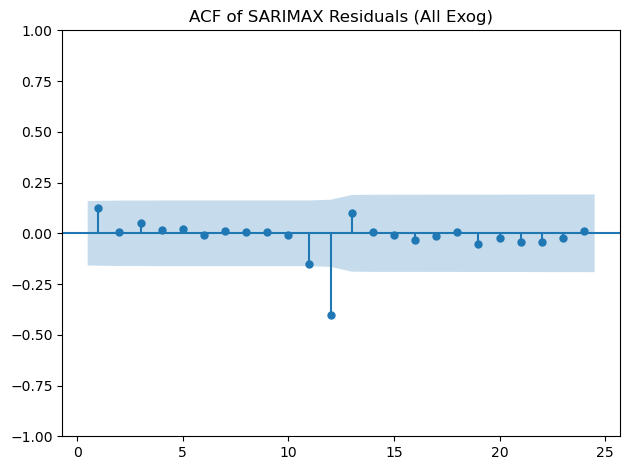


Variance Inflation Factors (VIF):
         Variable       VIF
0   homechg_lag12  1.062061
1  electric_lag10  1.053143
2     hybrid_lag0  1.009542


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Combine all three exogenous features for train/validation (align by dropping any rows with NaN in any exog)
exog_train_all = pd.concat(
    [homechg_lag12_train, electric_lag10_train, hybrid_lag0_train], axis=1
).dropna()
exog_train_all.columns = ['homechg_lag12', 'electric_lag10', 'hybrid_lag0']

# Align target to exog_train_all index
target_train_all = target_train.loc[exog_train_all.index]

# Same for validation set
exog_val_all = pd.concat(
    [homechg_lag12_val, electric_lag10_val, hybrid_lag0_val], axis=1
).dropna()
exog_val_all.columns = ['homechg_lag12', 'electric_lag10', 'hybrid_lag0']
target_val_all = target_val.loc[exog_val_all.index]

# Fit SARIMAX with all three exogenous variables
model = SARIMAX(
    target_train_all,
    exog=exog_train_all,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Forecast on validation set
forecast = results.get_forecast(steps=len(exog_val_all), exog=exog_val_all)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_all, preds))
mape = mean_absolute_percentage_error(target_val_all, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_all.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_all.index
ax.plot(val_dates, target_val_all, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, All Exog)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + All Exog)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Plot ACF of residuals

residuals = results.resid
plt.figure(figsize=(8, 4))
plot_acf(residuals, lags=24, zero=False)
plt.title("ACF of SARIMAX Residuals (All Exog)")
plt.tight_layout()
plt.show()

# VIF test for multicollinearity

# VIF expects no NaNs and a numpy array
vif_data = exog_train_all.values
vif_df = pd.DataFrame({
    "Variable": exog_train_all.columns,
    "VIF": [variance_inflation_factor(vif_data, i) for i in range(vif_data.shape[1])]
})
print("\nVariance Inflation Factors (VIF):")
print(vif_df)

| Feature           | Coefficient | p-value | Status            |
|------------------|-------------|---------|-------------------|
| Home Charging (lag 12)  | -0.0017     | 0.859   | ❌ Not significant |
| Electric Car (lag 10)   | -0.1149     | 0.000   | ✅ Significant     |
| Hybrid Electric (lag 0) | +0.0022     | 0.863   | ❌ Not significant |

**Key takeaway:** Only *Electric Car* search term at lag 10 shows strong predictive power. The others likely don’t add meaningful signal.
| Predictor        | VIF   | Safe?         |
|------------------|-------|----------------|
| Home Charging    | 1.06  | ✅ Yes         |
| Electric Car     | 1.05  | ✅ Yes         |
| Hybrid Electric  | 1.01  | ✅ Yes         |

VIF values are all well below 5 → no multicollinearity concerns.


# - Consumer confidence:
    'Consumer confidence (E)', 'Economic climate perception (E)', 'Willingness to buy (E)'


# 'Consumer confidence (E)

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

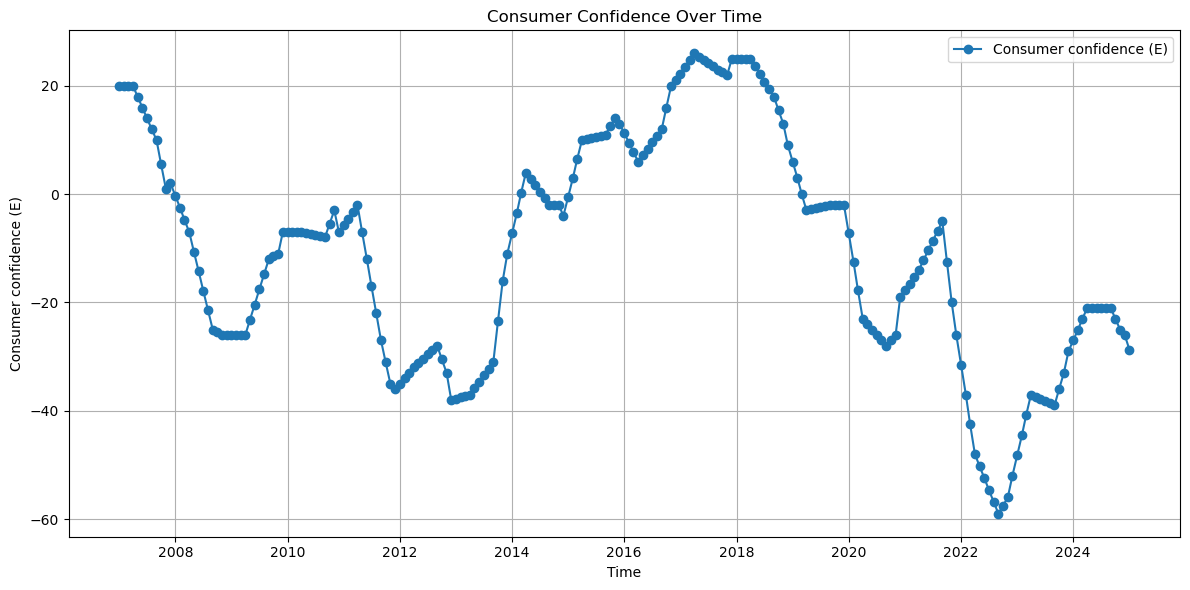

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Consumer confidence (E)"], marker='o', label="Consumer confidence (E)")
plt.xlabel("Time")
plt.ylabel("Consumer confidence (E)")
plt.title("Consumer Confidence Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Box-Cox lambda for 'Consumer confidence (E)': 0.9074


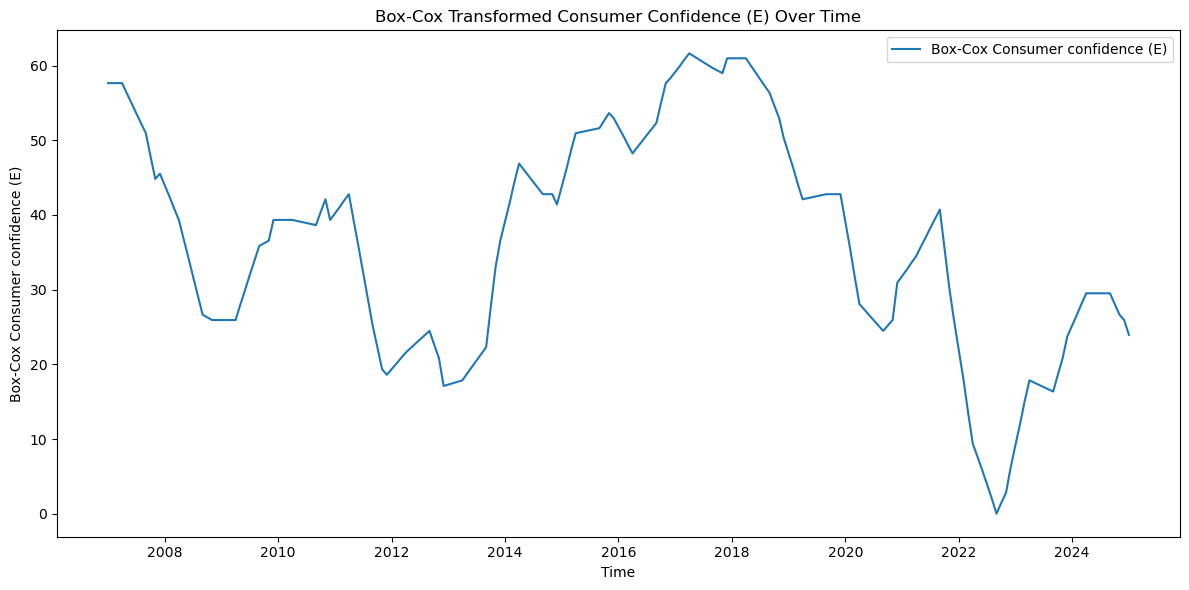

In [ ]:
# Box-Cox transform for 'Consumer confidence (E)'
consumer_conf_col = "Consumer confidence (E)"
consumer_conf_values = df[consumer_conf_col].values

# Box-Cox requires strictly positive values, so add a constant if needed
if (consumer_conf_values <= 0).any():
    consumer_conf_values_shifted = consumer_conf_values - consumer_conf_values.min() + 1
else:
    consumer_conf_values_shifted = consumer_conf_values

consumer_conf_boxcox, consumer_conf_lambda = boxcox(consumer_conf_values_shifted)

# Save transformed values to the DataFrame
df['BoxCox ' + consumer_conf_col] = consumer_conf_boxcox

print(f"Box-Cox lambda for '{consumer_conf_col}': {consumer_conf_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, consumer_conf_boxcox, label="Box-Cox Consumer confidence (E)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Consumer confidence (E)")
plt.title("Box-Cox Transformed Consumer Confidence (E) Over Time")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

In [ ]:
# Perform Augmented Dickey-Fuller test on Box-Cox transformed Consumer confidence (E)
adf_consumer_conf = adfuller(consumer_conf_boxcox)

print("ADF Statistic (Box-Cox Consumer confidence): {:.4f}".format(adf_consumer_conf[0]))
print("p-value: {:.4f}".format(adf_consumer_conf[1]))
for key, value in adf_consumer_conf[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_consumer_conf[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic (Box-Cox Consumer confidence): -2.5215
p-value: 0.1103
Critical Value (1%): -3.4611
Critical Value (5%): -2.8751
Critical Value (10%): -2.5740
The series is likely non-stationary (fail to reject H0).


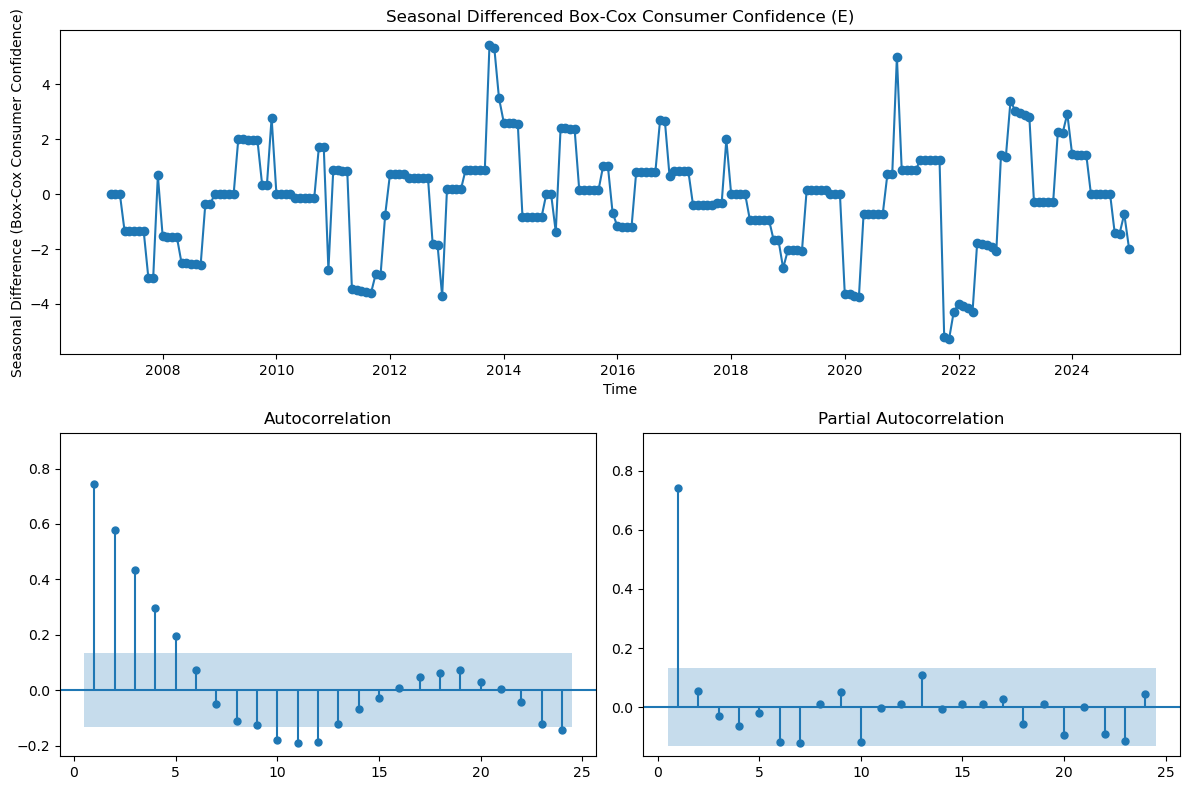

ADF Statistic (seasonal differenced): -5.5259
p-value: 0.0000
Critical Value (1%): -3.4611
Critical Value (5%): -2.8751
Critical Value (10%): -2.5740
The series is likely stationary (reject H0).


In [ ]:
# Convert BoxCox Consumer confidence (E) to Series to align with time index
consumer_conf_boxcox_series = pd.Series(consumer_conf_boxcox, index=df.index)

# Compute 12-lag seasonal difference
seasonal_diff_cons_conf = consumer_conf_boxcox_series.diff(1).dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df.index[1:], seasonal_diff_cons_conf, marker="o")
ax1.set_ylabel("Seasonal Difference (Box-Cox Consumer Confidence)")
ax1.set_xlabel("Time")
ax1.set_title("Seasonal Differenced Box-Cox Consumer Confidence (E)")

# ACF and PACF
plot_acf(seasonal_diff_cons_conf, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff_cons_conf, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result_cons_conf = adfuller(seasonal_diff_cons_conf)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result_cons_conf[0]))
print("p-value: {:.4f}".format(adf_result_cons_conf[1]))
for key, value in adf_result_cons_conf[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_cons_conf[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

now its stationary we can continue with splitting the data into train/validation/test sets

### 3. Split Data

lets do 80/10/10 split for train/validation/test sets

In [ ]:
# Align index if needed (should already be DatetimeIndex)
seasonal_diff_cons_conf = seasonal_diff_cons_conf.copy()
seasonal_diff_cons_conf.index = df.index[-len(seasonal_diff_cons_conf):]

# Calculate split indices
n = len(seasonal_diff_cons_conf)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

dates = seasonal_diff_cons_conf.index
train_idx = dates[:train_end]
val_idx = dates[train_end:val_end]
test_idx = dates[val_end:]

# Split the series
consconf_train = seasonal_diff_cons_conf.loc[train_idx]
consconf_val = seasonal_diff_cons_conf.loc[val_idx]
consconf_test = seasonal_diff_cons_conf.loc[test_idx]

print(f"Train length: {len(consconf_train)}")
print(f"Validation length: {len(consconf_val)}")
print(f"Test length: {len(consconf_test)}")

Train length: 172
Validation length: 22
Test length: 22


### 4. Fit SARIMA model on the training set

In [ ]:
# Settings
max_lag = 5  # How many lags you'd like to test

# Ensure df is indexed by datetime and has freq set
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index("Time Period (T)")
if df.index.freq is None:
    df = df.asfreq("MS")  # Set to monthly start, adjust if your data is not monthly

target_series = df["BoxCox vehicles sold (Target)"].loc[consconf_train.index]

# Store results
lag_results = []

for lag in range(0, max_lag + 1):
    # Create lagged exogenous variable
    if lag == 0:
        exog = consconf_train.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = consconf_train.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    # Ensure both have DatetimeIndex and freq set
    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    # Fit SARIMAX
    model = SARIMAX(
        model_target,
        exog=exog,
        order=(2, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    # Log metrics
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": results.pvalues.get(label, None),
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n📊 Lag Comparison Summary:")
print(lag_df)


📊 Lag Comparison Summary:
    Lag       AIC        BIC Coefficient p-value  Log Likelihood
0  lag0 -8.319309   9.582331                None       10.159655
2  lag2 -7.455984  10.362895                None        9.727992
3  lag3 -7.409302  10.367766                None        9.704651
5  lag5 -5.901421  11.791138                None        8.950711
1  lag1 -5.827960  12.032443                None        8.913980
4  lag4 -5.456715  12.278247                None        8.728358


### 5. evaluate model/ combine model

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  172
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  10.160
Date:                            Mon, 14 Jul 2025   AIC                             -8.319
Time:                                    14:31:02   BIC                              9.582
Sample:                                02-01-2007   HQIC                            -1.045
                                     - 05-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0162      0.011      1.483      0.138      -0.005       0.038
ar.L1          1.2014      0.141   

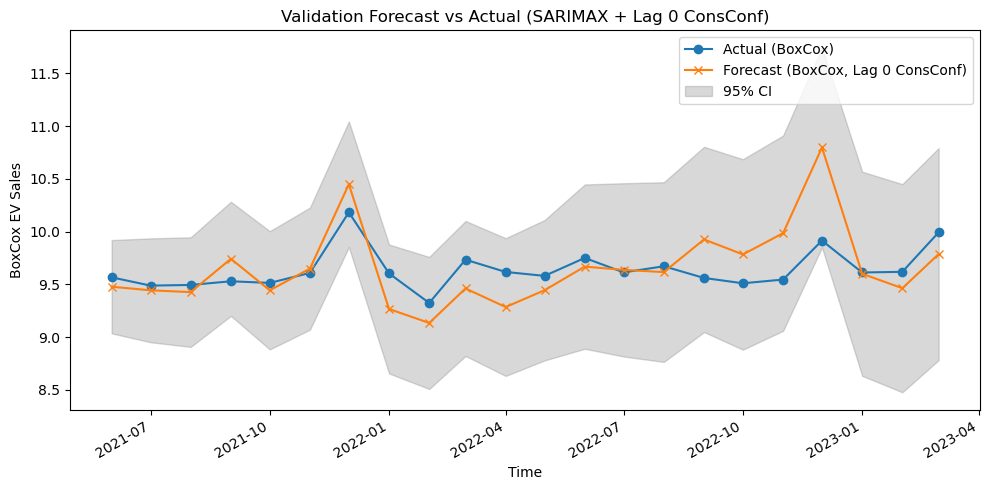

In [ ]:
# Prepare exogenous predictor for train/val split (Consumer confidence, lag 0)
consconf_lag0_train = consconf_train  # lag 0, so no shift
consconf_lag0_val = consconf_val     # lag 0, so no shift

# Align target to exog index for training
target_train_clean = df["BoxCox vehicles sold (Target)"].loc[consconf_lag0_train.index]
consconf_lag0_train_clean = consconf_lag0_train

# Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=consconf_lag0_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Align validation exog and target
target_val_clean = df["BoxCox vehicles sold (Target)"].loc[consconf_lag0_val.index]
consconf_lag0_val_clean = consconf_lag0_val

# Forecast validation set
forecast = results.get_forecast(steps=len(consconf_lag0_val_clean), exog=consconf_lag0_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_clean.index
ax.plot(val_dates, target_val_clean, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, Lag 0 ConsConf)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Lag 0 ConsConf)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# 'Economic climate perception (E)

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

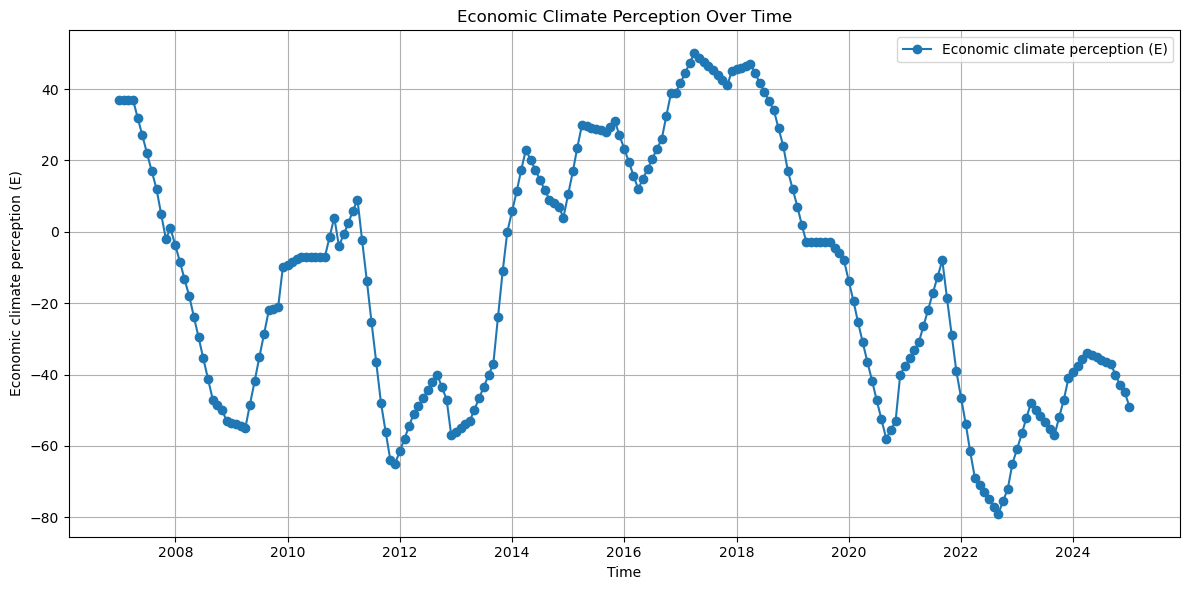

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Economic climate perception (E)"], marker='o', label="Economic climate perception (E)")
plt.xlabel("Time")
plt.ylabel("Economic climate perception (E)")
plt.title("Economic Climate Perception Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Box-Cox lambda for 'Economic climate perception (E)': 0.6438


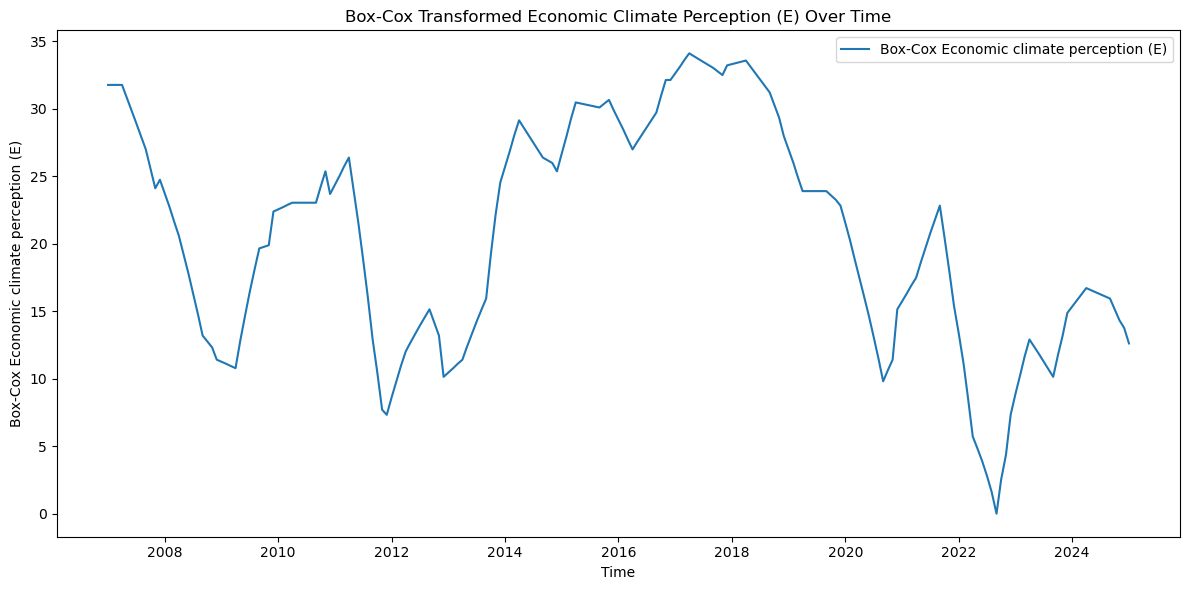

In [ ]:
# Box-Cox transform for 'Economic climate perception (E)'
econ_climate_col = "Economic climate perception (E)"
econ_climate_values = df[econ_climate_col].values

# Box-Cox requires strictly positive values, so add a constant if needed
if (econ_climate_values <= 0).any():
    econ_climate_values_shifted = econ_climate_values - econ_climate_values.min() + 1
else:
    econ_climate_values_shifted = econ_climate_values

econ_climate_boxcox, econ_climate_lambda = boxcox(econ_climate_values_shifted)

# Save transformed values to the DataFrame
df['BoxCox ' + econ_climate_col] = econ_climate_boxcox

print(f"Box-Cox lambda for '{econ_climate_col}': {econ_climate_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, econ_climate_boxcox, label="Box-Cox Economic climate perception (E)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Economic climate perception (E)")
plt.title("Box-Cox Transformed Economic Climate Perception (E) Over Time")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

In [ ]:
# Perform Augmented Dickey-Fuller test on Box-Cox transformed Economic climate perception (E)
adf_econ_climate = adfuller(econ_climate_boxcox)

print("ADF Statistic (Box-Cox Economic climate perception): {:.4f}".format(adf_econ_climate[0]))
print("p-value: {:.4f}".format(adf_econ_climate[1]))
for key, value in adf_econ_climate[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_econ_climate[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")



NameError: name 'adfuller' is not defined

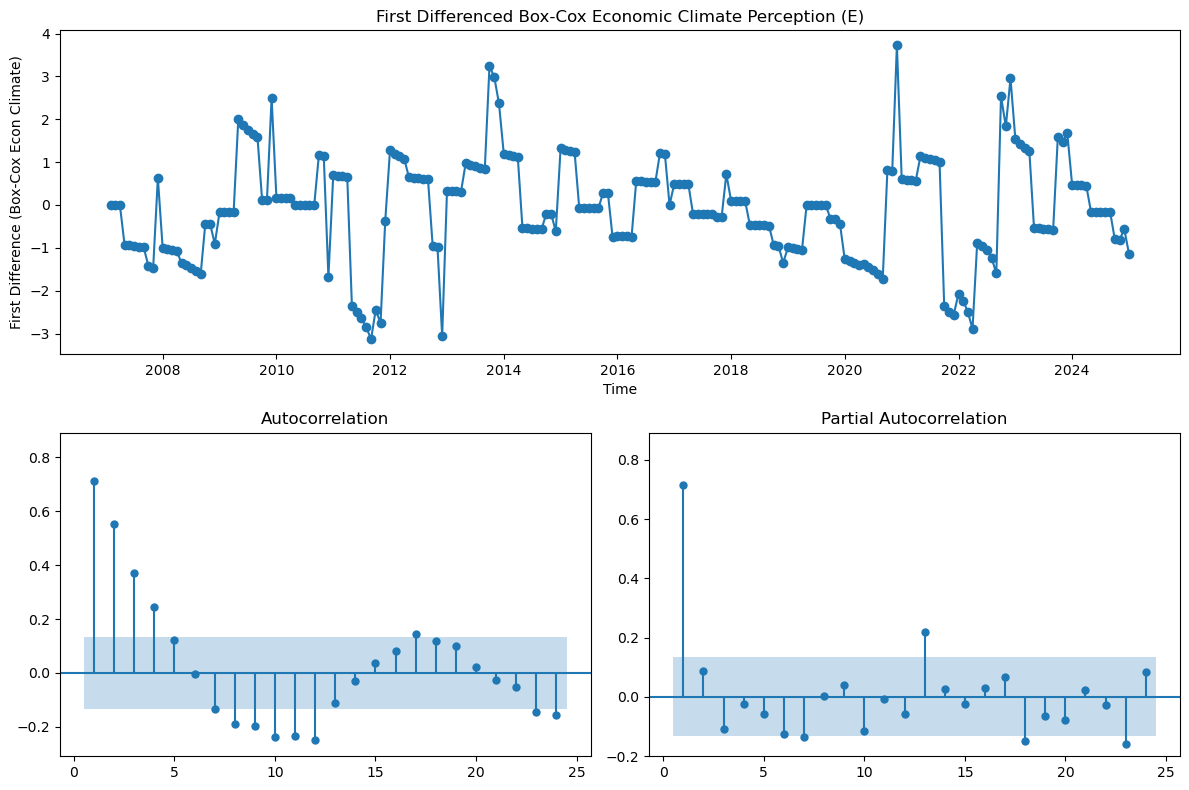

ADF Statistic (first difference): -3.6225
p-value: 0.0053
Critical Value (1%): -3.4630
Critical Value (5%): -2.8759
Critical Value (10%): -2.5744
The series is likely stationary (reject H0).


In [ ]:
# Convert BoxCox Economic climate perception (E) to Series to align with time index
econ_climate_boxcox_series = pd.Series(econ_climate_boxcox, index=df.index)

# Compute first order difference
econ_climate_diff1 = econ_climate_boxcox_series.diff().dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df.index[1:], econ_climate_diff1, marker="o")
ax1.set_ylabel("First Difference (Box-Cox Econ Climate)")
ax1.set_xlabel("Time")
ax1.set_title("First Differenced Box-Cox Economic Climate Perception (E)")

# ACF and PACF
plot_acf(econ_climate_diff1, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(econ_climate_diff1, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result_econ_climate = adfuller(econ_climate_diff1)

print("ADF Statistic (first difference): {:.4f}".format(adf_result_econ_climate[0]))
print("p-value: {:.4f}".format(adf_result_econ_climate[1]))
for key, value in adf_result_econ_climate[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_econ_climate[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

### 3. Split Data

lets do 80/10/10 split for train/validation/test sets

In [ ]:
# Align index if needed (should already be DatetimeIndex)
econ_climate_diff1 = econ_climate_diff1.copy()
econ_climate_diff1.index = df.index[-len(econ_climate_diff1):]

# Calculate split indices
n = len(econ_climate_diff1)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

dates = econ_climate_diff1.index
train_idx = dates[:train_end]
val_idx = dates[train_end:val_end]
test_idx = dates[val_end:]

# Split the series
econclim_train = econ_climate_diff1.loc[train_idx]
econclim_val = econ_climate_diff1.loc[val_idx]
econclim_test = econ_climate_diff1.loc[test_idx]

print(f"Train length: {len(econclim_train)}")
print(f"Validation length: {len(econclim_val)}")
print(f"Test length: {len(econclim_test)}")

Train length: 172
Validation length: 22
Test length: 22


### 4. Fit SARIMA model on the training set

In [ ]:
# Settings
max_lag = 5  # How many lags you'd like to test

# Ensure df is indexed by datetime and has freq set
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index("Time Period (T)")
if df.index.freq is None:
    df = df.asfreq("MS")  # Set to monthly start, adjust if your data is not monthly

target_series = df["BoxCox vehicles sold (Target)"].loc[econclim_train.index]

# Store results
lag_results = []

for lag in range(0, max_lag + 1):
    # Create lagged exogenous variable
    if lag == 0:
        exog = econclim_train.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = econclim_train.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    # Ensure both have DatetimeIndex and freq set
    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    # Fit SARIMAX
    model = SARIMAX(
        model_target,
        exog=exog,
        order=(2, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    # Log metrics
    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": results.pvalues.get(label, None),
        "Log Likelihood": results.llf
    })

# Compare results in a DataFrame
lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n📊 Lag Comparison Summary:")
print(lag_df)


📊 Lag Comparison Summary:
    Lag       AIC        BIC Coefficient p-value  Log Likelihood
2  lag2 -9.302843   8.516037                None       10.651422
0  lag0 -9.254916   8.646724                None       10.627458
3  lag3 -7.105031  10.672037                None        9.552516
5  lag5 -5.929388  11.763171                None        8.964694
1  lag1 -5.746377  12.114025                None        8.873189
4  lag4 -5.548757  12.186205                None        8.774379


### 5. evaluate model/ combine model

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  170
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  10.651
Date:                            Mon, 14 Jul 2025   AIC                             -9.303
Time:                                    14:56:54   BIC                              8.516
Sample:                                04-01-2007   HQIC                            -2.062
                                     - 05-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0248      0.017     -1.468      0.142      -0.058       0.008
ar.L1          1.2380      0.168   

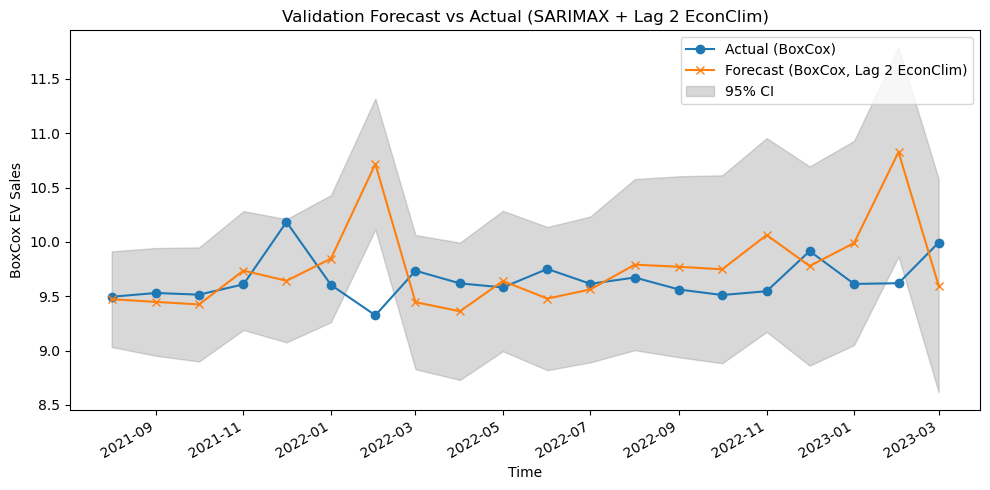

In [ ]:
# Prepare exogenous predictor for train/val split (Economic climate perception, lag 2)
econclim_lag2_train = econclim_train.shift(2).dropna()
target_train_clean = df["BoxCox vehicles sold (Target)"].loc[econclim_lag2_train.index]
econclim_lag2_train_clean = econclim_lag2_train

econclim_lag2_val = econclim_val.shift(2).dropna()
target_val_clean = df["BoxCox vehicles sold (Target)"].loc[econclim_lag2_val.index]
econclim_lag2_val_clean = econclim_lag2_val

# Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=econclim_lag2_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Forecast validation set
forecast = results.get_forecast(steps=len(econclim_lag2_val_clean), exog=econclim_lag2_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_clean.index
ax.plot(val_dates, target_val_clean, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, Lag 2 EconClim)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Lag 2 EconClim)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


Willingness to buy (E)'

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

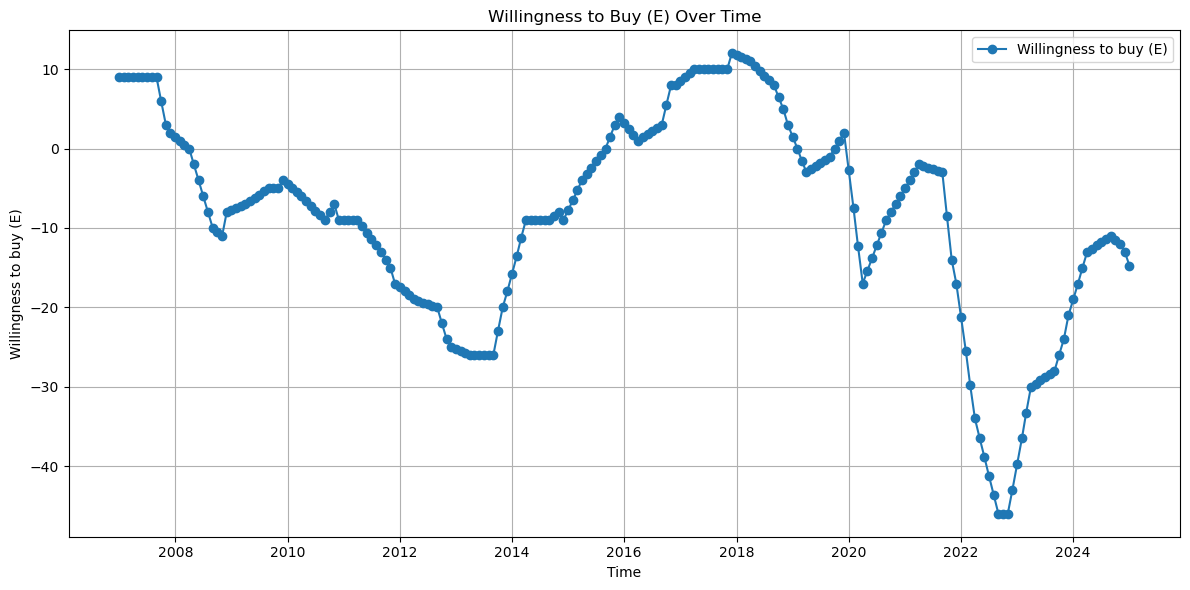

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Willingness to buy (E)"], marker='o', label="Willingness to buy (E)")
plt.xlabel("Time")
plt.ylabel("Willingness to buy (E)")
plt.title("Willingness to Buy (E) Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Box-Cox lambda for 'Willingness to buy (E)': 1.3671


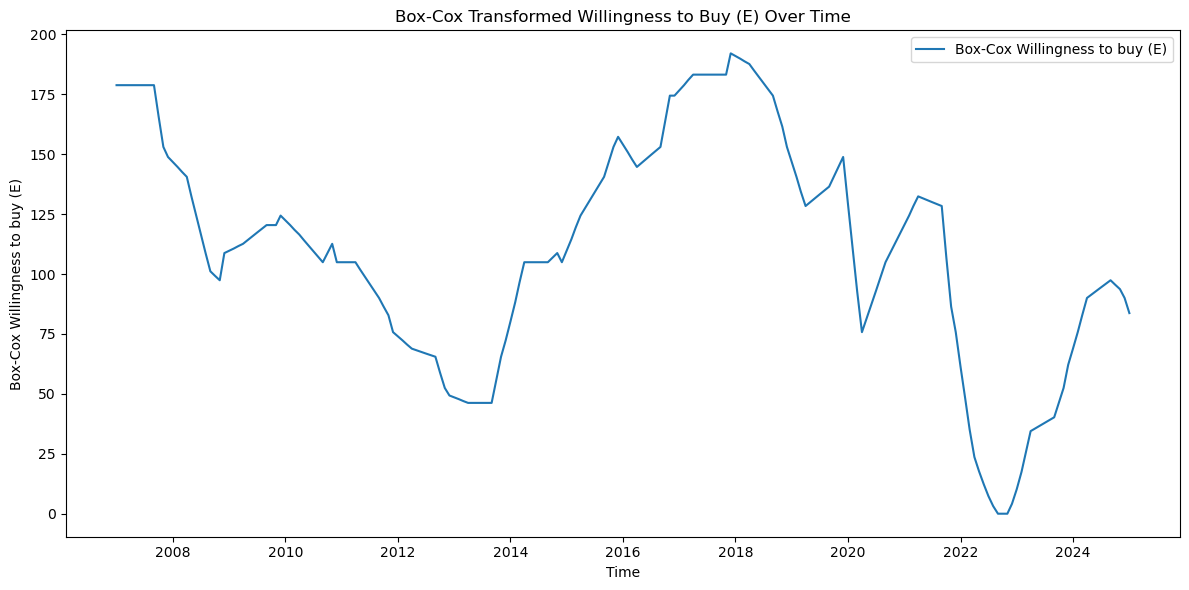

In [ ]:
# Box-Cox transform for 'Willingness to buy (E)'
willingness_col = "Willingness to buy (E)"
willingness_values = df[willingness_col].values

# Box-Cox requires strictly positive values, so add a constant if needed
if (willingness_values <= 0).any():
    willingness_values_shifted = willingness_values - willingness_values.min() + 1
else:
    willingness_values_shifted = willingness_values

willingness_boxcox, willingness_lambda = boxcox(willingness_values_shifted)

# Save transformed values to the DataFrame
df['BoxCox ' + willingness_col] = willingness_boxcox

print(f"Box-Cox lambda for '{willingness_col}': {willingness_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, willingness_boxcox, label="Box-Cox Willingness to buy (E)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Willingness to buy (E)")
plt.title("Box-Cox Transformed Willingness to Buy (E) Over Time")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

In [ ]:
# Perform Augmented Dickey-Fuller test on Box-Cox transformed Willingness to buy (E)
from statsmodels.tsa.stattools import adfuller

adf_willingness = adfuller(willingness_boxcox)

print("ADF Statistic (Box-Cox Willingness to buy): {:.4f}".format(adf_willingness[0]))
print("p-value: {:.4f}".format(adf_willingness[1]))
for key, value in adf_willingness[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_willingness[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic (Box-Cox Willingness to buy): -2.3999
p-value: 0.1418
Critical Value (1%): -3.4611
Critical Value (5%): -2.8751
Critical Value (10%): -2.5740
The series is likely non-stationary (fail to reject H0).


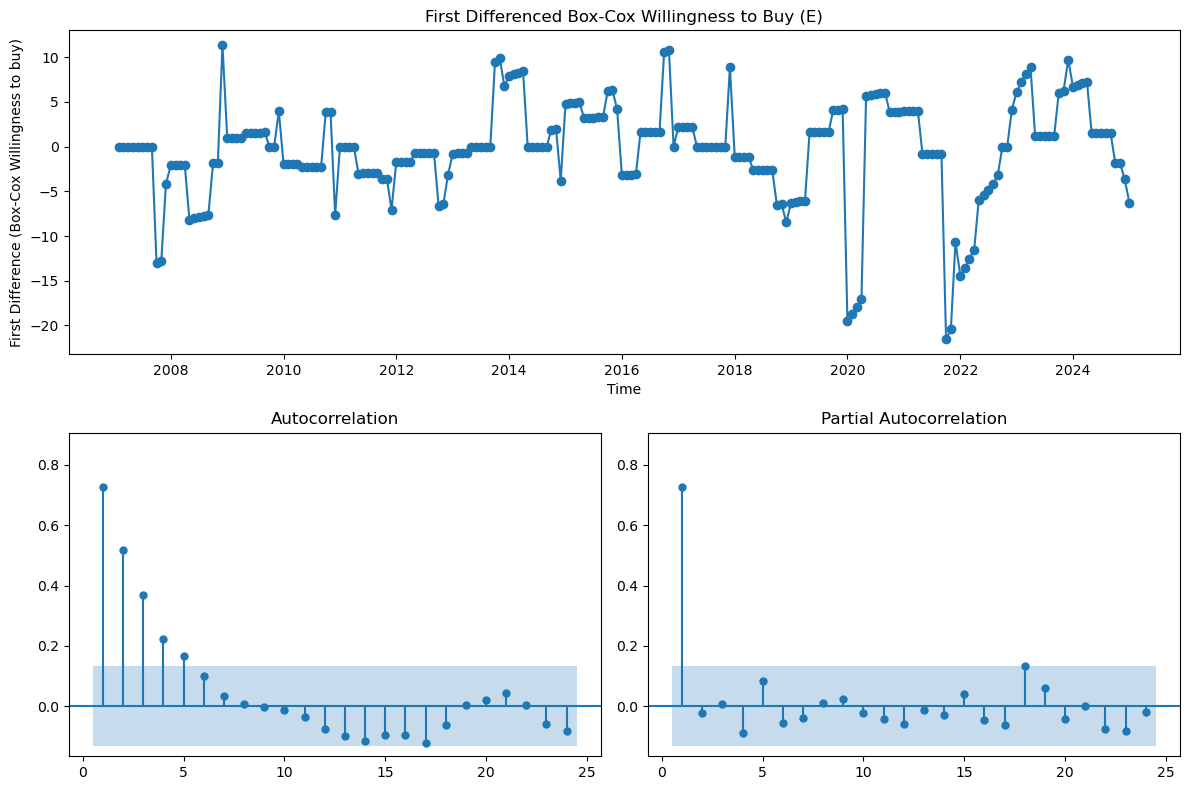

ADF Statistic (first difference): -5.7392
p-value: 0.0000
Critical Value (1%): -3.4611
Critical Value (5%): -2.8751
Critical Value (10%): -2.5740
The series is likely stationary (reject H0).


In [ ]:
# Convert BoxCox Willingness to buy (E) to Series to align with time index
willingness_boxcox_series = pd.Series(willingness_boxcox, index=df.index)

# Compute first order difference
willingness_diff1 = willingness_boxcox_series.diff(1).dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df.index[1:], willingness_diff1, marker="o")
ax1.set_ylabel("First Difference (Box-Cox Willingness to buy)")
ax1.set_xlabel("Time")
ax1.set_title("First Differenced Box-Cox Willingness to Buy (E)")

# ACF and PACF
plot_acf(willingness_diff1, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(willingness_diff1, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result_willingness = adfuller(willingness_diff1)

print("ADF Statistic (first difference): {:.4f}".format(adf_result_willingness[0]))
print("p-value: {:.4f}".format(adf_result_willingness[1]))
for key, value in adf_result_willingness[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result_willingness[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

### 3. Split Data

lets do 80/10/10 split for train/validation/test sets

In [ ]:
# Align index if needed (should already be DatetimeIndex)
willingness_diff1 = willingness_diff1.copy()
willingness_diff1.index = df.index[-len(willingness_diff1):]

# Calculate split indices for 80/10/10 split
n = len(willingness_diff1)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

dates = willingness_diff1.index
train_idx = dates[:train_end]
val_idx = dates[train_end:val_end]
test_idx = dates[val_end:]

# Split the series
willing_train = willingness_diff1.loc[train_idx]
willing_val = willingness_diff1.loc[val_idx]
willing_test = willingness_diff1.loc[test_idx]

print(f"Train length: {len(willing_train)}")
print(f"Validation length: {len(willing_val)}")
print(f"Test length: {len(willing_test)}")

Train length: 172
Validation length: 22
Test length: 22


### 4. Fit SARIMA model on the training set

In [ ]:
# Use willingness instead of consconf for lag testing
max_lag = 5  # How many lags you'd like to test

# Ensure df is indexed by datetime and has freq set
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index("Time Period (T)")
if df.index.freq is None:
    df = df.asfreq("MS")  # Set to monthly start, adjust if your data is not monthly

target_series = df["BoxCox vehicles sold (Target)"].loc[willing_train.index]

lag_results = []

for lag in range(0, max_lag + 1):
    if lag == 0:
        exog = willing_train.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = willing_train.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    model = SARIMAX(
        model_target,
        exog=exog,
        order=(2, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": results.pvalues.get(label, None),
        "Log Likelihood": results.llf
    })

lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n📊 Lag Comparison Summary:")
print(lag_df)


📊 Lag Comparison Summary:
    Lag       AIC        BIC Coefficient p-value  Log Likelihood
2  lag2 -9.515641   8.303239                None       10.757820
3  lag3 -6.882605  10.894463                None        9.441302
0  lag0 -6.690840  11.210800                None        9.345420
4  lag4 -6.030475  11.704488                None        9.015237
1  lag1 -5.810730  12.049672                None        8.905365
5  lag5 -5.228860  12.463699                None        8.614430


### 5. evaluate model/ combine model### 5. evaluate model/ combine model

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  170
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  10.758
Date:                            Mon, 14 Jul 2025   AIC                             -9.516
Time:                                    15:15:00   BIC                              8.303
Sample:                                04-01-2007   HQIC                            -2.275
                                     - 05-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0063      0.004      1.519      0.129      -0.002       0.015
ar.L1          1.2519      0.170   

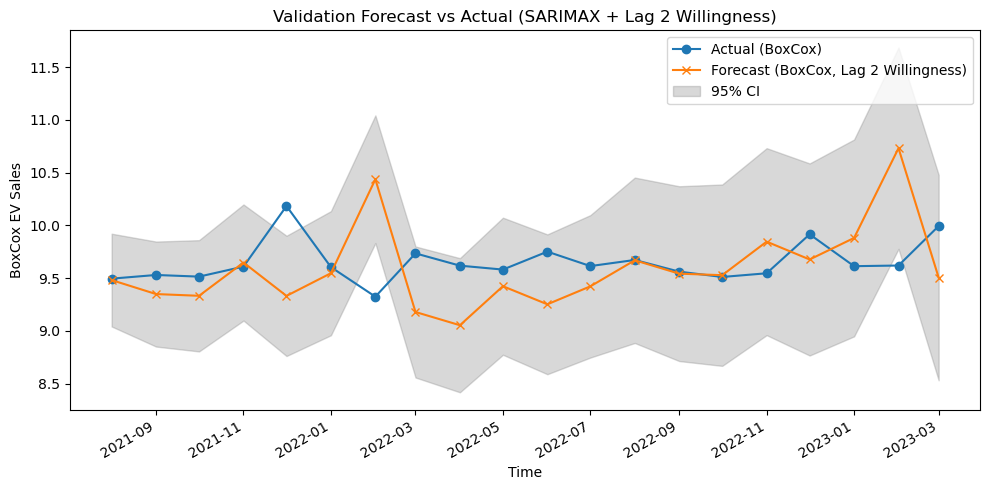

In [ ]:
# Prepare exogenous predictor for train/val split (Willingness to buy, lag 2)
willing_lag2_train = willing_train.shift(2).dropna()
target_train_clean = df["BoxCox vehicles sold (Target)"].loc[willing_lag2_train.index]
willing_lag2_train_clean = willing_lag2_train

willing_lag2_val = willing_val.shift(2).dropna()
target_val_clean = df["BoxCox vehicles sold (Target)"].loc[willing_lag2_val.index]
willing_lag2_val_clean = willing_lag2_val

# Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=willing_lag2_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Forecast validation set
forecast = results.get_forecast(steps=len(willing_lag2_val_clean), exog=willing_lag2_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_clean.index
ax.plot(val_dates, target_val_clean, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, Lag 2 Willingness)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Lag 2 Willingness)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


# Fuel prices:
- 'Diesel price (E)', Gasoline price (E)'

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

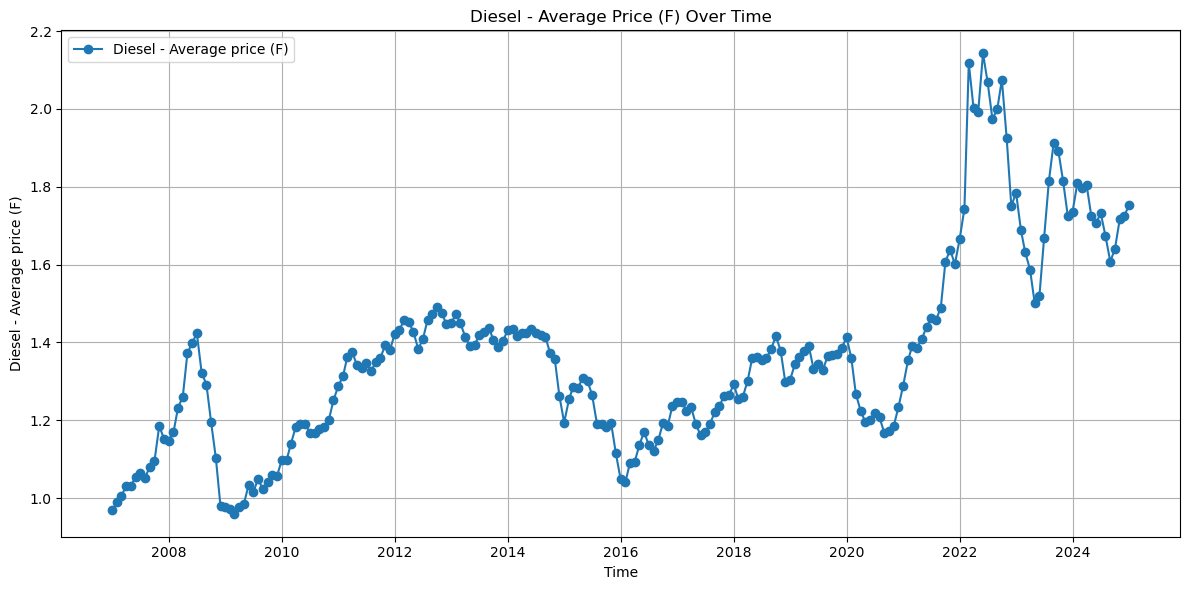

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Diesel - Average price (F)"], marker='o', label="Diesel - Average price (F)")
plt.xlabel("Time")
plt.ylabel("Diesel - Average price (F)")
plt.title("Diesel - Average Price (F) Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

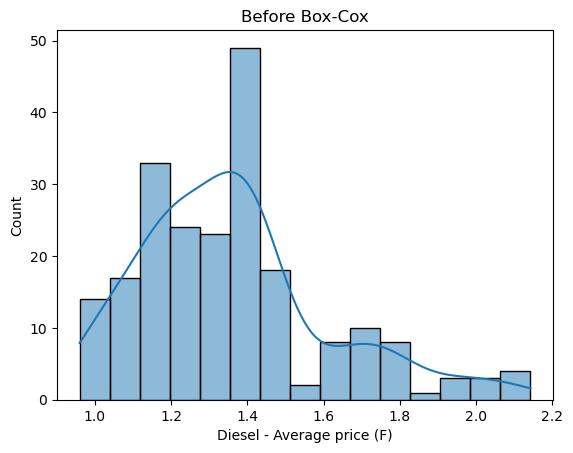

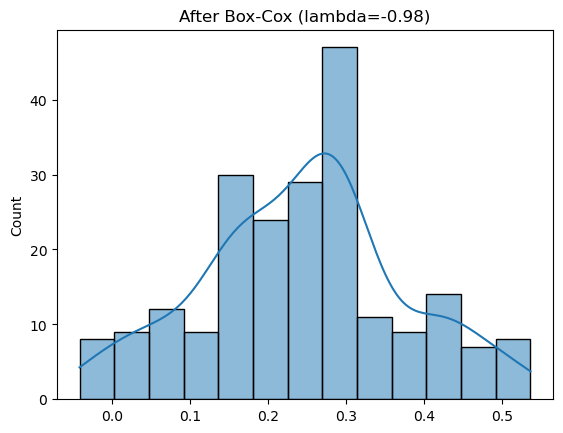

In [ ]:
# Select the diesel price series from the dataframe
diesel_series = df["Diesel - Average price (F)"].dropna()

# Check skewness before transformation
sns.histplot(diesel_series, kde=True)
plt.title("Before Box-Cox")
plt.show()

# Apply Box-Cox (automatically finds lambda)
diesel_transformed, diesel_lambda = boxcox(diesel_series)

sns.histplot(diesel_transformed, kde=True)
plt.title(f"After Box-Cox (lambda={diesel_lambda:.2f})")
plt.show()

Box-Cox lambda for 'Diesel - Average price (F)': -0.9826


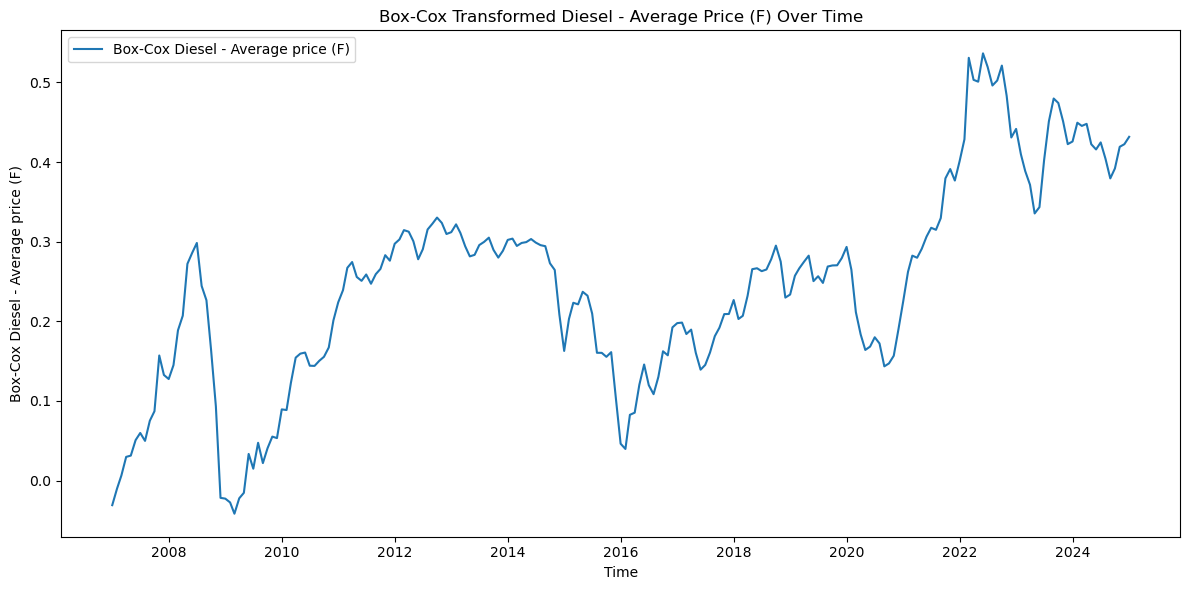

In [ ]:
from scipy.stats import boxcox

# Box-Cox transform for 'Diesel - Average price (F)'

diesel_col = "Diesel - Average price (F)"
diesel_values = df[diesel_col].dropna().values

# Box-Cox requires strictly positive values, so add a small constant if needed
if (diesel_values <= 0).any():
    diesel_values_shifted = diesel_values - diesel_values.min() + 1
else:
    diesel_values_shifted = diesel_values

diesel_boxcox, diesel_lambda = boxcox(diesel_values_shifted)

# Save transformed values to the DataFrame (align index)
df.loc[df[diesel_col].notna(), 'BoxCox ' + diesel_col] = diesel_boxcox

print(f"Box-Cox lambda for '{diesel_col}': {diesel_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df.index[df[diesel_col].notna()], diesel_boxcox, label="Box-Cox Diesel - Average price (F)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Diesel - Average price (F)")
plt.title("Box-Cox Transformed Diesel - Average Price (F) Over Time")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test on Box-Cox transformed Diesel - Average price (F)

adf_diesel_boxcox = adfuller(df['BoxCox Diesel - Average price (F)'].dropna())

print("ADF Statistic (Box-Cox Diesel): {:.4f}".format(adf_diesel_boxcox[0]))
print("p-value: {:.4f}".format(adf_diesel_boxcox[1]))
for key, value in adf_diesel_boxcox[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_diesel_boxcox[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic (Box-Cox Diesel): -2.2554
p-value: 0.1868
Critical Value (1%): -3.4611
Critical Value (5%): -2.8751
Critical Value (10%): -2.5740
The series is likely non-stationary (fail to reject H0).


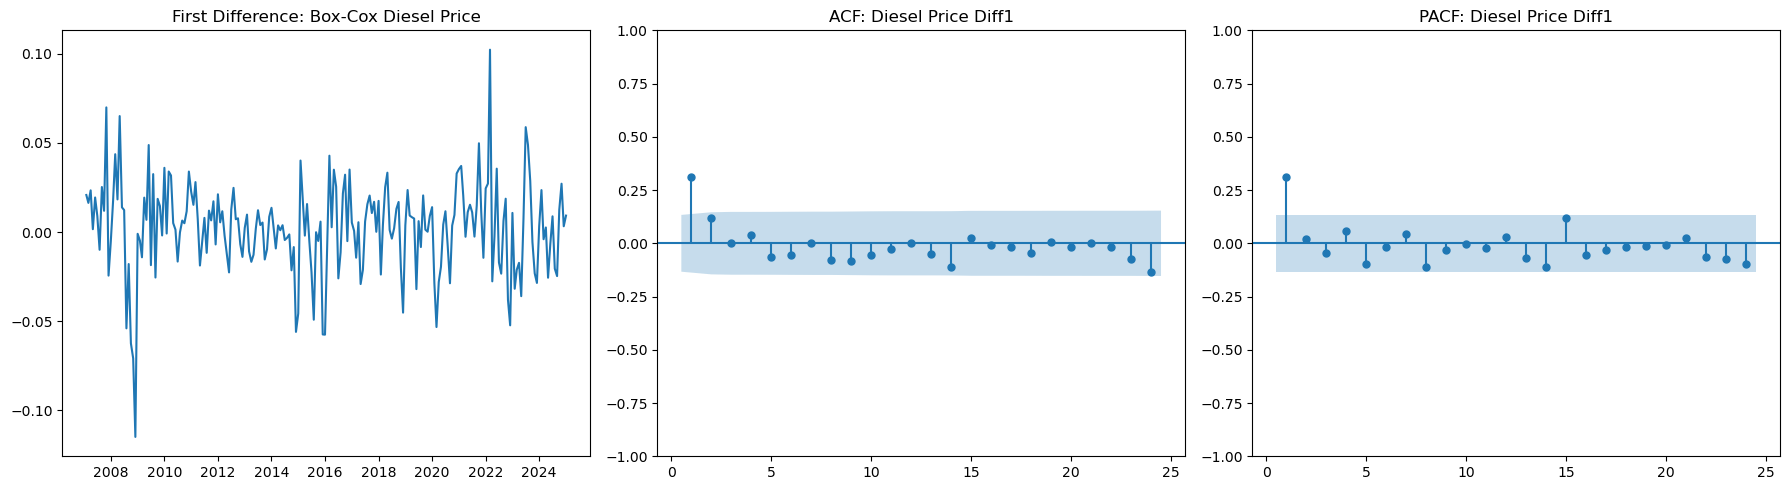

ADF Statistic (Diff1): -10.5645
p-value: 0.0000
Critical Value (1%): -3.4611
Critical Value (5%): -2.8751
Critical Value (10%): -2.5740
The differenced series is likely stationary (reject H0).


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Use Box-Cox transformed diesel series (already in df['BoxCox Diesel - Average price (F)'])
diesel_boxcox_series = pd.Series(df['BoxCox Diesel - Average price (F)'].dropna(), index=df.index[df['BoxCox Diesel - Average price (F)'].notna()])


# First difference to address non-stationarity if needed
diesel_diff1 = diesel_boxcox_series.diff().dropna()

# Plot first-differenced series and its ACF/PACF
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(diesel_diff1)
axes[0].set_title("First Difference: Box-Cox Diesel Price")
plot_acf(diesel_diff1, lags=24, ax=axes[1], zero=False)
axes[1].set_title("ACF: Diesel Price Diff1")
plot_pacf(diesel_diff1, lags=24, ax=axes[2], zero=False)
axes[2].set_title("PACF: Diesel Price Diff1")
plt.tight_layout()
plt.show()

# Augmented Dickey-Fuller test on first-differenced series
adf_diff1 = adfuller(diesel_diff1)
print("ADF Statistic (Diff1): {:.4f}".format(adf_diff1[0]))
print("p-value: {:.4f}".format(adf_diff1[1]))
for key, value in adf_diff1[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_diff1[1] < 0.05:
    print("The differenced series is likely stationary (reject H0).")
else:
    print("The differenced series is likely non-stationary (fail to reject H0).")

### 3. Split Data

lets do 80/10/10 split for train/validation/test se

In [ ]:
# Align index if needed (should already be DatetimeIndex)
diesel_diff1 = diesel_diff1.copy()
diesel_diff1.index = df.index[-len(diesel_diff1):]

# Calculate split indices for 80/10/10 split
n = len(diesel_diff1)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

dates = diesel_diff1.index
train_idx = dates[:train_end]
val_idx = dates[train_end:val_end]
test_idx = dates[val_end:]

# Split the series
diesel_train = diesel_diff1.loc[train_idx]
diesel_val = diesel_diff1.loc[val_idx]
diesel_test = diesel_diff1.loc[test_idx]

print(f"Train length: {len(diesel_train)}")
print(f"Validation length: {len(diesel_val)}")
print(f"Test length: {len(diesel_test)}")

Train length: 172
Validation length: 22
Test length: 22


### 4. Fit SARIMA model on the training set

In [ ]:
# Use diesel_diff1 instead of willing_train for lag testing
max_lag = 5  # How many lags you'd like to test

# Ensure df is indexed by datetime and has freq set
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index("Time Period (T)")
if df.index.freq is None:
    df = df.asfreq("MS")  # Set to monthly start, adjust if your data is not monthly

target_series = df["BoxCox vehicles sold (Target)"].loc[diesel_train.index]

lag_results = []

for lag in range(0, max_lag + 1):
    if lag == 0:
        exog = diesel_train.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = diesel_train.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    model = SARIMAX(
        model_target,
        exog=exog,
        order=(2, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": results.pvalues.get(label, None),
        "Log Likelihood": results.llf
    })

lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n📊 Lag Comparison Summary:")
print(lag_df)


📊 Lag Comparison Summary:
    Lag       AIC        BIC Coefficient p-value  Log Likelihood
2  lag2 -7.418838  10.400041                None        9.709419
0  lag0 -7.010902  10.890738                None        9.505451
4  lag4 -6.942604  10.792358                None        9.471302
3  lag3 -6.687092  11.089976                None        9.343546
5  lag5 -6.388095  11.304464                None        9.194048
1  lag1 -5.955973  11.904429                None        8.977987


### 5. evaluate model/ combine model### 5. evaluate model/ combine model

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  170
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   9.709
Date:                            Mon, 14 Jul 2025   AIC                             -7.419
Time:                                    15:29:52   BIC                             10.400
Sample:                                04-01-2007   HQIC                            -0.178
                                     - 05-01-2021                                         
Covariance Type:                              opg                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
BoxCox Diesel - Average price (F)    -0.3822      1.001     -0.382  

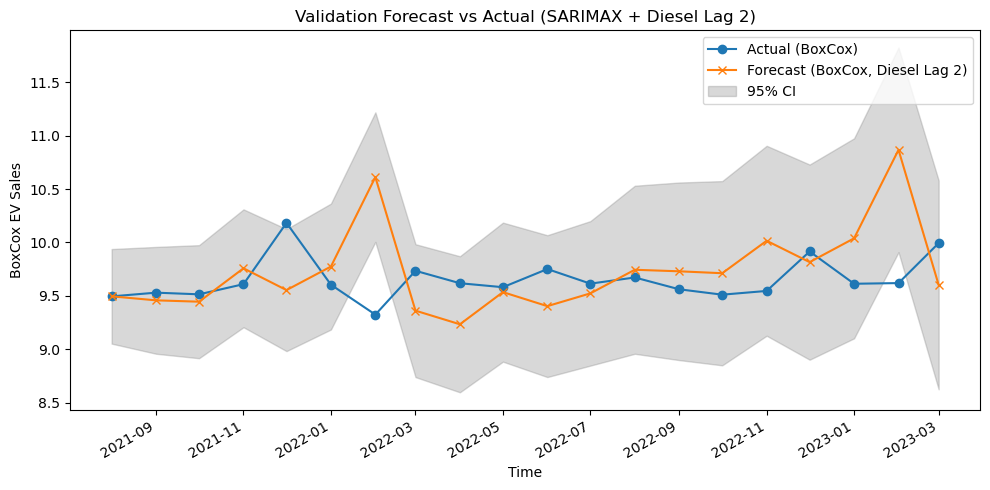

In [ ]:
# Prepare lagged exogenous predictor for train/val split (Diesel price, lag 2)
diesel_lag2_train = diesel_train.shift(2).dropna()
target_train_clean = df["BoxCox vehicles sold (Target)"].loc[diesel_lag2_train.index]
diesel_lag2_train_clean = diesel_lag2_train

diesel_lag2_val = diesel_val.shift(2).dropna()
target_val_clean = df["BoxCox vehicles sold (Target)"].loc[diesel_lag2_val.index]
diesel_lag2_val_clean = diesel_lag2_val

# Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=diesel_lag2_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Forecast validation set
forecast = results.get_forecast(steps=len(diesel_lag2_val_clean), exog=diesel_lag2_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_clean.index
ax.plot(val_dates, target_val_clean, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, Diesel Lag 2)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Diesel Lag 2)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

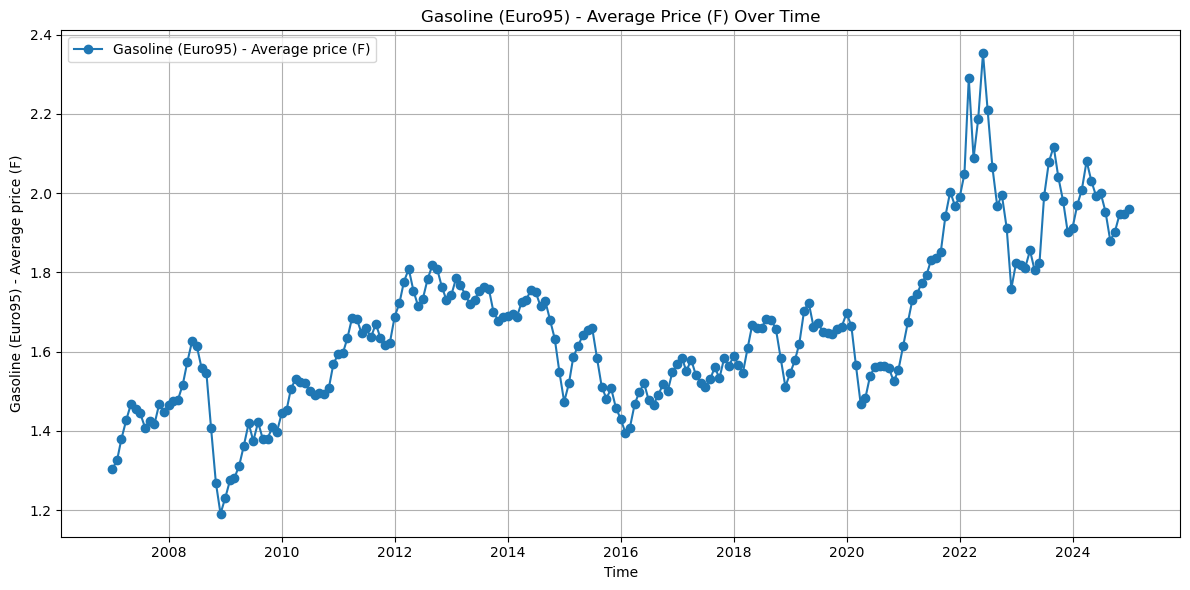

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Gasoline (Euro95) - Average price (F)"], marker='o', label="Gasoline (Euro95) - Average price (F)")
plt.xlabel("Time")
plt.ylabel("Gasoline (Euro95) - Average price (F)")
plt.title("Gasoline (Euro95) - Average Price (F) Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Box-Cox lambda for 'Gasoline (Euro95) - Average price (F)': -0.8395


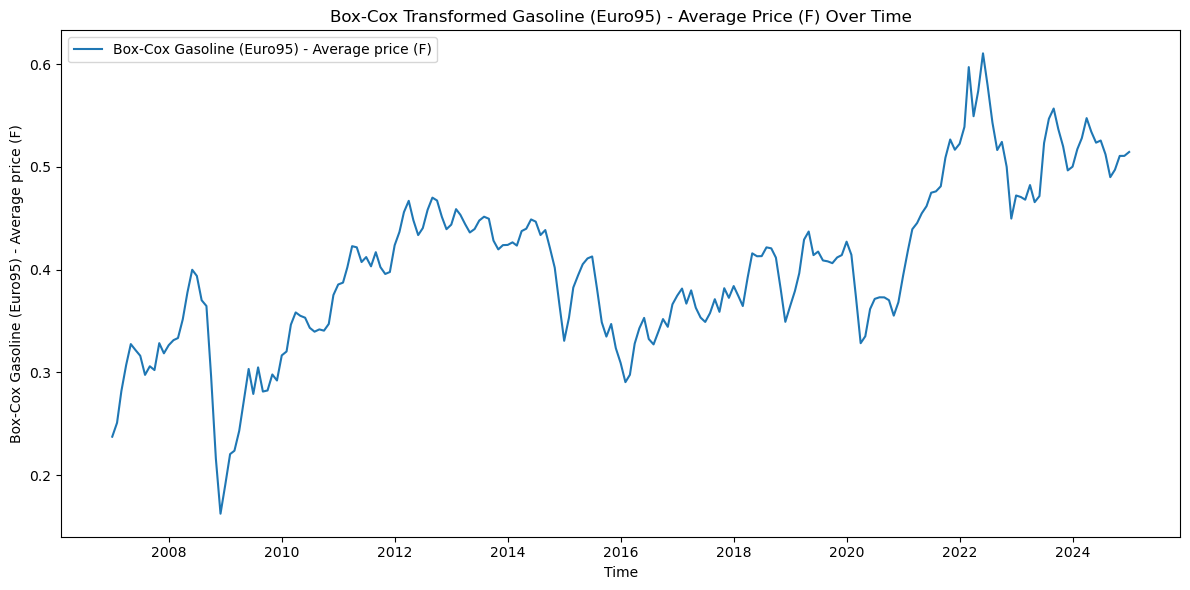

In [ ]:
# Box-Cox transform for 'Gasoline (Euro95) - Average price (F)'
gasoline_col = "Gasoline (Euro95) - Average price (F)"
gasoline_values = df[gasoline_col].dropna().values

# Box-Cox requires strictly positive values, so add a small constant if needed
if (gasoline_values <= 0).any():
    gasoline_values_shifted = gasoline_values - gasoline_values.min() + 1
else:
    gasoline_values_shifted = gasoline_values

gasoline_boxcox, gasoline_lambda = boxcox(gasoline_values_shifted)

# Save transformed values to the DataFrame (align index)
df.loc[df[gasoline_col].notna(), 'BoxCox ' + gasoline_col] = gasoline_boxcox

print(f"Box-Cox lambda for '{gasoline_col}': {gasoline_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df.index[df[gasoline_col].notna()], gasoline_boxcox, label="Box-Cox Gasoline (Euro95) - Average price (F)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Gasoline (Euro95) - Average price (F)")
plt.title("Box-Cox Transformed Gasoline (Euro95) - Average Price (F) Over Time")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Stationarity Check

In [ ]:
# Perform Augmented Dickey-Fuller test on Box-Cox transformed Gasoline (Euro95) - Average price (F)
adf_gasoline_boxcox = adfuller(df['BoxCox Gasoline (Euro95) - Average price (F)'].dropna())

print("ADF Statistic (Box-Cox Gasoline): {:.4f}".format(adf_gasoline_boxcox[0]))
print("p-value: {:.4f}".format(adf_gasoline_boxcox[1]))
for key, value in adf_gasoline_boxcox[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_gasoline_boxcox[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic (Box-Cox Gasoline): -2.6768
p-value: 0.0781
Critical Value (1%): -3.4611
Critical Value (5%): -2.8751
Critical Value (10%): -2.5740
The series is likely non-stationary (fail to reject H0).


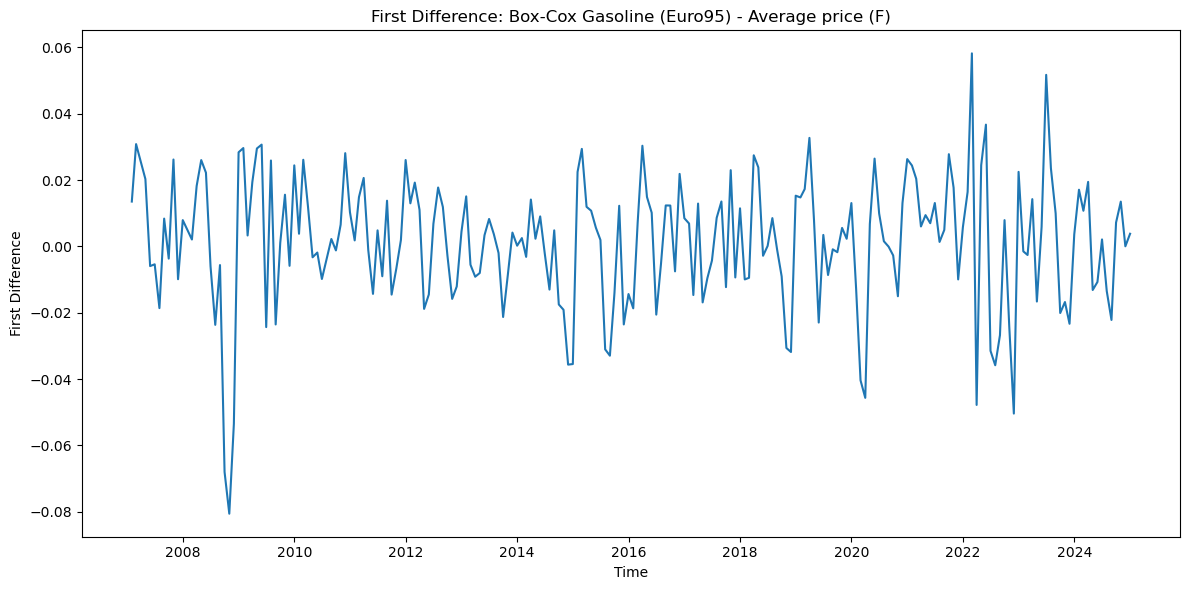

ADF Statistic (Diff1): -7.9297
p-value: 0.0000
Critical Value (1%): -3.4619
Critical Value (5%): -2.8754
Critical Value (10%): -2.5742
The differenced series is likely stationary (reject H0).


In [ ]:
# First order difference of Box-Cox Gasoline (Euro95) - Average price (F)
gasoline_boxcox_series = pd.Series(df['BoxCox Gasoline (Euro95) - Average price (F)'].dropna(), index=df.index[df['BoxCox Gasoline (Euro95) - Average price (F)'].notna()])
gasoline_diff1 = gasoline_boxcox_series.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(gasoline_diff1)
plt.title("First Difference: Box-Cox Gasoline (Euro95) - Average price (F)")
plt.xlabel("Time")
plt.ylabel("First Difference")
plt.tight_layout()
plt.show()

# Augmented Dickey-Fuller test on first-differenced series
adf_gasoline_diff1 = adfuller(gasoline_diff1)
print("ADF Statistic (Diff1): {:.4f}".format(adf_gasoline_diff1[0]))
print("p-value: {:.4f}".format(adf_gasoline_diff1[1]))
for key, value in adf_gasoline_diff1[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_gasoline_diff1[1] < 0.05:
    print("The differenced series is likely stationary (reject H0).")
else:
    print("The differenced series is likely non-stationary (fail to reject H0).")


    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plot_acf(gasoline_diff1, lags=24, ax=axes[0], zero=False)
    axes[0].set_title("ACF: Gasoline Diff1")
    plot_pacf(gasoline_diff1, lags=24, ax=axes[1], zero=False)
    axes[1].set_title("PACF: Gasoline Diff1")
    plt.tight_layout()
    plt.show()

### 3. Split Data


In [ ]:
# Align index if needed (should already be DatetimeIndex)
gasoline_diff1 = gasoline_diff1.copy()
gasoline_diff1.index = df.index[-len(gasoline_diff1):]

# Calculate split indices for 80/10/10 split
n = len(gasoline_diff1)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

dates = gasoline_diff1.index
train_idx = dates[:train_end]
val_idx = dates[train_end:val_end]
test_idx = dates[val_end:]

# Split the series
gasoline_train = gasoline_diff1.loc[train_idx]
gasoline_val = gasoline_diff1.loc[val_idx]
gasoline_test = gasoline_diff1.loc[test_idx]

print(f"Train length: {len(gasoline_train)}")
print(f"Validation length: {len(gasoline_val)}")
print(f"Test length: {len(gasoline_test)}")

Train length: 172
Validation length: 22
Test length: 22


In [ ]:
# Use gasoline_diff1 instead of diesel_train for lag testing
max_lag = 5  # How many lags you'd like to test

# Ensure df is indexed by datetime and has freq set
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index("Time Period (T)")
if df.index.freq is None:
    df = df.asfreq("MS")  # Set to monthly start, adjust if your data is not monthly

target_series = df["BoxCox vehicles sold (Target)"].loc[gasoline_train.index]

lag_results = []

for lag in range(0, max_lag + 1):
    if lag == 0:
        exog = gasoline_train.copy()
        label = "lag0"
        model_target = target_series
    else:
        exog = gasoline_train.shift(lag).dropna()
        model_target = target_series.loc[exog.index]
        label = f"lag{lag}"

    exog.index = pd.DatetimeIndex(exog.index)
    model_target.index = pd.DatetimeIndex(model_target.index)
    if exog.index.freq is None:
        exog.index = exog.index.to_period("M").to_timestamp()
    if model_target.index.freq is None:
        model_target.index = model_target.index.to_period("M").to_timestamp()

    model = SARIMAX(
        model_target,
        exog=exog,
        order=(2, 0, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)

    lag_results.append({
        "Lag": label,
        "AIC": results.aic,
        "BIC": results.bic,
        "Coefficient p-value": results.pvalues.get(label, None),
        "Log Likelihood": results.llf
    })

lag_df = pd.DataFrame(lag_results).sort_values("AIC")
print("\n📊 Lag Comparison Summary:")
print(lag_df)


📊 Lag Comparison Summary:
    Lag       AIC        BIC Coefficient p-value  Log Likelihood
4  lag4 -7.437638  10.297324                None        9.718819
3  lag3 -7.216340  10.560728                None        9.608170
2  lag2 -7.196420  10.622459                None        9.598210
0  lag0 -6.484936  11.416704                None        9.242468
5  lag5 -6.106324  11.586236                None        9.053162
1  lag1 -5.820193  12.040209                None        8.910097


### 4. Fit SARIMA model on the training set

### 5. evaluate model/ combine model### 5. evaluate model/ combine model


                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  168
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                   9.719
Date:                            Mon, 14 Jul 2025   AIC                             -7.438
Time:                                    15:36:55   BIC                             10.297
Sample:                                06-01-2007   HQIC                            -0.231
                                     - 05-01-2021                                         
Covariance Type:                              opg                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
BoxCox Gasoline (Euro95) - Average price (F)  

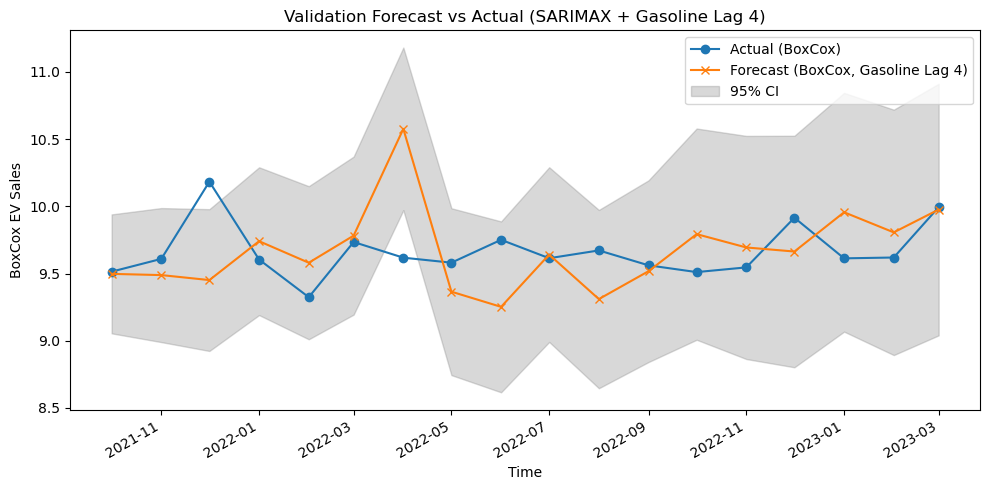

In [ ]:
# Prepare lagged exogenous predictor for train/val split (Gasoline price, lag 4)
gasoline_lag4_train = gasoline_train.shift(4).dropna()
target_train_clean = df["BoxCox vehicles sold (Target)"].loc[gasoline_lag4_train.index]
gasoline_lag4_train_clean = gasoline_lag4_train

gasoline_lag4_val = gasoline_val.shift(4).dropna()
target_val_clean = df["BoxCox vehicles sold (Target)"].loc[gasoline_lag4_val.index]
gasoline_lag4_val_clean = gasoline_lag4_val

# Fit SARIMAX model
model = SARIMAX(
    target_train_clean,
    exog=gasoline_lag4_train_clean,
    order=(2, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

# Forecast validation set
forecast = results.get_forecast(steps=len(gasoline_lag4_val_clean), exog=gasoline_lag4_val_clean)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate performance
rmse = np.sqrt(mean_squared_error(target_val_clean, preds))
mape = mean_absolute_percentage_error(target_val_clean, preds) * 100

print(f"\n📊 Forecast Evaluation (Validation Set):")
print(f"RMSE (BoxCox): {rmse:.4f}")
print(f"MAPE (BoxCox): {mape:.2f}%")

# Back-transform predictions and actuals to original scale
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

preds_back = inv_boxcox(preds.values, fitted_lambda)
actuals_back = inv_boxcox(target_val_clean.values, fitted_lambda)

rmse_back = np.sqrt(mean_squared_error(actuals_back, preds_back))
mape_back = mean_absolute_percentage_error(actuals_back, preds_back) * 100

print(f"RMSE (Back-transformed): {rmse_back:.2f}")
print(f"MAPE (Back-transformed): {mape_back:.2f}%")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
val_dates = target_val_clean.index
ax.plot(val_dates, target_val_clean, label="Actual (BoxCox)", marker='o')
ax.plot(val_dates, preds, label="Forecast (BoxCox, Gasoline Lag 4)", marker='x')
ax.fill_between(val_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
ax.set_title("Validation Forecast vs Actual (SARIMAX + Gasoline Lag 4)")
ax.set_xlabel("Time")
ax.set_ylabel("BoxCox EV Sales")
ax.legend()
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


# RESULTS

| Model                        | MAPE (Back-transformed) | RMSE (Back-transformed) |
|------------------------------|------------------------|------------------------|
| Consumer Confidence          | 24.11                  | 8084.01                |
| Baseline (No exog)           | 25.62                  | 8822.05                |
| Gasoline Price (Lag 4)       | 28.69                  | 8287.79                |
| Google Search                | 33.46                  | 11693.14               |
| Electric Car (G)             | 33.46                  | 11693.14               |
| Home Charging                | 36.37                  | 10380.46               |
| Company Car Tax (Lag 12)     | 37.96                  | 13033.54               |
| Willingness to Buy           | 40.87                  | 11342.94               |
| Diesel Price (Lag 2)         | 47.09                  | 13269.11               |
| Economic Climate             | 48.61                  | 13513.03               |